![](mldd_diagram_lab5.png)

# Introduction to (Deep) Generative Models

Generative models are unsupervised ML algorithms, which means that the input data (usually) does not contain labels. Based on the input representation, generative models learn data distribution, which enables generation of novel examples that are similar to those observed in the training.

A typical application of generative models is image, text, or compound generation. Several classes of generative models based on neural networks are presented below.

1. **Autoencoder** - a model that consists of two networks, an encoder and decoder. The encoder takes the input representation of data and transforms it into a lower-dimensional latent representation (numerical vector). The decoder uses encoded vectors to reconstruct the initial data representation. We can write that $x'=D(E(x))$, and the optimization target is to minimize the difference between the input object $x$ and the reconstructed object $x'$, so the loss function can be $\mathcal{L}=\|x-x' \|_2$ in the case of simple numerical objects as for example images. To make this model generative, the latent space is additionally constrained to follow the Gaussian distribution, i.e. $\mathcal{L}=\|x-x' \|_2 + \mathcal{L}_{normal}(E(x))$. Then, if we sample a latent vector $z\sim \mathcal{N}(0, 1)$ and transform it using the decoder $x'=D(z)$, we will obtain a new generated object.
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png)
2. **Recurrent neural network (autoregressive modeling)** - a type of neural network in which a partial output is used as the input to the next segment of the network. Recurrent neural networks generate objects by growing object fragments, e.g. texts can be generated word-by-word, and molecules can be created by adding atoms iteratively. The intermediate steps of the generative process are used as the input to the model which decides about the next generation step.
![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Gated_Recurrent_Unit.svg)

# How generative models are used to design new drugs

There are two ways in which generative models can be applied in drug design. We can generate compounds from scratch, and we call this process *de novo* drug design. The other application is optimization of existing molecules, e.g. during the **lead optimization** stage of drug discovery where our promising compound (so called lead) is modified to increase the activity or optimize other molecular properties (ADMET).

Two types of generators can be used to invent new compounds: those based on **SMILES** and those based on **molecular graphs**. We can generate a SMILES sequence, but this representation is prone to produce invalid molecules (SMILES has a strict grammar), on top of other shortcomings discussed when introducing SMILES predictive models. Graph generation seems more reasonable, but this approach also has some downsides:

1. Sequential atom-by-atom generation leads to **incorrect intermediate states**. For example, to generate a ring, we need to first generate a long chain of atoms that is closed in the last step. One possible solution to this problem is fragment-based design where we expand molecules by attaching whole structures (e.g. rings) instead of single atoms.
2. Molecular graphs are **discrete structures** meaning that atoms and bonds are defined by binary features. We cannot generate partial bonds or mixed atom symbols. Hence, the continuous output of a neural network needs to be converted to a discrete structure, e.g. an adjacency matrix should be rounded to contain only zeros and ones. By discretizing outputs, we lose differentiability of the network, so we can apply the loss function only to the incorrect continuous representation of the molecule before rounding all the numbers. There are some solutions to this problem, e.g. Gumbel Softmax is a technique that allows to preserve the differentiability of the rounding operation. We can also use reinforcement learning that does not require the network to be differentiable (the gradients are calculated in a different way, based on a reward function).

Another factor we need to consider when designing drugs is optimization of molecular properties. Not only do we want to generate correct compounds, but also we need these molecules to be synthesizable and possess all the desirable properties. Tp that end, additional learning terms are often included in the generative process.

# SMILES-based generative model: ReLeaSE

Code repo: https://github.com/isayev/ReLeaSE ([Paper](https://www.science.org/doi/epdf/10.1126/sciadv.aap7885))

**TL;DR**

In this paper, a SMILES generator is implemented. Because SMILES follows certain grammar rules, and it is "almost" a context-free grammar, for which there exists a pushdown automaton that accepts this grammar. A stack is needed for the model to remember, e.g., opening of parentheses that denote atom branches or numbers that denote ring closures. By adding a stack to a recurrent neural network (e.g. GRU), we can improve the validity of generated SMILES strings. Additionally, molecular properties of the generated compounds can be optimized by employing a predictive model that calculates the value of a reward function. The reward is calculated when the full SMILES string is generated. Model parameters are corrected using reinforcement learning, and more precisely the REINFORCE algorithm.

In [31]:
!git clone https://github.com/isayev/ReLeaSE.git

fatal: destination path 'ReLeaSE' already exists and is not an empty directory.


In [32]:
import sys
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/jkosciukiewicz/Developer/UJ/mldd24', '/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python310.zip', '/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python3.10', '/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python3.10/lib-dynload', '', '/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python3.10/site-packages', '/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python3.10/site-packages/PyQt5_sip-12.9.0-py3.10-macosx-11.0-arm64.egg', 'ReLeaSE/release', 'ReLeaSE/release', 'ReLeaSE/release', 'ReLeaSE/release', 'ReLeaSE/release', 'ReLeaSE/release', 'ReLeaSE/release']


In [33]:
import torch
from rdkit import Chem

In [34]:
from stackRNN import StackAugmentedRNN
from data import GeneratorData

use_cuda = False

In [35]:
hidden_size = 50
stack_width = 50
stack_depth = 10
lr = 0.001
optimizer_instance = torch.optim.Adadelta
layer_type = 'GRU'

gen_data_path = 'ReLeaSE/data/logP_labels.csv'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[1], keep_header=False)

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters,
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters,
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=True,
                                 has_stack=True,
                                 stack_width=stack_width,
                                 stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 optimizer_instance=optimizer_instance,
                                 lr=lr)
if use_cuda:
    my_generator = my_generator.cuda()

losses = my_generator.fit(gen_data, 1000)

my_generator.evaluate(gen_data)

Training in progress...:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/jkosciukiewicz/Developer/UJ/mldd24/labs/L5-generative-models/ReLeaSE/release/data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Training in progress...:  11%|█         | 107/1000 [00:01<00:11, 76.90it/s]

 1s (100 10%) 3.5344]
<rs3-76co5#coCl5A7]2(544is=4l13iFc[PAoO5<=7C=H7Pi#An> 



Training in progress...:  21%|██▏       | 213/1000 [00:02<00:10, 75.94it/s]

 2s (200 20%) 3.5189]
<iB3l-IsN15[6[2)r3NP1A2F-AIAHPi##HOiF2(O-F=1e)ns-Nl-nr3#Flen[1)1e#3#7o#-C)IC4l+4s[c]c#]2OB5eiOnss16l< 



Training in progress...:  31%|███       | 310/1000 [00:04<00:08, 77.53it/s]

 3s (300 30%) 3.5476]
<N<C=l1iHoBPBFBS+nS-Bso#HHN)[6oP3n]rFF> 



Training in progress...:  41%|████▏     | 413/1000 [00:05<00:07, 79.90it/s]

 5s (400 40%) 3.5295]
<H5l]#3#2SH6+S1<25SlCC6B6Ci)P6SIn> 



Training in progress...:  51%|█████     | 512/1000 [00:06<00:06, 80.85it/s]

 6s (500 50%) 3.4897]
<A> 



Training in progress...:  61%|██████    | 611/1000 [00:08<00:05, 75.05it/s]

 7s (600 60%) 3.4876]
<le<iI<#lOH(H17(+iFOCe=7Bi]A1e4FACP4SB1c1sFi++(-BrS1BN=cOH-P2> 



Training in progress...:  71%|███████   | 709/1000 [00:09<00:03, 80.26it/s]

 9s (700 70%) 3.4915]
<4P#OcP3]H7ie)> 



Training in progress...:  81%|████████▏ | 814/1000 [00:10<00:02, 79.63it/s]

 10s (800 80%) 3.5222]
<#++CACl11> 



Training in progress...:  91%|█████████▏| 914/1000 [00:11<00:01, 74.77it/s]

 11s (900 90%) 3.4634]
<SS55sSs6cr66A-> 



Training in progress...: 100%|██████████| 1000/1000 [00:12<00:00, 77.29it/s]

 12s (1000 100%) 3.4192]
<F6A5e-nr+OA<BOl-l]-Ss)(> 



'<H1s31(-NO7HcSe#+F7B#seOA=H]4i4eA#rCsn<#+3<]F)1l4>'

In [36]:
gen_data_path = 'ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

model = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=1500,
                                     output_size=gen_data.n_characters, 
                                     layer_type='GRU',
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=1500, stack_depth=10, 
                                     use_cuda=use_cuda)

if use_cuda:
    model.load_model('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn')
else:
    weights = torch.load('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn', map_location=torch.device('cpu'))
    model.load_state_dict(weights)

Random Smile:  CC12C(CC3(Cc4ccc(F)cc4)C(=O)N1Cc1ccccc1CC=C2C3=O)c1ccccc1


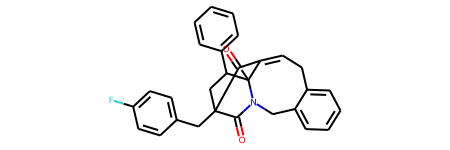

In [37]:
smiles = model.evaluate(gen_data)[1:-1]

print('Random Smile: ', smiles)
mol = Chem.MolFromSmiles(smiles)
if mol:
    display(mol)
else:
    print('Invalid SMILES!')

# Graph-based generative model: JT-VAE

Code repo: https://github.com/Bibyutatsu/FastJTNNpy3 ([Paper](https://arxiv.org/pdf/1802.04364.pdf))

**TL;DR**

JT-VAE is an autoencoder working on molecular graphs. To facilitate compound generation, structural formulas are converted to so-called junction trees, in which rings are transformed into single nodes. This way, instead of a graph, we obtain a tree structure that can be decoded to a compound. The graph encoder is a graph neural network (MPNN), and the tree encoder is a similar architecture, but only passes messages from the root to the leaves. The tree decoder is a recurrent neural network (GRU) that builds a tree in the DFS order. The graph decoder is used to correctly connect atoms after decoding tree nodes - rings have multiple possible attachment points. To optimize molecular properties, we can use Bayesian search of the encoded latent space.

In [38]:
!git clone https://github.com/Bibyutatsu/FastJTNNpy3.git

import sys
use_cuda = False
sys.path.append('FastJTNNpy3')

Cloning into 'FastJTNNpy3'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 402 (delta 31), reused 23 (delta 23), pack-reused 343
Receiving objects: 100% (402/402), 520.25 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [39]:
import fnmatch, os

if not use_cuda:
    for path, dirs, files in os.walk(os.path.abspath("FastJTNNpy3")):
        for filename in fnmatch.filter(files, "*.py"):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace(".cuda()", "")
            with open(filepath, "w") as f:
                f.write(s)

In [40]:
from rdkit import Chem
import torch

from fast_jtnn import *
import rdkit

def load_model(vocab, model_path, hidden_size=450, latent_size=56, depthT=20, depthG=3, use_cuda=True):
    vocab = [x.strip("\r\n ") for x in open(vocab)] 
    vocab = Vocab(vocab)

    model = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
    if use_cuda:
        dict_buffer = torch.load(model_path)
    else:
        dict_buffer = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(dict_buffer)
    if use_cuda:
        model = model.cuda()

    torch.manual_seed(0)
    return model

model = load_model('FastJTNNpy3/data/vocab.txt', 'FastJTNNpy3/fast_molvae/vae_model/model.epoch-19', use_cuda=use_cuda)

/Users/jkosciukiewicz/miniconda3/envs/mldd24/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[08:48:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:48:21] Explicit valence for atom # 1 C, 5, is greater than permitted


Random Smile:  CON1C=C(C(=O)Nc2cccc([N+](=O)[O-])c2)C=CC1


[08:48:21] Explicit valence for atom # 1 C, 5, is greater than permitted


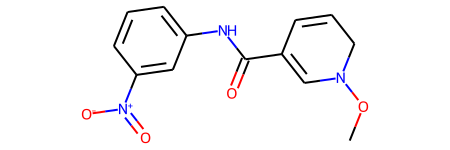

In [41]:
z = torch.randn(1, 56//2)
smiles = model.decode(z, z, False)
print('Random Smile: ', smiles)
Chem.MolFromSmiles(smiles)

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile2.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Ester:</strong> Evaluating generative models for small molecules presents unique challenges due to the complexity and diversity of chemical space. Some special problems that emerge include:

<ol>
    <li>Chemical validity: Ensuring that generated molecules adhere to the rules of chemistry is crucial. This includes checking for correct valency, bond types, and absence of impossible chemical structures.</li>
    <li>Drug-likeness: Generated molecules should possess properties that make them suitable candidates for drug development, such as favorable pharmacokinetics and absence of toxic functional groups.</li>
    <li>Diversity and novelty: It's important for generative models to produce diverse and novel molecules, rather than generating duplicates or minor variations of existing compounds.</li>
    <li>Property optimization: If the generative model is aimed at optimizing specific properties (e.g., potency, solubility), evaluating how well it achieves this goal is essential.</li>
    <li>Data efficiency: Generative models for small molecules should be able to generate meaningful molecules even when trained on limited data, as chemical datasets are often smaller than those in other domains.</li>
</ol>
</p>
    </div>
</div>

---

# REINVENT

Code repo: https://github.com/MarcusOlivecrona/REINVENT ([Paper](https://arxiv.org/pdf/1704.07555.pdf))

**TL;DR**

The REINVENT model is a recurrent neural network that generates SMILES strings. The model is trained in two steps. The first step is the training of a prior network that learns to generate molecules that are similar to the compounds in the ChEMBL dataset. The next step is the optimization of molecular properties using reinforcement learning.

**Exercise:** Use the REINVENT model to optimize LogP of the generated compounds. The expected result is a shift of LogP distribution in the generated sample.

In [54]:
# Code adapted from https://github.com/MarcusOlivecrona/REINVENT shared under the MIT license
# Small modifications made to make it compatible with the new PyTorch version

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import Variable


class MultiGRU(nn.Module):
    """ Implements a three layer GRU cell including an embedding layer
       and an output linear layer back to the size of the vocabulary"""
    def __init__(self, voc_size):
        super(MultiGRU, self).__init__()
        self.embedding = nn.Embedding(voc_size, 128)
        self.gru_1 = nn.GRUCell(128, 512)
        self.gru_2 = nn.GRUCell(512, 512)
        self.gru_3 = nn.GRUCell(512, 512)
        self.linear = nn.Linear(512, voc_size)

    def forward(self, x, h):
        x = self.embedding(x)
        h_out = Variable(torch.zeros(h.size()))
        x = h_out[0] = self.gru_1(x, h[0])
        x = h_out[1] = self.gru_2(x, h[1])
        x = h_out[2] = self.gru_3(x, h[2])
        x = self.linear(x)
        return x, h_out

    def init_h(self, batch_size):
        # Initial cell state is zero
        return Variable(torch.zeros(3, batch_size, 512))

class RNN():
    """Implements the Prior and Agent RNN. Needs a Vocabulary instance in
    order to determine size of the vocabulary and index of the END token"""
    def __init__(self, voc):
        self.rnn = MultiGRU(voc.vocab_size)
        if torch.cuda.is_available():
            self.rnn.cuda()
        self.voc = voc

    def likelihood(self, target):
        """
            Retrieves the likelihood of a given sequence

            Args:
                target: (batch_size * sequence_lenght) A batch of sequences

            Outputs:
                log_probs : (batch_size) Log likelihood for each example*
                entropy: (batch_size) The entropies for the sequences. Not
                                      currently used.
        """
        batch_size, seq_length = target.size()
        start_token = Variable(torch.zeros(batch_size, 1).long())
        start_token[:] = self.voc.vocab['GO']
        x = torch.cat((start_token, target[:, :-1]), 1)
        h = self.rnn.init_h(batch_size)

        log_probs = Variable(torch.zeros(batch_size))
        entropy = Variable(torch.zeros(batch_size))
        for step in range(seq_length):
            logits, h = self.rnn(x[:, step], h)
            log_prob = F.log_softmax(logits)
            prob = F.softmax(logits)
            log_probs += NLLLoss(log_prob, target[:, step])
            entropy += -torch.sum((log_prob * prob), 1)
        return log_probs, entropy

    def sample(self, batch_size, max_length=140):
        """
            Sample a batch of sequences

            Args:
                batch_size : Number of sequences to sample 
                max_length:  Maximum length of the sequences

            Outputs:
            seqs: (batch_size, seq_length) The sampled sequences.
            log_probs : (batch_size) Log likelihood for each sequence.
            entropy: (batch_size) The entropies for the sequences. Not
                                    currently used.
        """
        start_token = Variable(torch.zeros(batch_size).long())
        start_token[:] = self.voc.vocab['GO']
        h = self.rnn.init_h(batch_size)
        x = start_token

        sequences = []
        log_probs = Variable(torch.zeros(batch_size))
        finished = torch.zeros(batch_size).byte()
        entropy = Variable(torch.zeros(batch_size))
        if torch.cuda.is_available():
            finished = finished.cuda()

        for step in range(max_length):
            logits, h = self.rnn(x, h)
            prob = F.softmax(logits)
            log_prob = F.log_softmax(logits)
            x = torch.multinomial(prob, num_samples=1).view(-1)
            sequences.append(x.view(-1, 1))
            log_probs +=  NLLLoss(log_prob, x)
            entropy += -torch.sum((log_prob * prob), 1)

            x = Variable(x.data)
            EOS_sampled = (x == self.voc.vocab['EOS']).data
            finished = torch.ge(finished + EOS_sampled, 1)
            if torch.prod(finished) == 1: break

        sequences = torch.cat(sequences, 1)
        return sequences.data, log_probs, entropy

def NLLLoss(inputs, targets):
    """
        Custom Negative Log Likelihood loss that returns loss per example,
        rather than for the entire batch.

        Args:
            inputs : (batch_size, num_classes) *Log probabilities of each class*
            targets: (batch_size) *Target class index*

        Outputs:
            loss : (batch_size) *Loss for each example*
    """

    if torch.cuda.is_available():
        target_expanded = torch.zeros(inputs.size()).cuda()
    else:
        target_expanded = torch.zeros(inputs.size())

    target_expanded.scatter_(1, targets.contiguous().view(-1, 1).data, 1.0)
    loss = Variable(target_expanded) * inputs
    loss = torch.sum(loss, 1)
    return loss

In [55]:
import torch
import pickle
import numpy as np
import time
import os
from shutil import copyfile

from data_structs import Vocabulary, Experience
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP

In [56]:
def load_fixed_checkpoint(filename):
    if torch.cuda.is_available():
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)
    for i in [1, 2, 3]:
        for weight_name in ['ih', 'hh']:
            checkpoint[f'gru_{i}.bias_{weight_name}'] = checkpoint[f'gru_{i}.bias_{weight_name}'].flatten()
    return checkpoint

In [57]:
prior_checkpoint = load_fixed_checkpoint('Prior.ckpt')
agent_checkpoint = load_fixed_checkpoint('Prior.ckpt')
save_dir=None
learning_rate=0.0005
batch_size=64
n_steps=3000
num_processes=0
sigma=60
experience_replay=0

voc = Vocabulary(init_from_file="Voc")

start_time = time.time()

Prior = RNN(voc)
Agent = RNN(voc)

# By default restore Agent to same model as Prior, but can restore from already trained Agent too.
# Saved models are partially on the GPU, but if we dont have cuda enabled we can remap these
# to the CPU.
Prior.rnn.load_state_dict(prior_checkpoint)
Agent.rnn.load_state_dict(agent_checkpoint)

# We dont need gradients with respect to Prior
for param in Prior.rnn.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(Agent.rnn.parameters(), lr=0.0005)

# Scoring_function
class Singleprocessing():
    """Adds an option to not spawn new processes for the scoring functions, but rather
       run them in the main process."""
    def __init__(self, scoring_function=None):
        self.scoring_function = scoring_function
    def __call__(self, smiles):
        scores = [self.scoring_function(smile) for smile in smiles]
        return np.array(scores, dtype=np.float32)

def scoring_function(smiles):
    # model predykcyjny na to co ma byc generowane, np liczba benzenow jak w poprzednim przykładzie
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        score = MolLogP(mol)
    else:
        score = 0.0
        
    return score
        
        
scoring_function = Singleprocessing(scoring_function=scoring_function)

# For policy based RL, we normally train on-policy and correct for the fact that more likely actions
# occur more often (which means the agent can get biased towards them). Using experience replay is
# therefor not as theoretically sound as it is for value based RL, but it seems to work well.
experience = Experience(voc)

print("Model initialized, starting training...")
if not save_dir:
    save_dir = 'results/run_' + time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime())
os.makedirs(save_dir)

for step in range(n_steps):

    # Sample from Agent
    seqs, agent_likelihood, entropy = Agent.sample(batch_size)

    # Remove duplicates, ie only consider unique seqs
    unique_idxs = unique(seqs)
    seqs = seqs[unique_idxs]
    agent_likelihood = agent_likelihood[unique_idxs]
    entropy = entropy[unique_idxs]

    # Get prior likelihood and score
    prior_likelihood, _ = Prior.likelihood(Variable(seqs))
    smiles = seq_to_smiles(seqs, voc)
    score = scoring_function(smiles)

    # Calculate augmented likelihood
    augmented_likelihood = prior_likelihood + sigma * Variable(score)
    loss = torch.pow((augmented_likelihood - agent_likelihood), 2)

    # Experience Replay
    # First sample
    if experience_replay and len(experience)>4:
        exp_seqs, exp_score, exp_prior_likelihood = experience.sample(4)
        exp_agent_likelihood, exp_entropy = Agent.likelihood(exp_seqs.long())
        exp_augmented_likelihood = exp_prior_likelihood + sigma * exp_score
        exp_loss = torch.pow((Variable(exp_augmented_likelihood) - exp_agent_likelihood), 2)
        loss = torch.cat((loss, exp_loss), 0)
        agent_likelihood = torch.cat((agent_likelihood, exp_agent_likelihood), 0)

    # Then add new experience
    prior_likelihood = prior_likelihood.data.cpu().numpy()
    new_experience = zip(smiles, score, prior_likelihood)
    experience.add_experience(new_experience)

    # Calculate loss
    loss = loss.mean()

    # Add regularizer that penalizes high likelihood for the entire sequence
    loss_p = - (1 / agent_likelihood).mean()
    loss += 5 * 1e3 * loss_p

    # Calculate gradients and make an update to the network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Convert to numpy arrays so that we can print them
    augmented_likelihood = augmented_likelihood.data.cpu().numpy()
    agent_likelihood = agent_likelihood.data.cpu().numpy()

    # Print some information for this step
    time_elapsed = (time.time() - start_time) / 3600
    time_left = (time_elapsed * ((n_steps - step) / (step + 1)))
    print("\n       Step {}   Fraction valid SMILES: {:4.1f}  Time elapsed: {:.2f}h Time left: {:.2f}h".format(
          step, fraction_valid_smiles(smiles) * 100, time_elapsed, time_left))
    print("  Agent    Prior   Target   Score             SMILES")
    for i in range(10):
        print(" {:6.2f}   {:6.2f}  {:6.2f}  {:6.2f}     {}".format(agent_likelihood[i],
                                                                   prior_likelihood[i],
                                                                   augmented_likelihood[i],
                                                                   score[i],
                                                                   smiles[i]))

    experience.print_memory(os.path.join(save_dir, "memory"))
    torch.save(Agent.rnn.state_dict(), os.path.join(save_dir, 'Agent.ckpt'))

Model initialized, starting training...


/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)
/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)
/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
[09:12:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4


       Step 0   Fraction valid SMILES: 95.3  Time elapsed: 0.00h Time left: 0.70h
  Agent    Prior   Target   Score             SMILES
 -28.97   -28.97  212.68    4.03     COc1c(F)ccc2c(Nc3cccnc3)oc(C)c12
 -17.07   -17.07  116.62    2.23     CCOc1ccc2[nH]c3c(c2c1)CCNC3CC(=O)O
 -34.19   -34.19  156.52    3.18     CCOc1ccc(S(=O)(=O)N2CCN(C)CC2)cc1-c1nc(C2CCCO2)c(C(=O)NCC2CCC(F)(F)CC2)c(=O)[nH]1
 -18.77   -18.77  123.94    2.38     CC(C)c1nnc(NC(=O)c2ccc(C#N)o2)s1
 -21.82   -21.82  135.38    2.62     CCN(CC)C(=O)CN(c1ccc2c(c1)OCO2)S(=O)(=O)Cc1ccccc1
 -20.62   -20.62  253.82    4.57     C=C(c1ccc(C(F)(F)F)cc1)n1cnc2ccccc21
 -22.60   -22.60  191.03    3.56     CCn1c2cc(Cl)ccc2c2c(=O)[nH]c(=O)n(CCc3ccccc3)c21
 -24.12   -24.12  204.34    3.81     COC(=O)c1ccc(N2CCN(C(=O)Cc3c(C)[nH]c4ccccc34)CC2)c(Cl)c1
 -23.77   -23.77  144.76    2.81     CN(C)CCCN(Cc1ccc2nc(O)cc(O)c2c1)c1ccc(C(=O)NCCC(=O)O)cc1
 -20.08   -20.08  260.01    4.67     Cc1cc(NC(=O)CCl)sc1-c1nnc(SCC(=O)Nc2ccc(Cl)cc2)o1

**********

[09:12:01] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[09:12:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10 25



Best score in memory: 8.21


[09:12:02] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[09:12:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10 25



       Step 1   Fraction valid SMILES: 96.9  Time elapsed: 0.00h Time left: 1.05h
  Agent    Prior   Target   Score             SMILES
 -18.59   -18.12  166.12    3.07     COc1cc2c(cc1OC)C1CC3(CCN1CC3)CCN2C
 -23.13   -22.96  155.59    2.98     CCNc1c(C=NOC)c(C#N)c(-c2ccccc2)n1C
 -16.07   -17.43  113.55    2.18     O=C(c1ccco1)N1CC(Oc2ccccc2)C1
 -25.73   -27.12  276.76    5.06     Nc1ccc(-c2ccc3[nH]c(-c4ccc5[nH]c(=O)ccc5c4F)cc3c2)cc1
 -15.70   -15.84  128.01    2.40     CCOC(=O)c1ccccc1NC(=O)Cn1cnc2c(cnn2-c2ccccc2)c1=O
 -34.61   -34.81  -34.81    0.00     COC(=O)c1ccc2c(c1)C1(CCc3cnc4ccccc34)C(c3ccccc3F)CC1N2
 -19.33   -20.08  245.13    4.42     Cc1ccc(C(=O)C(C)Sc2ccccc2)s1
 -33.39   -33.34  379.09    6.87     Cc1c(-c2ccc(-c3ccccc3)cc2)nc2ccccc2c1C(=O)N1CCN(C(=O)N(C(C)C)C(C)C)CC1
 -22.76   -22.56  172.05    3.24     Nc1ccc(Cc2ccc(Cn3ccnc3)cc2F)cc1
 -14.28   -13.62  -70.22   -0.94     CC1(C)N=C(N)N=C(N)N1O

********************************************************************************

[09:12:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 8 9 20
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 20 21 22
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 12 15
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 9 10 14 22 23 24 25 26 27
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 13 14 15 17 18



Best score in memory: 9.03


[09:12:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 8 9 20
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 20 21 22
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 12 15
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 9 10 14 22 23 24 25 26 27
[09:12:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 13 14 15 17 18



       Step 2   Fraction valid SMILES: 92.2  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -17.26   -17.07  261.11    4.64     CCN(CC)C(=O)c1ccc(C23CC4CC(CC(C4)C2)C3)cc1
 -16.70   -17.66  147.71    2.76     Cc1[nH]c2ccccc2c1CCC(C)N
 -27.00   -26.62  -26.62    0.00     COc1nc2[nH]c(S)nc(NCCCN3CCOCC3)c2c(=O)o1
 -18.66   -20.16  219.62    4.00     CC(O)(c1ccc(Cl)cc1)c1ccc(-c2ccnn2C)cc1
 -22.16   -21.58  -80.69   -0.99     CCN(CC)CC1C(O)OC(CO)C1O
 -52.34   -53.31  308.30    6.03     CC(C)(CCSC1=C2CCC3CC(C=CC(O)Cc4ccccc4)CC3(C)C2=O)CC1=CC(=O)OCCO[N+](=O)[O-]
 -19.81   -20.32  152.00    2.87     COC(=O)c1ccccc1CNc1ccc(C(=O)OC)cc1
 -24.22   -25.51  268.19    4.90     Cc1ccsc1CN(Cc1ccc(N(C)C)cc1)Cc1cc2cc3c(cc2[nH]c1=O)OCO3
 -27.69   -29.65  149.53    2.99     Cc1ccnc(C2(O)CCC(N3CCc4cc(S(C)(=O)=O)ccc43)CC2)c1
 -25.60   -26.89  -26.89    0.00     COc1ccc(C2CCc3ccc(OC)c(OC)c3C2)c2c(c1O)C(=O)CC(c1ccc(O)cc1)O2

******************************************

[09:12:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 19
[09:12:04] SMILES Parse Error: extra close parentheses while parsing: COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12
[09:12:04] SMILES Parse Error: Failed parsing SMILES 'COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12' for input: 'COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12'
[09:12:04] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1
[09:12:04] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1' for input: 'CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1'



Best score in memory: 11.30


[09:12:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 19
[09:12:04] SMILES Parse Error: extra close parentheses while parsing: COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12
[09:12:04] SMILES Parse Error: Failed parsing SMILES 'COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12' for input: 'COC(=O)c1cc2c3cc(Cl)ccc3n3nnnc32)c2ccccc12'
[09:12:04] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1
[09:12:04] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1' for input: 'CC(C)c1c(C(=O)NC2CCN(Cc3ccc4ccc(C(=O)O)cc4c3Br)CC2)c2cccc(C(=O)O)c2)cc1C1(F)CCN1'



       Step 3   Fraction valid SMILES: 95.3  Time elapsed: 0.00h Time left: 0.93h
  Agent    Prior   Target   Score             SMILES
 -30.29   -33.24  142.35    2.93     CCSc1ccc2c(c1)nc(CCn1c(=O)n(C)c(=O)n(CC(O)c3ccccc3Cl)c1=O)C2
 -26.44   -42.77  377.45    7.00     CSc1cccc(C(OC2CC(C)(OCc3ccccc3)C2COC(=O)c2ccccc2)C(=O)NCc2ccccc2)c1
 -24.80   -26.25  248.24    4.57     CN(C)c1ccc(C(=O)CCCOc2ccc3cc(CC(=O)O)ccc3c2)cc1
 -16.64   -15.83  -231.09   -3.59     COc1cc(OC2OC(COC3OC(CO)C(O)C(O)C3O)C(O)C(O)C2O)cc(OC)c1O
 -20.00   -21.05  238.08    4.32     O=C(CC(CC(=O)c1ccccc1)c1ccccc1)C(=O)NCc1ccccc1
 -22.95   -26.00  374.59    6.68     CN(C)c1ccc(-c2ccc3cc(NC(=O)c4cccc5ccccc45)ccc3c2)c(C(=O)O)c1
 -17.55   -21.12  215.25    3.94     Cc1ccc(-c2ccc(-c3ccccc3)cc2)cc1S(=O)(=O)NCCN1CCOCC1
 -21.80   -24.48  236.82    4.36     Nc1cc(Cl)cc(-c2ccc(-c3cccc(C(N)=O)c3)cc2)c1
 -38.94   -41.77  636.01   11.30     OC(CN(Cc1cccc(Oc2ccccc2)c1)c1ccc(OCc2ccc3ccccc3n2)c(F)c1)Cc1c(-c2ccc(Cl)c(F)c2)[nH]c2ccccc12

[09:12:04] Can't kekulize mol.  Unkekulized atoms: 2 17 18 20 21
[09:12:04] SMILES Parse Error: unclosed ring for input: 'Cc1c(Cc2ccccc2)c2cc3c(cc2oc1=O)OC2=Cc1cc2c(cc1C3=O)OCO2'
[09:12:05] SMILES Parse Error: extra close parentheses while parsing: COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1
[09:12:05] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1' for input: 'COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1'



Best score in memory: 11.30


[09:12:05] Can't kekulize mol.  Unkekulized atoms: 2 17 18 20 21
[09:12:05] SMILES Parse Error: unclosed ring for input: 'Cc1c(Cc2ccccc2)c2cc3c(cc2oc1=O)OC2=Cc1cc2c(cc1C3=O)OCO2'
[09:12:05] SMILES Parse Error: extra close parentheses while parsing: COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1
[09:12:05] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1' for input: 'COc1ccccc1N1CCN(C2CCCN(C(=O)Oc3ccc(CC(C)C)cc3)C2)CC2CC2)CC1'



       Step 4   Fraction valid SMILES: 95.3  Time elapsed: 0.00h Time left: 0.89h
  Agent    Prior   Target   Score             SMILES
 -15.24   -15.87  142.83    2.64     CN(C)CCNC(=O)c1ccc(-c2ccccc2)cc1
 -23.27   -22.43  241.59    4.40     CC(C)(CNC1(c2ccc(Cl)cc2)c2ccccc2S(=O)(=O)N1)c1ccccc1
 -16.94   -16.26   73.62    1.50     Cc1cc2ccccc2n1CCNCCN
 -16.03   -17.76  274.45    4.87     O=C(CN1CCCc2ccccc21)Nc1ccc(Oc2ccccc2)cc1
 -14.05   -15.00  103.23    1.97     Sc1nnc(CNc2ccccc2)o1
 -15.84   -18.46  209.11    3.79     CC(C)(C)CC(Cl)(Cl)Cl
 -22.27   -23.76  314.28    5.63     CCCOc1ccc(-c2csc3c2-n2cccc2C3(C)C)cc1
 -16.90   -17.48  219.39    3.95     NC(=NOC(=O)c1ccccc1)C(c1ccccc1)c1ccccc1
 -33.96   -36.70  152.01    3.15     CC(C)Nc1c(C(C)(C)C#N)c(N)c(C#N)c2cc(S(=O)(=O)NCCCN(C)C)ccc12
 -22.59   -23.89  425.51    7.49     CC(C)c1ccc(NC2=C(C(C)(C)C)SC(=Cc3ccc(Cl)cc3)C2=O)cc1

********************************************************************************

         Best recorded SMILES

[09:12:06] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 11 21 22
[09:12:06] SMILES Parse Error: extra close parentheses while parsing: CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1
[09:12:06] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1' for input: 'CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1'
[09:12:06] SMILES Parse Error: extra close parentheses while parsing: C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O
[09:12:06] SMILES Parse Error: Failed parsing SMILES 'C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O' for input: 'C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O'
[09:12:06] SMILES Parse Error: extra close parentheses while parsing: CC(=O)NC(c1ccccc1)c1cc2c(s1)CCN(C(=O)c1ccsc1)C2)C(C(=O)OCC)c1ccc(F)cc1
[09:12:06] SMILES Parse Error: Failed pars


Best score in memory: 11.30


[09:12:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 11 21 22
[09:12:07] SMILES Parse Error: extra close parentheses while parsing: CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1
[09:12:07] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1' for input: 'CN1C(=O)N(C)C2(CCN(CC(O)COc3ccccc3)CC2)c2ccccc21)C(=O)c1ccccc1'
[09:12:07] SMILES Parse Error: extra close parentheses while parsing: C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O
[09:12:07] SMILES Parse Error: Failed parsing SMILES 'C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O' for input: 'C=C(c1ccc(-c2ccccc2)cc1)C1CCC2(CO)CCC3(C)C(CCC4C5(C)CCC(OC(C)=O)C(C)(C)C5CCC43C)C2C1)C(=O)O'
[09:12:07] SMILES Parse Error: extra close parentheses while parsing: CC(=O)NC(c1ccccc1)c1cc2c(s1)CCN(C(=O)c1ccsc1)C2)C(C(=O)OCC)c1ccc(F)cc1
[09:12:07] SMILES Parse Error: Failed pars


       Step 5   Fraction valid SMILES: 90.6  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -17.52   -19.74  172.50    3.20     Cc1ccc(OCCC(=O)OCC(=O)c2ccc(O)cc2)cc1C
 -25.12   -28.28  202.73    3.85     Cc1ccc(C(=O)NC2(C(F)(F)F)N=C(SCc3ccccc3F)NC2=O)cc1C
 -22.92   -26.05  383.80    6.83     CCc1ccccc1-c1c(C(=O)N2CCN(c3ccc(OC)cc3)CC2)c2ccccc2n1-c1ccccc1
 -27.90   -36.47  368.95    6.76     CCCc1cccc2[nH]c(-c3n[nH]c4cc(NCc5ccc6ccccc6c5)[nH]c34)cc12
 -16.78   -16.71  260.36    4.62     Cc1cccc(NC(=O)c2ccc(-c3ccccc3)nc2)c1C
 -18.26   -20.42  236.99    4.29     CCCc1cccc(-c2cc(C(=O)Nc3cccc(OC)c3)[nH]n2)c1
 -18.88   -18.74  230.04    4.15     O=c1ccc2ccc(Cc3ccc(Br)cc3)cc2o1
 -19.89   -21.07  288.16    5.15     OC(c1ccccc1)(c1ccc(Cl)cc1Cl)c1nc2ccccc2[nH]1
 -20.00   -18.94  312.52    5.52     O=C(COc1ccccc1-c1cccc2ccccc12)Nc1ccccc1
 -30.29   -38.31  262.00    5.01     CCCc1cc(C(=O)OC(C)C(O)(C(C)C)c2ccc3c(c2)OCO3)c2ccccc2n1

************************

[09:12:07] Can't kekulize mol.  Unkekulized atoms: 6 7 8 24 25 26 27 28 29 42 43 44 45 46 47
[09:12:07] SMILES Parse Error: extra close parentheses while parsing: C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O
[09:12:07] SMILES Parse Error: Failed parsing SMILES 'C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O' for input: 'C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O'
[09:12:07] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32
[09:12:07] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32' for input: 'COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32'
[09:12:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 16 17 18 19 20 31 32 33 35
[09:12:07] SMILES Parse Error: extra cl


Best score in memory: 11.30


[09:12:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 24 25 26 27 28 29 42 43 44 45 46 47
[09:12:08] SMILES Parse Error: extra close parentheses while parsing: C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O
[09:12:08] SMILES Parse Error: Failed parsing SMILES 'C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O' for input: 'C=C(CCC(O)C(C)(C)OC1OC(O)(C(=O)O)C(O)C(O)C1O)C1C(C)(O)CCC(O)C1(C)C)C(O)C(O)C(C)(C)OC1OC(CO)C(O)C(O)C1OC(C)=O'
[09:12:08] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32
[09:12:08] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32' for input: 'COc1cc(-c2ccc3c(c2)C2(COC(N)=O)COC3)C2(C)C)c2cccc3cccc1c32'
[09:12:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 16 17 18 19 20 31 32 33 35
[09:12:08] SMILES Parse Error: extra cl


       Step 6   Fraction valid SMILES: 79.7  Time elapsed: 0.00h Time left: 0.97h
  Agent    Prior   Target   Score             SMILES
 -28.69   -50.97  -50.97    0.00     COc1ccc(-c2cc(C(=O)NC3CC(C)(C)Oc4ncccc43)c3ccccc3N(CC(=O)Nc3ccccc3Cl)c3ccccc32)cc1
 -52.00   -67.83  421.76    8.16     Cc1ccc(C(=O)c2ccc(-c3ccccc3S(=O)(=O)c3c(C)[nH]c(C=Cc4ccc(N)cc4)c3)cc2C(C)(C)C)cc1CN1CCN(C)CC1
 -35.35   -39.42  189.80    3.82     COC(=O)CN1C(=O)C2C(C=Cc3ccccc3)OC(=O)C3C(C(=O)OC(c4ccccc4)c4ccccc4)C2C13
 -28.17   -34.14  248.90    4.72     CC(C)(C)c1cc(C(=O)c2c(-c3ccccc3)[nH]c3ccc(C(C)(C)C(O)CO)cc23)[nH]n1
 -28.02   -33.62  243.58    4.62     Cc1[nH]c2ccccc2c1C(=O)C(OC(=O)CC(=O)c1ccc(S(C)(=O)=O)cc1)c1ccccc1
 -15.00   -16.42   30.98    0.79     COC(=O)C(Cc1c[nH]cn1)N1C(=O)c2ccccc2C1=O
 -29.74   -37.61  504.82    9.04     CC(C)c1c(CCC(O)C(C)(C)c2ccc(-c3ccccc3)cc2)cc(C(C)(C)C)c2c(=O)c3ccccc3[nH]c12
 -27.96   -31.52  269.51    5.02     COc1ccc2cc(-c3c(C#N)c(N)nc4c3C(C)(C)CC(F)(F)O4)ccc2c1
 -22.55   -2

[09:12:08] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1
[09:12:08] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1' for input: 'O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1'
[09:12:08] SMILES Parse Error: extra close parentheses while parsing: CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1
[09:12:08] SMILES Parse Error: Failed parsing SMILES 'CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1' for input: 'CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1'
[09:12:08] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc2c(c1)C(c1ccc3c(c1)OCO3)C(C#N)(C(=O)NC(C)(C)C)C(C)(C)O2)c1c(N)[nH]c(C(=O)CCc2ccccc2)c1-c1ccc(Cl)cc1
[09:12:08] SMILES Parse Erro


Best score in memory: 11.30


[09:12:09] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1
[09:12:09] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1' for input: 'O=C(Nc1ccc(C2(C(F)(F)F)NCCOc3ccccc3)cc2C(F)(F)F)cc1)C1CCN(Cc2ccccc2F)CC1'
[09:12:09] SMILES Parse Error: extra close parentheses while parsing: CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1
[09:12:09] SMILES Parse Error: Failed parsing SMILES 'CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1' for input: 'CC(C)C(=O)Nc1ccc(C(O)CNC(Cc2ccccc2)C(O)CNC(Cc2ccccc2)C(O)CNC2CC2)c(C(=O)NCc2ccccc2)c2CC(C)(C)C)c1'
[09:12:09] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc2c(c1)C(c1ccc3c(c1)OCO3)C(C#N)(C(=O)NC(C)(C)C)C(C)(C)O2)c1c(N)[nH]c(C(=O)CCc2ccccc2)c1-c1ccc(Cl)cc1
[09:12:09] SMILES Parse Erro


       Step 7   Fraction valid SMILES: 87.5  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -18.15   -19.95  297.69    5.29     Cc1ccc(CN(C)Cc2ccc(-c3ccccc3)cc2)cc1
 -27.46   -35.82  483.07    8.65     COc1ccc(-c2cc(C(F)(F)F)c3cc(NC(=O)c4ccc(OC5CCN(C)CC5)cc4)sc3c2C)cc1C(F)(F)F
 -32.19   -34.83  412.92    7.46     Nc1ccccc1C(=O)C(C(=O)c1c(C(F)(F)F)cccc1C(F)(F)F)c1c(Cl)cccc1Cl
 -22.89   -22.94  250.01    4.55     COc1ccccc1C(=O)CCC(=O)Nc1cccc(NC(=O)c2ccccc2)c1
 -18.87   -24.83  229.57    4.24     c1c[nH]c2cc(Cc3c[nH]c4ccccc34)ccc12
 -21.01   -27.98  326.47    5.91     NC(=NCc1ccccc1)c1cc(-c2ccc(Cl)cc2)[nH]c1-c1ccccc1
 -23.38   -30.33  388.33    6.98     CCC(C)(C)C(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)NC(CCN1C(=O)c2cc3ccccc3cc2C1=O)C(C)(C)C
 -21.24   -36.07  404.76    7.35     CC(C)CC(NC(=O)c1cc(-c2ccccc2)[nH]c1-c1cc2ccccc2[nH]1)c1ccccc1
 -27.48   -43.50  465.33    8.48     CCN(Cc1ccccc1)C(=O)c1c(Cn2c(C)cc3ccccc23)cc(-c2ccccc2)c2ccccc12
 -20.19   -17.

[09:12:09] SMILES Parse Error: extra close parentheses while parsing: CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2
[09:12:09] SMILES Parse Error: Failed parsing SMILES 'CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2' for input: 'CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2'
[09:12:09] SMILES Parse Error: extra close parentheses while parsing: COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1
[09:12:09] SMILES Parse Error: Failed parsing SMILES 'COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1' for input: 'COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1'
[09:12:09] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(NC(CC(=O)c2cc3ccccc3o2)c2ccc3c(c2)OCO3)c2cc(C(F)(F)F)ccc2N(C)C)c(OCC(O)C(F)(F)F)c1
[09:12:09] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(NC(CC(=O)c2cc3ccccc3o2)c2ccc3c(c


Best score in memory: 11.30


[09:12:10] SMILES Parse Error: extra close parentheses while parsing: CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2
[09:12:10] SMILES Parse Error: Failed parsing SMILES 'CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2' for input: 'CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2'
[09:12:10] SMILES Parse Error: extra close parentheses while parsing: COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1
[09:12:10] SMILES Parse Error: Failed parsing SMILES 'COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1' for input: 'COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccccc2)cc(C(C)(C)C)c1'
[09:12:10] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(NC(CC(=O)c2cc3ccccc3o2)c2ccc3c(c2)OCO3)c2cc(C(F)(F)F)ccc2N(C)C)c(OCC(O)C(F)(F)F)c1
[09:12:10] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(NC(CC(=O)c2cc3ccccc3o2)c2ccc3c(c


       Step 8   Fraction valid SMILES: 89.1  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -29.42   -35.85  297.39    5.55     CNC(=O)CNc1ccc(Cc2c(-c3ccccc3C)[nH]c3ccc(Cl)cc23)c(OC)c1
 -30.91   -38.26  -38.26    0.00     CN(c1ccccc1)c1ccc2c(Nc3ccc(C(=O)O)cc3)c3c(cccc3c1)[N+](=O)[O-])c1ccccc1-2
 -32.20   -47.53  343.51    6.52     C=CC(O)C(OCc1ccccc1)c1c(OC)cc(OC)c2c(CC(OC(C)=O)c3ccccc3)cc(OC)cc12
 -27.47   -31.40  247.79    4.65     COc1cccc(-c2[nH]c(Cc3ccccc3)cc2CCOc2ccc(CC3NC(=O)NC3=O)cc2)c1
 -19.35   -24.47  340.39    6.08     Cc1ccc(NCc2cc3ccccc3nc2Cl)cc1C(=O)N(C)Cc1ccccc1
 -17.83   -18.25  102.04    2.00     Cn1ccccc1=NCCOc1ccccc1
 -32.82   -39.02  524.61    9.39     O=[N+]([O-])c1ccc(-c2[nH]c3ccc(Br)cc3c2-c2cccc(S(=O)(=O)NC(c3ccccc3)c3ccccc3)c2)c2ccccc12
 -20.72   -22.78  282.18    5.08     [O-][N+](=Cc1cc(Br)ccc1O)c1ccc(-c2ccccc2)cc1
 -42.88   -82.85  -82.85    0.00     COCCCc1cc(CN(C(=O)C2CNCC(C3(CC)OC(C)(C)CO3)C(C)=O)C2CC2CC2)c2ccc

[09:12:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 10 11 12 24 25 26 27 29 30
[09:12:11] SMILES Parse Error: extra close parentheses while parsing: CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21
[09:12:11] SMILES Parse Error: Failed parsing SMILES 'CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21' for input: 'CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21'
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 12
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 26
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 27 28 29 30 31 32 35 36 37 38 39 40
[09:12:11] Explicit valence for atom # 35 C, 5, is greater than permitted
[09:12:11] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1CN(C)C(=O)CN(Cc1ccccc1)c1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)C(C)c1ccc2c(c1)OCO2
[09:12:11] S


Best score in memory: 11.30


[09:12:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 10 11 12 24 25 26 27 29 30
[09:12:11] SMILES Parse Error: extra close parentheses while parsing: CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21
[09:12:11] SMILES Parse Error: Failed parsing SMILES 'CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21' for input: 'CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21'
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 12
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 26
[09:12:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 27 28 29 30 31 32 35 36 37 38 39 40
[09:12:11] Explicit valence for atom # 35 C, 5, is greater than permitted
[09:12:11] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1CN(C)C(=O)CN(Cc1ccccc1)c1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)C(C)c1ccc2c(c1)OCO2
[09:12:11] S


       Step 9   Fraction valid SMILES: 84.4  Time elapsed: 0.00h Time left: 0.95h
  Agent    Prior   Target   Score             SMILES
 -34.73   -60.13  518.34    9.64     Cc1ccc(-c2c(C(F)(F)F)oc3ccc(S(=O)(=O)c4ccccc4F)cc23)cc1C(=O)N1CCC2(CC(=O)N(c3ccccc3)c3ccccc32)CC1
 -29.31   -46.99  587.65   10.58     Cc1ccc(-c2ccccc2Oc2ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc2C(=O)N(C)c2ccc(-c3ccccc3[N+](=O)[O-])cc2)cc1
 -33.09   -33.69  289.20    5.38     CCC(C)(C)OC(=O)N1CCc2sc(C(=O)OCC(F)(F)F)c(C(=O)c3ccccc3)c2C1
 -23.85   -36.44  -36.44    0.00     COc1ccc2c(c1)C(=O)c1c-2c(C(O)CC(O)CC(=O)OCC)c2ccc(Cl)cc12
 -31.71   -45.90  569.64   10.26     O=C(c1cc(-c2ccccc2)oc1-c1cc2ccccc2[nH]1)N1CC(Cc2ccccc2)CC1c1ccc(OCc2ccc(F)cc2)cc1
 -24.72   -29.50  126.60    2.60     CCOC(c1ccc(Cl)cc1)C(C(C)(C)O)S(C)(=O)=O
 -39.97   -68.10  -68.10    0.00     CC1(C)Cc2c(Cl)cc(OCc3ccccc3)cc2C(=S)N(Cc2ccccc2)Cc2ccccc2)c2cc(C(=O)c3ccccc3)ccc21
 -24.65   -24.01  284.94    5.15     O=C(O)C(Cc1ccccc1)Nc1nc2c(Cl)cccc2c2ccccc12
 -26.1

[09:12:12] SMILES Parse Error: extra close parentheses while parsing: CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC
[09:12:12] SMILES Parse Error: Failed parsing SMILES 'CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC' for input: 'CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC'
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19 20 21 22 23
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 29 30
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
[09:12:12] SMILES Parse Error: unclosed ring for input: 'CC(C)(C(=O)Nc1ccc(-c2ccc(C3(C(F)(F)F)N4CCC4CCC3C4(C)C)cc2C(F)(F)F)cc1-c1ccc2cc(CN3CC(O)C3)ccc2n1)c1ccc(-c2ccccc2)cc1C(F)(F)F'
[09:12:12] SMILES Parse Error: extra close parentheses while parsing: CC(C)CC(CSc1cc2ccccc2c2ccccc12)(CC(=O)OCC(C)(C)C)c1cccc(F)c1)C(=O)NCc1ccccc1
[09:12:12] SMILES Parse Error: Failed parsing SMILES 'CC(C)CC(CSc1cc2ccccc2c2ccccc12)(CC(=O)OCC(C)(C)C)c1cc


Best score in memory: 14.17


[09:12:12] SMILES Parse Error: extra close parentheses while parsing: CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC
[09:12:12] SMILES Parse Error: Failed parsing SMILES 'CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC' for input: 'CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC'
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19 20 21 22 23
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 29 30
[09:12:12] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
[09:12:12] SMILES Parse Error: unclosed ring for input: 'CC(C)(C(=O)Nc1ccc(-c2ccc(C3(C(F)(F)F)N4CCC4CCC3C4(C)C)cc2C(F)(F)F)cc1-c1ccc2cc(CN3CC(O)C3)ccc2n1)c1ccc(-c2ccccc2)cc1C(F)(F)F'
[09:12:12] SMILES Parse Error: extra close parentheses while parsing: CC(C)CC(CSc1cc2ccccc2c2ccccc12)(CC(=O)OCC(C)(C)C)c1cccc(F)c1)C(=O)NCc1ccccc1
[09:12:12] SMILES Parse Error: Failed parsing SMILES 'CC(C)CC(CSc1cc2ccccc2c2ccccc12)(CC(=O)OCC(C)(C)C)c1cc


       Step 10   Fraction valid SMILES: 79.7  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -35.68   -51.70  557.39   10.15     Cc1cc(C(F)(C(F)(F)F)C(F)(F)F)cc2c(-c3ccc(C(F)(F)F)cc3)cc(N)c(C(C)CCC(F)(F)F)c12
 -23.68   -32.87  361.08    6.57     COc1ccc(C2OC(c3ccc(OCc4ccccc4)cc3)=NO2)cc1C(=O)c1ccccc1Cl
 -20.07   -29.81  465.05    8.25     CC(C)(Oc1ccc(-c2cccc(-c3cc4ccccc4s3)c2)cc1C(=O)O)c1ccccc1
 -17.42   -17.79  138.49    2.60     Cc1csc2cccnc12
 -16.50   -24.68  462.60    8.12     Cc1cccc(C(OCc2ccccc2-c2ccccc2)c2cccc3ccccc23)c1
 -31.34   -34.32  281.63    5.27     N#Cc1cccc(-c2ccc(C3=CC(c4ccc(O)cc4Cl)OC3=O)cc2)c1
 -24.71   -40.99  487.80    8.81     CN(c1ccc2[nH]c(-c3ccccc3)cc2c1)c1ccc(-c2cnc3[nH]ccc3c2)c(-c2ccccc2)c1
 -23.79   -34.32  380.18    6.91     CC(CF)(CF)n1cc(C2(c3ccccc3)CC2c2cccc(F)c2)c2ccccc21
 -32.19   -47.18  -47.18    0.00     CCc1nc(-c2ccccc2)c2c(C(C)(C)C)nc3cc(-c4c(C)cccc4C)[nH]c32)c1CC
 -23.14   -37.59  400.15    7.30    

[09:12:13] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C
[09:12:13] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C' for input: 'CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C'
[09:12:13] SMILES Parse Error: extra close parentheses while parsing: O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1
[09:12:13] SMILES Parse Error: Failed parsing SMILES 'O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1' for input: 'O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1'
[09:12:13] SMILES Parse Error: extra close parentheses while parsing: CC(C(=O)Nc1ccc2ccccc2c1)c1c(O)c2ccccc2nc2ccc(Nc3ccccc3C(N)=O)cc1OCC(C)C)c1ccccc1-2
[09:12:13] SMILES Parse E


Best score in memory: 14.17


[09:12:14] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C
[09:12:14] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C' for input: 'CC(C)c1ccc(C(c2sc3nc(C(C)(C)C)[nH]c(=O)c3c2O)C2CC2)c2ccccc2C(F)(F)F)cc1C(C)(C)C'
[09:12:14] SMILES Parse Error: extra close parentheses while parsing: O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1
[09:12:14] SMILES Parse Error: Failed parsing SMILES 'O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1' for input: 'O=C(c1cccc(-c2ccccc2)c1)c1cc2cc(CBr)cc(C(CC(=O)O)c3ccccc3)c2cc1OS(=O)(=O)C(F)(F)F)c1cccc(Oc2ccccc2)c1'
[09:12:14] SMILES Parse Error: extra close parentheses while parsing: CC(C(=O)Nc1ccc2ccccc2c1)c1c(O)c2ccccc2nc2ccc(Nc3ccccc3C(N)=O)cc1OCC(C)C)c1ccccc1-2
[09:12:14] SMILES Parse E


       Step 11   Fraction valid SMILES: 79.7  Time elapsed: 0.00h Time left: 0.96h
  Agent    Prior   Target   Score             SMILES
 -23.63   -33.41  491.47    8.75     CC(C)(C)c1ccc(C(=O)N2CCN(c3ccc(OCc4ccccc4)cc3)C(Cc3ccccc3)C2Cc2ccccc2)cc1
 -24.56   -29.13  342.90    6.20     CCCN(CCc1c(-c2ccccc2Cl)[nH]c2ccccc12)CC(O)(Cn1cncn1)c1ccc(F)cc1F
 -24.64   -40.37  271.10    5.19     CC(C(=O)Nc1ccccc1)c1c(CC2(C)CO2)c2ccc(OCc3ccccc3)cc2n(C)c1=O
 -30.77   -49.94  480.54    8.84     CCc1ccc(Nc2cc(C)c3cc(C(=O)OC)ccc3n2)cc1C(=O)OC(C)c1c(-c2ccc(F)cc2)[nH]c2ccccc12
 -23.67   -37.87  532.55    9.51     Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C(C)(C)C)cc4)s3)cc2C(=O)NCCc2c[nH]c3ccccc23)cc1C(=O)O
 -26.21   -32.94  334.27    6.12     COc1cc(-c2cc3ccccc3s2)cc2cc(-c3ncccc3)[nH]c12
 -22.16   -27.98  198.23    3.77     CC(=O)c1cccc(-c2ccccc2NC(Cc2ccc(O)cc2)C(N)=O)c1
 -26.44   -41.16  376.59    6.96     Cc1ccc(CCC(C)(C)c2c(O)ccc3[nH]c(C(=O)O)cc23)c2ccc(C(F)(F)F)cc12
 -22.38   -31.62  386.79    6.97     CC(c1ccccc

[09:12:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 40
[09:12:14] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc2c(c1)C(Cc1ccc(CN3CC(COc4ccccc4)C(CO)N3C(C)(C)CO)c1OCc1ccccc1-2'
[09:12:14] SMILES Parse Error: unclosed ring for input: 'CC(C)C(NC(=O)c1cc(-c2cccc(-c3ccccc2)cc2F)c2ccc(-c3ccccc2F)cc1-c1c(Cl)cccc1Cl)c1ccccc1'
[09:12:14] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1
[09:12:14] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1' for input: 'Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1'
[09:12:14] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(C2(c3ccc(OC(F)F)cc3)c3ccccc3C(=NO)c3c[nH]ccc32)c2ccc(Cl)cc2Cc1ccc2ccccc12'
[09:12:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 25 26 27 28 29 30 31 32 33


Best score in memory: 14.17


[09:12:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 40
[09:12:15] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc2c(c1)C(Cc1ccc(CN3CC(COc4ccccc4)C(CO)N3C(C)(C)CO)c1OCc1ccccc1-2'
[09:12:15] SMILES Parse Error: unclosed ring for input: 'CC(C)C(NC(=O)c1cc(-c2cccc(-c3ccccc2)cc2F)c2ccc(-c3ccccc2F)cc1-c1c(Cl)cccc1Cl)c1ccccc1'
[09:12:15] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1
[09:12:15] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1' for input: 'Cc1ccc(-c2c(C(F)(F)F)cc(C(F)(F)F)c3c(-c4ccc5c(c4)OCO4)c(C(F)(F)F)cn2C3CC2)c2ccc(C(F)(F)F)cc2)c1'
[09:12:15] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(C2(c3ccc(OC(F)F)cc3)c3ccccc3C(=NO)c3c[nH]ccc32)c2ccc(Cl)cc2Cc1ccc2ccccc12'
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 25 26 27 28 29 30 31 32 33


       Step 12   Fraction valid SMILES: 81.2  Time elapsed: 0.00h Time left: 0.97h
  Agent    Prior   Target   Score             SMILES
 -39.19   -52.97  334.49    6.46     CC(C(=O)O)c1ccc2c(c1)Cc1c(-c3ccc(-c4ncccc4C(=O)O)cc3-c3ccccc1-3)NC2
 -10.64   -16.10  314.02    5.50     c1ccc2[nH]c(-c3cccc(-c4ccccc4)c3)cc2c1
 -53.68   -67.29  -67.29    0.00     Cc1cccc2c(C(OC(C)c3c(-c4ccccc4Cl)c4cc([N+](C)(C)C)c(O)cc4O)cc(F)c3O)[nH]c(=O)c1C2CC(F)(F)F
 -15.77   -19.60  300.46    5.33     CCCN(CCC)C(=O)Cc1c(-c2ccccc2)[nH]c2cc(C)ccc12
 -31.04   -33.20  394.60    7.13     CCC(CC(C)C)S(=O)(=O)Cc1ccccc1Nc1c(Cl)ccc(Cl)c1Cl
 -23.78   -27.41  130.12    2.63     Cc1cc(C)c2[nH]c(=O)[nH]c(=O)c2c1Oc1ccccc1
 -36.55   -52.80  -52.80    0.00     Cc1ccc2c(c1)C(Cc1ccc(CN3CC(COc4ccccc4)C(CO)N3C(C)(C)CO)c1OCc1ccccc1-2
 -41.55   -64.39  467.49    8.86     CCc1cccc(Oc2ccc(CN(C)c3cc(Cl)ccc3OCc3ccccc3)cc2F)c1CN(CC(=O)O)Cc1ccc2c(c1)OCO2
 -24.78   -70.18  -70.18    0.00     CC(C)C(NC(=O)c1cc(-c2cccc(-c3ccccc2)cc2F)c2ccc

[09:12:15] SMILES Parse Error: extra open parentheses for input: 'CC(COc1ccc(-c2c(-c3ccccc3)nc3ccccc2c3nc(-c2ccc(F)cc2)[nH]1'
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 8 9 32
[09:12:15] SMILES Parse Error: extra open parentheses for input: 'CC(C)c1cccc(-c2ccc(OCC3CN(C(=O)Cc4ccccc4)C3CCN(Cc3ccccc3)CC2)c1'
[09:12:15] SMILES Parse Error: extra open parentheses for input: 'O=[N+]([O-])c1cccc(-c2c(-c3ccccc3)c3cc(F)ccc2n3c[n+](Cc2c(F)cccc2F)c1-c1ccc2c(c1)OCc1ccccc1-2'
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 14 15
[09:12:15] SMILES Parse Error: unclosed ring for input: 'CC(C)c1ccccc1Nc1cc2c(cc1C(=O)O)OCC(F)(F)C(F)(F)F'
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 6 7 14 15 16 18 19 21 22
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 21
[09:12:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 24 25 26 27 28 38
[09:12:15] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(C(=NO)N2CCC2)c2c(OC)cc(-c3ccccc3)cc2-c2ccc(-c3cccc


Best score in memory: 14.79


[09:12:16] SMILES Parse Error: extra open parentheses for input: 'CC(COc1ccc(-c2c(-c3ccccc3)nc3ccccc2c3nc(-c2ccc(F)cc2)[nH]1'
[09:12:16] Can't kekulize mol.  Unkekulized atoms: 8 9 32
[09:12:16] SMILES Parse Error: extra open parentheses for input: 'CC(C)c1cccc(-c2ccc(OCC3CN(C(=O)Cc4ccccc4)C3CCN(Cc3ccccc3)CC2)c1'
[09:12:16] SMILES Parse Error: extra open parentheses for input: 'O=[N+]([O-])c1cccc(-c2c(-c3ccccc3)c3cc(F)ccc2n3c[n+](Cc2c(F)cccc2F)c1-c1ccc2c(c1)OCc1ccccc1-2'
[09:12:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 14 15
[09:12:16] SMILES Parse Error: unclosed ring for input: 'CC(C)c1ccccc1Nc1cc2c(cc1C(=O)O)OCC(F)(F)C(F)(F)F'
[09:12:16] Can't kekulize mol.  Unkekulized atoms: 6 7 14 15 16 18 19 21 22
[09:12:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 21
[09:12:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 24 25 26 27 28 38
[09:12:16] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(C(=NO)N2CCC2)c2c(OC)cc(-c3ccccc3)cc2-c2ccc(-c3cccc


       Step 13   Fraction valid SMILES: 78.1  Time elapsed: 0.00h Time left: 0.98h
  Agent    Prior   Target   Score             SMILES
 -19.01   -26.32  311.62    5.63     Nc1ccc(-c2cccc3ccccc23)cc1-c1[nH]nc2ccccc12
 -22.49   -28.32  449.40    7.96     CCOc1nc2ccccc2cc1C(c1ccccc1)c1c(-c2ccccc2)[nH]c2ccccc12
 -32.89   -45.02  -45.02    0.00     CC(COc1ccc(-c2c(-c3ccccc3)nc3ccccc2c3nc(-c2ccc(F)cc2)[nH]1
 -18.50   -33.70  390.02    7.06     CCc1cc(-c2ccccc2)cc[n+]1Cc1c(-c2ccc(Cl)cc2)[nH]c2ccc(OC)cc12
 -18.67   -24.63  251.13    4.60     CNC(C(=O)NC(C(=O)N(C)C(c1ccccc1)c1ccccc1)Cc1ccccc1)C(C)(C)C
 -20.77   -26.61  400.65    7.12     COc1cc2c(cc1OCc1ccccc1)CCN(c1ccc(C(O)(c3ccccc3)c3ccccc3)cc1)C2
 -29.41   -54.88  545.17   10.00     CCc1ccc(C(CC(C)(C)c2ccccc2)C(CCc2ccccc2)NS(=O)(=O)c2cccc(Cl)c2)cc1-c1ccccc1
 -16.13   -22.38  283.59    5.10     CCC(=O)c1ccccc1-c1cccc2ccccc12
 -28.97   -72.71  -72.71    0.00     Cc1ccccc1C(c1c(-c2c(ccc(C(=O)N(C)C)c2O)c2ccccc2C(=O)O)[nH]c1C(=O)N(C)Cc1c(F)cccc

[09:12:17] non-ring atom 25 marked aromatic
[09:12:17] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1
[09:12:17] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1' for input: 'COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1'
[09:12:17] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 17
[09:12:17] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(C(C)(C)C)cc3c2)c1
[09:12:17] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(C(C)(C)C)cc3c2)c1' for input: 'Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(


Best score in memory: 14.79


[09:12:18] non-ring atom 25 marked aromatic
[09:12:18] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1
[09:12:18] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1' for input: 'COc1ccc(-c2cc(-c3cc(-c4ccc(C)cc4)cc(C(F)(F)F)c3C#N)sc2CC(=O)NC(CC(C)C)C(=O)O)c2ccccc2OC(C)(C)CN(Cc2ccccc2)S(C)(=O)=O)c1'
[09:12:18] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 17
[09:12:18] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(C(C)(C)C)cc3c2)c1
[09:12:18] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(C(C)(C)C)cc3c2)c1' for input: 'Cc1ccccc1-c1ccc2[nH]cc(C(Cc3c(-c4ccccc4)c4ccccc4c4ccccc43)cc2=O)c2ccc3ccc(


       Step 14   Fraction valid SMILES: 84.4  Time elapsed: 0.00h Time left: 0.99h
  Agent    Prior   Target   Score             SMILES
 -23.80   -34.14  339.36    6.23     COc1ccc(CN2CCN(Cc3ccccc3-c3ccccc3)CC2CC(=O)Nc2ccc(OC)cc2)cc1F
 -16.95   -18.92  180.69    3.33     Nc1ccccc1Nc1cccc(-c2ccccc2S(N)(=O)=O)c1
 -18.48   -39.84  347.95    6.46     Cc1cccc(C(C(Cc2ccccc2)C(O)c2ccccc2)N(C)c2ccccc2)c1C(=O)O
 -14.99   -31.36  529.62    9.35     CC(C)c1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3)c2C#N)cc1-c1ccccc1
 -51.24   -79.44  -79.44    0.00     Cc1oc(-c2cc(Cl)cc(Cl)c2)cc1C(=O)N(CC(O)(Cn1cnc2c(Oc3ccc(C(C)(C)C)cc3)c3ccccc3)ccc21)CC(C)(C)c1cccc(-c2ccccc2Cl)c1
 -25.97   -36.32  498.47    8.91     Cc1ccc2cc(-c3ccccc3Cl)ccc2c1C(CC(C)(C)C)c1nc2ccccc2[nH]1
 -29.64   -39.89  366.14    6.77     CC(C)(C)NC(=O)c1ccc2c(c1)-c1c(c3ccccc3nc1-2)C(C)(C)COc1ccccc1
 -19.61   -37.71  447.88    8.09     Cc1ccc(-c2cccc(-c3ccccc3-c3ccccc3)c2)cc1C(=O)N1CCN(Cc2ccc(F)cc2)CC1
 -17.78   -21.49  165.92    3.12     CNc1cccc2c(

[09:12:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 28 29 30
[09:12:18] Can't kekulize mol.  Unkekulized atoms: 26 27 40 41 42 43 44 45 46
[09:12:18] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21
[09:12:18] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21' for input: 'Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21'
[09:12:18] non-ring atom 4 marked aromatic
[09:12:18] Can't kekulize mol.  Unkekulized atoms: 6 14 15 16 17 18 19
[09:12:18] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1
[09:12:18] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1' for input: 'CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1'
[09:12:18] Can't kekulize mol.  Unkekuliz


Best score in memory: 17.76


[09:12:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 28 29 30
[09:12:19] Can't kekulize mol.  Unkekulized atoms: 26 27 40 41 42 43 44 45 46
[09:12:19] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21
[09:12:19] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21' for input: 'Cc1ccccc1-c1c(C(O)(c2ccccc2)c2ccccc2)n2cccc2C(=O)Nc2cccc(Cl)c2F)c2ccccc21'
[09:12:19] non-ring atom 4 marked aromatic
[09:12:19] Can't kekulize mol.  Unkekulized atoms: 6 14 15 16 17 18 19
[09:12:19] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1
[09:12:19] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1' for input: 'CC(C)(C)c1ccc2c(-c3ccccc3)c(CN3CCN(c4ccccc4)CC3)cc2-c2ccccc2)c1'
[09:12:19] Can't kekulize mol.  Unkekuliz


       Step 15   Fraction valid SMILES: 84.4  Time elapsed: 0.01h Time left: 1.00h
  Agent    Prior   Target   Score             SMILES
 -23.84   -40.11  549.42    9.83     Cc1ccc(Oc2ccc3ccccc3c2-c2ccc(CNc3ccc(C(C)(C)C)cc3)cc2)c(C)c1
 -38.15   -53.91  503.60    9.29     CSc1ccccc1-c1c(C(C)N(Cc2ccc3ccccc3c2)Cc2ccccc2F)c2ccccc2C(=O)N(C(C)CO)CC(C)(C)O1
 -24.21   -45.16  527.34    9.54     Cc1cc2cc(NC(=O)C(Cc3ccccc3)c3ccccc3)ccc2c(CC(C)(C)C(F)(F)F)c1C(C)(C)C
 -17.37   -46.37  -46.37    0.00     CC(C)c1ccccc1-c1ccc2cc(C(c3ccccc3)c3ccccc3)cc2c1NC(=O)c1ccc(-c2ccccc2)cc1
 -25.07   -54.78  609.05   11.06     COc1ccccc1-c1ccc(-c2ccccc2Cl)cc1C(C)(C)CC(C)(C)c1c(C(F)(F)F)cc(C(F)(F)F)cc1C(=O)O
 -34.58   -60.27  -60.27    0.00     CCN(Cc1c(C2CC2)c2ccc(C(=O)O)cc2c2cc(F)ccc12)Cc1c(-c2cccc(-c3ccccc3)c2)nc2ccccc12
 -27.85   -74.68  703.82   12.98     c1ccc(-c2ccc(-c3ccccc3)cc2-c2ccccc2)cc1-c1c(Br)cc(-c2ccccc2OC(F)(F)F)c2ccc(F)cc12
 -38.23   -51.48  509.12    9.34     CC1CCCN(Cc2ccccc2NC(C)c2ccccc2-c2ccc

[09:12:20] SMILES Parse Error: ring closure 3 duplicates bond between atom 7 and atom 20 for input: 'Cc1cc(N2C(=O)C3(SCC(=O)N4c4ccccc4F)C3C2=O)c2ccccc2c1-c1ccc(F)cc1'
[09:12:20] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F
[09:12:20] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F' for input: 'COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F'
[09:12:20] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc2cc(Cc3cc(Cc4ccccc4)cc(C(C)(C)C)c3oc(=O)c12'



Best score in memory: 17.76


[09:12:21] SMILES Parse Error: ring closure 3 duplicates bond between atom 7 and atom 20 for input: 'Cc1cc(N2C(=O)C3(SCC(=O)N4c4ccccc4F)C3C2=O)c2ccccc2c1-c1ccc(F)cc1'
[09:12:21] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F
[09:12:21] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F' for input: 'COc1cc(-c2ccc3cccc(-c4ccccc4)c3c2)c2cc(OC)c(OC)cc2C(C)(C)c2ccc(-c3ccccc3)cc2OC(C)C(F)(F)F)cc1-c1ccccc1C(F)(F)F'
[09:12:21] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc2cc(Cc3cc(Cc4ccccc4)cc(C(C)(C)C)c3oc(=O)c12'



       Step 16   Fraction valid SMILES: 95.3  Time elapsed: 0.01h Time left: 1.03h
  Agent    Prior   Target   Score             SMILES
 -11.07   -20.57  319.55    5.67     COc1ccc(-c2cccc3ccccc23)c2ccccc12
 -28.66   -39.22  -39.22    0.00     Cc1cc(N2C(=O)C3(SCC(=O)N4c4ccccc4F)C3C2=O)c2ccccc2c1-c1ccc(F)cc1
 -20.51   -35.02  412.02    7.45     O=C(CCc1cccc(-c2ccc3ccccc3c2)c1-c1ccccc1)N1CCN(Cc2ccccc2)CC1
 -23.33   -49.53  730.66   13.00     CC(C)(C(=O)Nc1ccccc1-c1ccc(-c2ccccc2)cc1)c1ccc2cc(OCc3ccccc3)ccc2c1-c1ccc(-c2ccccc2)cc1
 -14.48   -34.63  576.58   10.19     Cc1ccccc1-c1cc(C(F)(F)F)ccc1-c1cccc2cc(-c3ccc(C(F)(F)F)cc3)ccc12
 -18.98   -17.31  210.23    3.79     CCc1cc2c(-c3ccccc3)ccnc2[nH]1
 -21.37   -38.92  514.37    9.22     N#CCc1ccc(-c2ccc(-c3ccccc3)cc2C23CC4CC(CC(C4)C2)C3)cc1-c1ccccc1
 -23.63   -29.24  369.78    6.65     Cc1ccc(SCC(=O)Nc2ccc(C(F)(F)F)cc2)cc1C(=O)Nc1ccccc1Cl
 -25.78   -37.16  303.44    5.68     Cc1ccc(C(=O)NNC(=O)c2ccc(Br)cc2)cc1-c1ccccc1OC(C)(C)C
 -17.41   -29.3

[09:12:21] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 43 50
[09:12:21] Can't kekulize mol.  Unkekulized atoms: 28 29 36 43 44 45 46 51 52
[09:12:21] Can't kekulize mol.  Unkekulized atoms: 23 24 31 38 39 40 41 54 55
[09:12:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19
[09:12:21] SMILES Parse Error: extra close parentheses while parsing: Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12
[09:12:21] SMILES Parse Error: Failed parsing SMILES 'Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12' for input: 'Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12'
[09:12:21] Can't kekulize mol.  Unkekulized atoms: 8 9 18 25 26 27 28 29 30
[09:12:21] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc2ccc(-c3cccc(-c4ccccc4)c3)cc2C(=O)Nc2ccc(C(C)(C)C)cc2-c2cccc(-c3ccccc3)c2)c1
[09:


Best score in memory: 19.79


[09:12:22] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 43 50
[09:12:22] Can't kekulize mol.  Unkekulized atoms: 28 29 36 43 44 45 46 51 52
[09:12:22] Can't kekulize mol.  Unkekulized atoms: 23 24 31 38 39 40 41 54 55
[09:12:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17 18 19
[09:12:22] SMILES Parse Error: extra close parentheses while parsing: Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12
[09:12:22] SMILES Parse Error: Failed parsing SMILES 'Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12' for input: 'Cc1c(C(c2ccc3ccccc3c2)c2ccccc2)c2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)c(C(C)(C)C)c2ccc(OCc3ccccc3)cc12'
[09:12:22] Can't kekulize mol.  Unkekulized atoms: 8 9 18 25 26 27 28 29 30
[09:12:22] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc2ccc(-c3cccc(-c4ccccc4)c3)cc2C(=O)Nc2ccc(C(C)(C)C)cc2-c2cccc(-c3ccccc3)c2)c1
[09:


       Step 17   Fraction valid SMILES: 87.5  Time elapsed: 0.01h Time left: 1.04h
  Agent    Prior   Target   Score             SMILES
 -18.28   -21.65  336.42    5.97     CC(C)CC(NC(=O)c1cccc(-c2ccccc2)c1)C(=O)NCc1cccc2ccccc12
 -34.39   -67.47  836.46   15.07     COc1cccc(-c2cc(-c3ccccc3)cc(-c3ccc4ccccc4c3)c2Cc2cc(OC)c(OC)c(OC)c2)c1NCc1c(-c2ccccc2Cl)cccc1-c1ccccc1
 -16.05   -26.92  286.29    5.22     O=C(c1ccccc1-c1ccccc1)N1CCN(c2cccc3ccccc23)CC1CCO
 -20.81   -21.83  300.41    5.37     CCC(Nc1c(Nc2cc(C(F)(F)F)ccc2Br)c(=O)c1=O)c1ccccc1
 -15.91   -27.58  357.87    6.42     CC(C)c1ccccc1C(NC(C)(C)c1ccccc1)c1ccccc1
 -18.84   -52.84  -52.84    0.00     CC(C)(C)c1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3)c2C#N)cc1-c1ccc2c(c1)c(-c1ccccc1)c(-c1ccccc1)c2CO
 -43.99   -94.74  1092.52   19.79     Cc1ccccc1-c1cc(-c2ccccc2-c2cccc(-c3ccccc3OC(F)(F)F)c2)c2ccc(C(F)(F)F)cc2c1-c1c(C(C)(C)C)cc(OCCC2CC2CC(F)(F)F)c2ccc(OCc3ccccc3)cc12
 -24.65   -43.02  470.48    8.56     CCCOc1ccc(-c2ccc(-c3c(C)cccc3C)cc2C(=O)Nc2

[09:12:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 25 26
[09:12:23] Can't kekulize mol.  Unkekulized atoms: 3 4 12 22 23 24 25 28 29 30 32
[09:12:23] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2ccc(CN(Cc3ccc(-c4ccccc4F)cc3)cc2C(C)(C)C)c(C)c1CCC(OC(C)(C)C(O)c1ccccc1)c1ccccc1'
[09:12:23] SMILES Parse Error: unclosed ring for input: 'Cc1csc2c(C3CCCc4cc(CC(=O)Oc4ccccc4Cl)ccc31)C(c1ccc(F)cc1)O2'
[09:12:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18 19 27 28 29
[09:12:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 43 44
[09:12:23] Can't kekulize mol.  Unkekulized atoms: 10 11 16 17 25
[09:12:23] Can't kekulize mol.  Unkekulized atoms: 27 28 35 42 43 44 46 47 48



Best score in memory: 19.79


[09:12:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 25 26
[09:12:24] Can't kekulize mol.  Unkekulized atoms: 3 4 12 22 23 24 25 28 29 30 32
[09:12:24] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2ccc(CN(Cc3ccc(-c4ccccc4F)cc3)cc2C(C)(C)C)c(C)c1CCC(OC(C)(C)C(O)c1ccccc1)c1ccccc1'
[09:12:24] SMILES Parse Error: unclosed ring for input: 'Cc1csc2c(C3CCCc4cc(CC(=O)Oc4ccccc4Cl)ccc31)C(c1ccc(F)cc1)O2'
[09:12:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18 19 27 28 29
[09:12:24] Can't kekulize mol.  Unkekulized atoms: 20 21 22 43 44
[09:12:24] Can't kekulize mol.  Unkekulized atoms: 10 11 16 17 25
[09:12:24] Can't kekulize mol.  Unkekulized atoms: 27 28 35 42 43 44 46 47 48



       Step 18   Fraction valid SMILES: 87.5  Time elapsed: 0.01h Time left: 1.06h
  Agent    Prior   Target   Score             SMILES
 -23.36   -44.87  -44.87    0.00     c1ccc(-c2ccccc2)cc1-c1cccc2cc(-c3ccccc3)c(c12)NCc1ccccc1
 -27.14   -59.31  -59.31    0.00     CCCc1c(-c2ccccc2Cl)c(C(C)(C)c2ccccc2)c2ccc(OC)cc2[n+]([O-])c1-c1ccccc1
 -13.41   -34.89  566.41   10.02     c1ccc(-c2cccc(-c3ccccc3-c3ccc(-c4ccccc4)cc3)c2)cc1-c1ccccc1
 -18.22   -29.09  442.27    7.86     CCC(C)(C)N(C(=O)c1ccc(-c2ccccc2)cc1)c1ccccc1-c1ccccc1
 -22.34   -42.76  486.49    8.82     CC(Cc1ccccc1)N(CC(O)C(Cc1ccccc1)NC(=O)c1ccccc1-c1ccccc1)CC(c1ccccc1)c1ccccc1
 -19.98   -30.29  356.92    6.45     CN(C)C(CNC(=O)c1cc(-c2ccccc2)nc2ccccc12)c1c(-c2ccccc2)c2ccccc2n(C)c1=O
 -19.86   -42.80  591.60   10.57     CN(C)c1cccc(-c2ccc3ccccc3c2)c1C(c1ccccc1-c1ccccc1)c1cccc2ccccc12
 -31.31   -54.62  390.42    7.42     CC(c1ccccc1)c1cccc(-c2ccc(C(N)(C(=O)O)C(C(F)(F)F)(C(F)(F)F)C(F)(F)F)cc2)c1
 -28.81   -52.03  372.40    7.07     

[09:12:25] Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32 33 34 35 36
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 35
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11 43 44
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 14 15 24 27 28 29 30 31 32
[09:12:25] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1cc(C(F)(F)F)ccc1-c1ccc(-c2cc(C(F)(F)F)ccc2CN(Cc2ccccc2)c2ccc(-c3ccccc3CC(N)(CO)C(C)(C)C)cc2F)cc1-c1c(C(C)(C)C)cc(C(C)(C)C)cc1C(C'
[09:12:25] SMILES Parse Error: extra open parentheses for input: 'CC(C)CC(NC(c1ccc(-c2ccc(-c3cccc(F)c3)cc2)cc1-c1ccc(C(F)(F)F)cc1)c1ccccc1C(F)(F)F'
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 30 31 32 33 34 39
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 28 29 36 37 38 39 40 41 42
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 11 12 13 27 28
[09:12:25] Can't kekulize mol.  Unkekulized atoms: 14 15 16 37 38



Best score in memory: 19.79


[09:12:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 31 32 33 34 35 36
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 35
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11 43 44
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 14 15 24 27 28 29 30 31 32
[09:12:26] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1cc(C(F)(F)F)ccc1-c1ccc(-c2cc(C(F)(F)F)ccc2CN(Cc2ccccc2)c2ccc(-c3ccccc3CC(N)(CO)C(C)(C)C)cc2F)cc1-c1c(C(C)(C)C)cc(C(C)(C)C)cc1C(C'
[09:12:26] SMILES Parse Error: extra open parentheses for input: 'CC(C)CC(NC(c1ccc(-c2ccc(-c3cccc(F)c3)cc2)cc1-c1ccc(C(F)(F)F)cc1)c1ccccc1C(F)(F)F'
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 30 31 32 33 34 39
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 28 29 36 37 38 39 40 41 42
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 27 28
[09:12:26] Can't kekulize mol.  Unkekulized atoms: 14 15 16 37 38



       Step 19   Fraction valid SMILES: 84.4  Time elapsed: 0.01h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -29.35   -67.07  757.89   13.75     CCCc1ccc(-c2cc(-c3ccccc3F)cc(C(C)(C)C)c2C#Cc2c(C)cc(-c3ccccc3)cc2-c2ccccc2)cc1C(C)(C)C
 -20.04   -29.49  330.54    6.00     CCNc1ccc2ccc(-c3ccccc3)c(-c3ccccc3)c2n1
 -30.83   -59.15  737.91   13.28     CCC(C(=O)NC(Cc1ccc(-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2)c1)c1ccccc1)Oc1ccccc1-c1ccccc1C(F)(F)F
 -45.08   -83.59  -83.59    0.00     CCN(c1cc(-c2c(-c3ccccc3Sc3ccccc3)c(OC)cc(OC)c2OC)c2ccccc2n1CCOC)c1ccccc1-c1ccc(-c2ccccc2)cc1C(C)(C)C
 -18.80   -34.88  532.10    9.45     CCN(c1ccccc1)c1ccc(-c2ccc(C(F)(F)F)cc2)cc1C(=O)Nc1ccc(-c2ccccc2)cc1
 -19.72   -38.36  417.76    7.60     NC(Cc1c[nH]c2ccccc12)C(c1ccccc1)c1ccccc1OCc1cccc2ccccc12
 -23.06   -59.48  633.55   11.55     O=C(Cc1ccccc1)Nc1ccc(-c2ccc(-c3ccccc3)cc2-c2ccccc2)cc1C(=O)Nc1cccc(-c2ccccc2Br)c1
 -29.22   -69.44  634.09   11.73     Cc1ccccc1-c1ccc2cc(Nc3ccccc3F)ccc2c1-c1cc

[09:12:26] SMILES Parse Error: syntax error while parsing: Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)(
[09:12:26] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)(' for input: 'Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)('
[09:12:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c(cc1-c1cccc(-c3ccccc3-c3ccc(C(F)(F)F)cc3)c1)c(C(F)(F)F)cc([O-])c1c2O'
[09:12:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3N)c2CC(=O)Nc2ccc(-c3ccccc3OC(F)(F)F)cc2C(=O)N(CCC(C)(C)OC(C)(C)C)c2ccc(-c3ccccc3)cc2C(F)(F)F)cc1-c1c(C)cc'
[09:12:26] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)C(Oc1ccccc1-c1ccc(-c2ccccc2)c(-c2ccccc2F)c1


Best score in memory: 20.28


[09:12:27] SMILES Parse Error: syntax error while parsing: Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)(
[09:12:27] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)(' for input: 'Cc1ccc(Nc2cc(-c3cccc(-c4ccccc4)cc3)cc(C(F)(F)F)c2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1c(CCCN(C)C)cccc1-c1c(CC(C)(C)C(F)(F)F)cccc1-c1ccccc1OC(C)('
[09:12:27] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c(cc1-c1cccc(-c3ccccc3-c3ccc(C(F)(F)F)cc3)c1)c(C(F)(F)F)cc([O-])c1c2O'
[09:12:27] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3N)c2CC(=O)Nc2ccc(-c3ccccc3OC(F)(F)F)cc2C(=O)N(CCC(C)(C)OC(C)(C)C)c2ccc(-c3ccccc3)cc2C(F)(F)F)cc1-c1c(C)cc'
[09:12:27] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)C(Oc1ccccc1-c1ccc(-c2ccccc2)c(-c2ccccc2F)c1


       Step 20   Fraction valid SMILES: 85.9  Time elapsed: 0.01h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -29.45   -73.07  751.73   13.75     CC(C)c1ccc(-c2cc(C(F)(F)F)ccc2-c2ccccc2NC(=O)c2cccc(-c3cccc(-c4cccc(CN5CCNCC5)c4)c3)c2)cc1-c1c(C)cc(C)cc1C
 -29.62   -34.63  435.52    7.84     Cc1cc(-c2ccccc2)cc(-c2cccc(F)c2F)c1-c1cc([N+](=O)[O-])ccc1Cl
 -16.66   -26.56  303.49    5.50     Cn1cc(-c2ccccc2)c2cc(C(C#N)c3ccccc3)ccc21
 -23.99   -40.96  513.62    9.24     CN(CC(C)(Cc1ccccc1)c1ccccc1)Cc1ccccc1C(F)(F)C(c1ccccc1)c1ccccc1
 -23.65   -34.07  493.85    8.80     O=C(Nc1cccc(-c2cccc(-c3ccc(O)cc3)c2)c1)c1cc(-c2ccccc2)cc2ccccc12
 -21.11   -37.44  512.49    9.17     CCc1ccccc1Oc1ccccc1CN(Cc1ccccc1C(F)(F)F)c1ccccc1OC(F)(F)F
 -18.11   -43.82  458.42    8.37     COc1ccccc1CNc1ccccc1C(c1ccccc1)c1ccccc1N1CCN(C(C)c2ccccc2)CC1
 -14.74   -22.97  398.96    7.03     Cc1ccccc1NC(=O)N(c1ccccc1)c1ccccc1-c1ccccc1
 -12.34   -21.94  290.47    5.21     Nc1ccccc1C(=O)Nc1ccccc1-c1c

[09:12:28] SMILES Parse Error: extra open parentheses for input: 'CN(C)c1ccc(-c2ccc(-c3ccccc3F)cc2C(C)(C)N(Cc2ccc(-c3ccccc3-c3nc(-c4ccccc4C(F)(F)F)ccc3S(C)(=O)=O)cc2F)cc(C(F)(F)F)c1C(F)(F)F'
[09:12:28] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2ccccc2-c2ccc(-c3ccccc3CNc3ccc(S(C)(=O)=O)cc3)cc2C(C)(C)CN(C(C)CC(C)(C)O)c1C(=O)N(C)c1ccccc1-c1ccccc1C(F)(F)F'
[09:12:28] Can't kekulize mol.  Unkekulized atoms: 27 28 39 40 41 42 47 48 49
[09:12:28] SMILES Parse Error: syntax error while parsing: CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)(C)C)c(
[09:12:28] SMILES Parse Error: Failed parsing SMILES 'CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)(C)C)c(' for input: 'CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)


Best score in memory: 21.64


[09:12:29] SMILES Parse Error: extra open parentheses for input: 'CN(C)c1ccc(-c2ccc(-c3ccccc3F)cc2C(C)(C)N(Cc2ccc(-c3ccccc3-c3nc(-c4ccccc4C(F)(F)F)ccc3S(C)(=O)=O)cc2F)cc(C(F)(F)F)c1C(F)(F)F'
[09:12:29] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2ccccc2-c2ccc(-c3ccccc3CNc3ccc(S(C)(=O)=O)cc3)cc2C(C)(C)CN(C(C)CC(C)(C)O)c1C(=O)N(C)c1ccccc1-c1ccccc1C(F)(F)F'
[09:12:29] Can't kekulize mol.  Unkekulized atoms: 27 28 39 40 41 42 47 48 49
[09:12:29] SMILES Parse Error: syntax error while parsing: CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)(C)C)c(
[09:12:29] SMILES Parse Error: Failed parsing SMILES 'CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)(C)C)c(' for input: 'CN(C)c1ccc(C(c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccc(-c2ccccc2-c2cc(-c3ccccc3)cc(-c3ccccc3Cl)c2CC(C)(C)OC(C)(C)CN(C)C(C)


       Step 21   Fraction valid SMILES: 81.2  Time elapsed: 0.01h Time left: 1.10h
  Agent    Prior   Target   Score             SMILES
 -21.30   -48.20  569.12   10.29     CCc1cccc(-c2ccccc2-c2ccc(-c3ccccc3)cc2)c1C(=O)N1CCC(c2ccc(C(F)(F)F)cc2)CC1
 -41.71   -130.36  1167.80   21.64     COC(=O)c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1c(C(F)(F)F)cc(-c2ccccc2)cc1-c1cccc(Oc2ccccc2)c1COc1ccccc1-c1ccccc1-c1ccc(-c2ccc(O)cc2)cc1C(C)(C)CC(C)
 -27.50   -75.93  725.59   13.36     CCN(C(=O)CN(c1ccccc1)c1ccccc1-c1ccccc1)c1c(NC(C)c2ccccc2)cc(-c2ccccc2Cl)cc1-c1ccccc1Cl
 -21.70   -53.78  522.39    9.60     CC(C)C(NC(c1ccccc1)c1ccccc1Cl)c1ccc2ccccc2c1C(=O)NC(C(F)(F)F)c1ccccc1
 -37.92   -78.07  823.91   15.03     COc1ccccc1-c1cccc(-c2ccc3ccccc3c2CCCNCc2ccccc2-c2ccccc2CN(Cc2ccccc2-c2ccccc2)CC(F)(F)c2ccccc2)c1
 -35.23   -92.18  965.45   17.63     CC(C)(C)OC(=O)Nc1ccc(-c2ccccc2)cc1-c1ccc(-c2cccc(-c3ccccc3)c2)cc1C(=O)Nc1cccc(-c2cccc(-c3cccc(Cl)c3)c2)c1-c1ccccc1C(F)(F)F
 -43.45   -114.84  908.46   17.05     CCc1ccc

[09:12:30] SMILES Parse Error: syntax error while parsing: CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-
[09:12:30] SMILES Parse Error: Failed parsing SMILES 'CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-' for input: 'CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-'
[09:12:30] SMILES Parse Error: extra open parentheses for input: 'CCC(C(C(C)(C)c1ccccc1)N1CCc2cc(OC)ccc2C(CC(=O)OCc2ccccc2)C1CBr'
[09:12:30] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1ccc2c(-c3ccccc3)cc(-c3ccc(F)cc3)cc2c1-c1ccc(-c2ccccc2)cc1-c1c(C(C)(C)C)cc(C(C)(C)C(N)(C(F)(F)F)C(F)(F)F)cc1-c1ccc(F)cc1-c1cc(F)c'
[09:12:30] SMILES Parse Error: extra open parentheses for input: 'NC(Cc1ccccc1)(c1ccc(Oc2cccc(-c3ccccc3)c2)cc1-c1cccc(-c2


Best score in memory: 21.84


[09:12:30] SMILES Parse Error: syntax error while parsing: CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-
[09:12:30] SMILES Parse Error: Failed parsing SMILES 'CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-' for input: 'CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-'
[09:12:30] SMILES Parse Error: extra open parentheses for input: 'CCC(C(C(C)(C)c1ccccc1)N1CCc2cc(OC)ccc2C(CC(=O)OCc2ccccc2)C1CBr'
[09:12:30] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1ccc2c(-c3ccccc3)cc(-c3ccc(F)cc3)cc2c1-c1ccc(-c2ccccc2)cc1-c1c(C(C)(C)C)cc(C(C)(C)C(N)(C(F)(F)F)C(F)(F)F)cc1-c1ccc(F)cc1-c1cc(F)c'
[09:12:30] SMILES Parse Error: extra open parentheses for input: 'NC(Cc1ccccc1)(c1ccc(Oc2cccc(-c3ccccc3)c2)cc1-c1cccc(-c2


       Step 22   Fraction valid SMILES: 62.5  Time elapsed: 0.01h Time left: 1.11h
  Agent    Prior   Target   Score             SMILES
 -44.06   -137.13  -137.13    0.00     CCC(C)(c1ccc(Nc2ccccc2C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1-c1ccc(-c2ccccc2C(=O)N(C)c2ccccc2)cc1-c1c(CCC(C)(C)C)cccc1-c1ccc(-c2ccccc2C(F)(F)F)c1-
 -31.84   -64.52  914.31   16.31     CC(C)(Oc1ccc(-c2cccc(-c3ccccc3-c3ccccc3)c2)cc1-c1ccc(-c2ccccc2)cc1)c1cc(C(F)(F)F)cc2ccc(-c3cccc(F)c3)cc12
 -24.72   -49.64  481.69    8.86     Cc1cccc(CN2CCN(Cc3ccccc3F)C(CC(C)(C)C)C2(C)C)c1-c1cccc2ccccc12
 -22.27   -70.41  741.24   13.53     Cc1ccc(-c2cc(-c3ccccc3F)cc(C(=O)Nc3ccccc3F)c2-c2ccccc2)cc1-c1cccc(-c2ccccc2)c1-c1ccccc1
 -28.57   -78.53  831.64   15.17     O=C(NC(Cc1ccc(-c2ccccc2)cc1)C(F)(F)c1ccccc1-c1ccccc1)c1ccccc1-c1ccc(-c2ccccc2Br)cc1C(=O)Nc1ccccc1-c1ccccc1
 -25.82   -97.83  931.28   17.15     Cc1cccc(-c2cc(-c3ccccc3Oc3ccccc3)ccc2C(N)=Nc2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2-c2ccccc2)cc1-c1c(Cl)cccc1Cl
 -38.20   -62.81  -62.81   

[09:12:31] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2ccc(-c3ccccc3Oc3ccccc3)cc2C(C)(CC(C)(C)c2ccccc2F)cc1-c1c(CC(C)(C)C)cc(C(C)(C)c2ccccc2)c(-c2ccccc2)c1-c1ccccc1F'
[09:12:31] SMILES Parse Error: syntax error while parsing: CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)(
[09:12:31] SMILES Parse Error: Failed parsing SMILES 'CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)(' for input: 'CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)('
[09:12:31] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 45 46 47
[09:12:31] SMILES Parse Error: unclosed ring for input: 'COc1ccc(-c2ccccc2-c2ccccc2-c2c(-c3ccccc3)cc(C(Cc3ccccc3Cl)NC(=O)c3ccccc3-c4ccccc3Cl)cc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1C(F)(F


Best score in memory: 21.98


[09:12:32] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2ccc(-c3ccccc3Oc3ccccc3)cc2C(C)(CC(C)(C)c2ccccc2F)cc1-c1c(CC(C)(C)C)cc(C(C)(C)c2ccccc2)c(-c2ccccc2)c1-c1ccccc1F'
[09:12:32] SMILES Parse Error: syntax error while parsing: CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)(
[09:12:32] SMILES Parse Error: Failed parsing SMILES 'CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)(' for input: 'CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc(-c2ccccc2)cc1C(C)(C)c1c(Cc2ccccc2OC)[nH]c2ccc(CC(C)('
[09:12:32] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 45 46 47
[09:12:32] SMILES Parse Error: unclosed ring for input: 'COc1ccc(-c2ccccc2-c2ccccc2-c2c(-c3ccccc3)cc(C(Cc3ccccc3Cl)NC(=O)c3ccccc3-c4ccccc3Cl)cc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1C(F)(F


       Step 23   Fraction valid SMILES: 70.3  Time elapsed: 0.01h Time left: 1.13h
  Agent    Prior   Target   Score             SMILES
 -35.91   -134.63  -134.63    0.00     Cc1cccc(-c2ccc(-c3ccccc3Oc3ccccc3)cc2C(C)(CC(C)(C)c2ccccc2F)cc1-c1c(CC(C)(C)C)cc(C(C)(C)c2ccccc2)c(-c2ccccc2)c1-c1ccccc1F
 -31.47   -97.68  1098.10   19.93     CC(C)c1ccccc1-c1ccc(-c2ccc(-c3ccccc3C(C)(C)c3cc(Br)ccc3OCc3ccccc3)cc2-c2ccccc2C(F)(F)F)cc1-c1c(F)ccc(F)c1-c1cccc2ccccc12
 -22.27   -68.34  684.96   12.56     CCc1ccc(-c2ccccc2-c2cc(-c3ccccc3F)cc(-c3ccccc3)c2-c2ccccc2F)cc1-c1c(OC)cc(OC)cc1OC
 -40.21   -91.45  720.97   13.54     COc1ccc(-c2cccc(-c3cccc(-c4ccccc4)c3)c2C2CCN(Cc3ccccc3Cl)CC2N(C(C)C)C(C)(C)C(F)(F)F)c(Br)c1C(F)(F)F
 -27.37   -80.57  868.19   15.81     Cc1ccccc1-c1ccc(-c2ccccc2NC(=O)c2cccc(-c3ccccc3C(F)(F)F)c2)c(-c2cccc(-c3ccccc3OC(F)(F)F)c2CC(=O)O)c1-c1ccc(C(F)(F)F)cc1
 -37.68   -132.05  -132.05    0.00     CCN(c1ccccc1)c1cccc(-c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccc(-c2ccccc2C(F)(F)C(F)(F)F)cc1-c1ccc

[09:12:33] SMILES Parse Error: unclosed ring for input: 'COc1ccccc1-c1cc(-c2ccccc2Cl)cc(-c2cc(-c3ccccc3Cl)cc(-c3cccc(CN4CC(F)(F)c4ccccc4F)c3)c2C(F)(F)F)c1-c1ccc(-c2ccc(F)cc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1'
[09:12:33] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cccc(-c3ccccc3C(F)(F)F)c2)c(-c2ccccc2Cl)c1-c1ccccc1-c1ccc(-c2ccccc2-c2ccc(-c3ccccc3Cl)cc2)cc1-c1c(-c2ccccc2)cc(Cl)c(Cl)c1C(c1cccc(-c2c'
[09:12:33] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28 29 36 37 38 39 40 41 42
[09:12:33] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2[nH]c3ccccc3c2-c2ccc(-c3ccccc3)cc2)c1-c1cccc(-c2ccccc2)c1-c1cccc(-c2ccccc2NC(C)(C)C(c2ccccc2)c2ccccc2)c1-c1cccc(Oc2ccccc2)c1-c1c(F)c'
[09:12:33] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccccc1-c1cccc(-c2ccccc2Oc2ccccc2C(F)(F)F)c1-c1ccccc1-c1ccccc1C(F)(F)F)N(c1ccc(Cl)cc1)c1ccccc1-c1ccc(-c2ccccc2Cl)cc1C(c1ccccc1)c1cccc(-c2c'
[09:12:33] Explicit valence for atom # 23 C, 7, is greater than permitt


Best score in memory: 21.98


[09:12:34] SMILES Parse Error: unclosed ring for input: 'COc1ccccc1-c1cc(-c2ccccc2Cl)cc(-c2cc(-c3ccccc3Cl)cc(-c3cccc(CN4CC(F)(F)c4ccccc4F)c3)c2C(F)(F)F)c1-c1ccc(-c2ccc(F)cc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1'
[09:12:34] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cccc(-c3ccccc3C(F)(F)F)c2)c(-c2ccccc2Cl)c1-c1ccccc1-c1ccc(-c2ccccc2-c2ccc(-c3ccccc3Cl)cc2)cc1-c1c(-c2ccccc2)cc(Cl)c(Cl)c1C(c1cccc(-c2c'
[09:12:34] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28 29 36 37 38 39 40 41 42
[09:12:34] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2[nH]c3ccccc3c2-c2ccc(-c3ccccc3)cc2)c1-c1cccc(-c2ccccc2)c1-c1cccc(-c2ccccc2NC(C)(C)C(c2ccccc2)c2ccccc2)c1-c1cccc(Oc2ccccc2)c1-c1c(F)c'
[09:12:34] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccccc1-c1cccc(-c2ccccc2Oc2ccccc2C(F)(F)F)c1-c1ccccc1-c1ccccc1C(F)(F)F)N(c1ccc(Cl)cc1)c1ccccc1-c1ccc(-c2ccccc2Cl)cc1C(c1ccccc1)c1cccc(-c2c'
[09:12:34] Explicit valence for atom # 23 C, 7, is greater than permitt


       Step 24   Fraction valid SMILES: 59.4  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -40.29   -134.81  -134.81    0.00     COc1ccccc1-c1cc(-c2ccccc2Cl)cc(-c2cc(-c3ccccc3Cl)cc(-c3cccc(CN4CC(F)(F)c4ccccc4F)c3)c2C(F)(F)F)c1-c1ccc(-c2ccc(F)cc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1
 -22.43   -49.00  648.06   11.62     c1ccc(-c2cc(-c3ccccc3)cc(C(F)(F)F)c2Cc2cccc(-c3ccccc3)c2)cc1-c1ccccc1Cl
 -14.88   -39.12  372.57    6.86     CCc1cccc2cc(-c3ccccc3Oc3ccccc3)ccc1-2
 -23.72   -46.41  618.16   11.08     Oc1ccc2c(c1OCc1ccccc1)-c1ccccc1C2Cc1c(-c2ccccc2Cl)cccc1-c1ccccc1Br
 -40.17   -157.49  -157.49    0.00     Cc1ccc(-c2cccc(-c3ccccc3C(F)(F)F)c2)c(-c2ccccc2Cl)c1-c1ccccc1-c1ccc(-c2ccccc2-c2ccc(-c3ccccc3Cl)cc2)cc1-c1c(-c2ccccc2)cc(Cl)c(Cl)c1C(c1cccc(-c2c
 -20.59   -68.92  801.02   14.50     Cc1ccccc1-c1cc(-c2cccc(-c3ccccc3C(F)(F)F)c2)cc2c(Nc3cccc(Br)c3)c(C(F)(F)F)cc(-c3ccccc3F)c12
 -37.09   -104.71  1104.36   20.15     CC(C)(C)c1ccccc1-c1cccc(-c2cc(NC(=O)c3c

[09:12:35] SMILES Parse Error: extra open parentheses for input: 'CC(Oc1ccc(-c2ccccc2F)cc1-c1ccc(-c2ccccc2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1cccc(-c2ccccc2C(F)(F)F)c1-c1ccccc1-c1cccc(-c2ccccc2OC(F)(F)F)c1-c1c'
[09:12:35] SMILES Parse Error: unclosed ring for input: 'c1ccc(-c2ccccc2-c2ccccc2)cc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1-c1cccc(-c2ccccc2-c2cccc(-c3ccccc3)c2)c1-c1c(Cl)cc(-c2cccc(OC(F)(F)F)c2)cc1-c1cccc'
[09:12:35] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1ccc(-c2ccc(CNc3ccccc3-c3ccccc3)cc2CN(Cc2ccc(-c3ccccc3-c3ccccc3)cc2)cc1-c1c(Cl)cccc1Cl'
[09:12:35] Can't kekulize mol.  Unkekulized atoms: 7 8 25 26 49
[09:12:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 20 21 22 23 24 25 26
[09:12:35] SMILES Parse Error: extra open parentheses for input: 'CC(Nc1cc(CCN(C)Cc2ccccc2)cc(-c2cc(F)cc(Cl)c2OCc2ccccc2Cl)c1-c1c(Cl)cccc1Cl)c1cccc(-c2ccccc2Cl)c1-c1cccc(Oc2ccccc2)c1-c1cccc(-c2ccccc2F)c1-c1ccc(F'
[09:12:35] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc


Best score in memory: 23.98


[09:12:35] SMILES Parse Error: extra open parentheses for input: 'CC(Oc1ccc(-c2ccccc2F)cc1-c1ccc(-c2ccccc2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1cccc(-c2ccccc2C(F)(F)F)c1-c1ccccc1-c1cccc(-c2ccccc2OC(F)(F)F)c1-c1c'
[09:12:35] SMILES Parse Error: unclosed ring for input: 'c1ccc(-c2ccccc2-c2ccccc2)cc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1-c1cccc(-c2ccccc2-c2cccc(-c3ccccc3)c2)c1-c1c(Cl)cc(-c2cccc(OC(F)(F)F)c2)cc1-c1cccc'
[09:12:35] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1ccc(-c2ccc(CNc3ccccc3-c3ccccc3)cc2CN(Cc2ccc(-c3ccccc3-c3ccccc3)cc2)cc1-c1c(Cl)cccc1Cl'
[09:12:35] Can't kekulize mol.  Unkekulized atoms: 7 8 25 26 49
[09:12:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 20 21 22 23 24 25 26
[09:12:35] SMILES Parse Error: extra open parentheses for input: 'CC(Nc1cc(CCN(C)Cc2ccccc2)cc(-c2cc(F)cc(Cl)c2OCc2ccccc2Cl)c1-c1c(Cl)cccc1Cl)c1cccc(-c2ccccc2Cl)c1-c1cccc(Oc2ccccc2)c1-c1cccc(-c2ccccc2F)c1-c1ccc(F'
[09:12:35] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc


       Step 25   Fraction valid SMILES: 68.8  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -29.44   -139.94  1298.62   23.98     Cc1ccccc1-c1cccc(-c2cc(-c3ccccc3Cl)cc(-c3cccc(-c4ccccc4Cl)c3Cl)c2CN(C)C(C)c2ccccc2C(F)(F)F)c1-c1cccc(-c2ccccc2F)c1-c1cccc(-c2ccccc2)c1-c1ccccc1
 -28.44   -133.52  -133.52    0.00     CC(Oc1ccc(-c2ccccc2F)cc1-c1ccc(-c2ccccc2-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1cccc(-c2ccccc2C(F)(F)F)c1-c1ccccc1-c1cccc(-c2ccccc2OC(F)(F)F)c1-c1c
 -25.88   -57.83  572.40   10.50     Cc1ccccc1C(c1cccc(-c2ccccc2Cl)c1)c1c(-c2cc(F)ccc2F)c2ccccc2n(CC(C)(C)F)c1=O
 -31.60   -120.15  -120.15    0.00     c1ccc(-c2ccccc2-c2ccccc2)cc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1-c1cccc(-c2ccccc2-c2cccc(-c3ccccc3)c2)c1-c1c(Cl)cc(-c2cccc(OC(F)(F)F)c2)cc1-c1cccc
 -37.14   -105.34  1096.04   20.02     CNC(Cc1ccccc1-c1ccccc1-c1cc(-c2ccccc2Cl)cc(-c2ccc(F)cc2OC(F)(F)F)c1-c1ccc(-c2ccc(F)cc2)cc1)c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -24.37   -83.27  -83.27    0.00     Cc1

[09:12:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 23 24 25 26 27 28
[09:12:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 19 22 23 24 25 26 27
[09:12:36] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc3ccccc3c2-c2ccc(-c3ccccc3-c3ccccc3)cc2)cc1-c1cccc(-c2ccccc2)c1-c1cccc(-c2ccccc2OCC(C)(C)C(F)(F)F)c1-c1cccc(-c2ccccc2OC(F)(F)F)c'
[09:12:36] SMILES Parse Error: extra open parentheses for input: 'CCC(C(CC(O)(c1ccccc1)c1ccccc1)N(C(C)c1ccccc1)Cc1ccccc1-c1ccccc1'
[09:12:36] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1C(c1ccccc1-c1ccccc1-c1ccc(-c2ccccc2)cc1)c1cccc(-c2ccccc2Oc2ccccc2)c1-c1ccc(-c2ccccc2NC(C)c2ccccc2)cc1-c1c(Br)cc(CN(C)C)cc1-c1c(F)ccc'
[09:12:36] SMILES Parse Error: unclosed ring for input: 'CCN(c1ccc(Oc2ccccc2F)cc1)c1cccc(-c2cccc(-c3ccccc3Cl)c2CN(CC(F)(F)F)c2ccccc2Cl)c1-c1cccc(-c2ccccc2OC(F)(F)F)c1-c1cccc(-c2ccccc2)c1-c1ccccc1-c1c'
[09:12:36] SMILES Parse Error: extra open parentheses for input: 'CCC1(Cc2ccccc2C(F)(F)F)Cc2c(-c3ccccc3Cl)


Best score in memory: 23.98


[09:12:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 23 24 25 26 27 28
[09:12:37] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 19 22 23 24 25 26 27
[09:12:37] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc3ccccc3c2-c2ccc(-c3ccccc3-c3ccccc3)cc2)cc1-c1cccc(-c2ccccc2)c1-c1cccc(-c2ccccc2OCC(C)(C)C(F)(F)F)c1-c1cccc(-c2ccccc2OC(F)(F)F)c'
[09:12:37] SMILES Parse Error: extra open parentheses for input: 'CCC(C(CC(O)(c1ccccc1)c1ccccc1)N(C(C)c1ccccc1)Cc1ccccc1-c1ccccc1'
[09:12:37] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1C(c1ccccc1-c1ccccc1-c1ccc(-c2ccccc2)cc1)c1cccc(-c2ccccc2Oc2ccccc2)c1-c1ccc(-c2ccccc2NC(C)c2ccccc2)cc1-c1c(Br)cc(CN(C)C)cc1-c1c(F)ccc'
[09:12:37] SMILES Parse Error: unclosed ring for input: 'CCN(c1ccc(Oc2ccccc2F)cc1)c1cccc(-c2cccc(-c3ccccc3Cl)c2CN(CC(F)(F)F)c2ccccc2Cl)c1-c1cccc(-c2ccccc2OC(F)(F)F)c1-c1cccc(-c2ccccc2)c1-c1ccccc1-c1c'
[09:12:37] SMILES Parse Error: extra open parentheses for input: 'CCC1(Cc2ccccc2C(F)(F)F)Cc2c(-c3ccccc3Cl)


       Step 26   Fraction valid SMILES: 82.8  Time elapsed: 0.01h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -20.30   -85.18  835.45   15.34     Cc1cc(C(F)(C(F)(F)F)c2ccc(-c3ccccc3Cl)cc2F)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2F)c1-c1ccccc1Cl
 -26.75   -76.33  763.99   14.01     O=C(c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1)c1ccc(Cl)cc1-c1ccc(-c2ccccc2Cl)cc1F
 -31.06   -95.25  1115.03   20.17     COc1ccc(-c2cc(-c3ccc(-c4ccccc4-c4ccccc4)cc3)cc(-c3ccccc3-c3ccccc3)c2)cc1-c1ccc(-c2ccccc2-c2ccccc2F)cc1-c1ccccc1-c1ccccc1
 -26.95   -63.03  837.55   15.01     Oc1ccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3)c2-c2cccc(Cl)c2)cc1-c1cc(Br)cc(Br)c1OCc1ccccc1Br
 -18.86   -37.98  -37.98    0.00     Cc1cc(C)cc(-c2ccccc2NC(=O)c2ccccc2Cl)c2ccccc12
 -23.38   -93.07  1176.40   21.16     Nc1ccc(-c2ccccc2-c2ccc(-c3ccccc3Cl)cc2)cc1-c1cc(-c2ccccc2)cc(-c2ccccc2OC(F)(F)F)c1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -26.40   -76.22  833.63   15.16     Cc1ccc(-c2[nH]c3ccccc3c2-c2ccc(C(F)(F)F)cc

[09:12:38] Can't kekulize mol.  Unkekulized atoms: 6 7 17 18 19 20 28 30 35
[09:12:38] SMILES Parse Error: unclosed ring for input: 'c1ccc(-c2ccc3c(cccc3cc2Cl)cc2CNc2ccc(-c3ccccc3S(N)(=O)=O)cc2)cc1-c1ccccc1Cl'
[09:12:38] SMILES Parse Error: extra open parentheses for input: 'CCc1ccccc1-c1ccc(-c2ccc(-c3ccccc3C(CC(C)(C)N(C)Cc3c(Br)cccc3Cl)cc2-c2ccccc2)cc1-c1c(F)cccc1Cl'
[09:12:38] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 56
[09:12:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 19 20
[09:12:38] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1ccc(-c2ccc(-c3ccccc3Oc3ccccc3C(F)(C(F)(F)F)cc2-c2ccc(C(F)(F)F)cc2)cc1-c1cccc(-c2ccccc2F)c1-c1cccc(-c2ccccc2)c1-c1ccccc1Cl'



Best score in memory: 23.98


[09:12:39] Can't kekulize mol.  Unkekulized atoms: 6 7 17 18 19 20 28 30 35
[09:12:39] SMILES Parse Error: unclosed ring for input: 'c1ccc(-c2ccc3c(cccc3cc2Cl)cc2CNc2ccc(-c3ccccc3S(N)(=O)=O)cc2)cc1-c1ccccc1Cl'
[09:12:39] SMILES Parse Error: extra open parentheses for input: 'CCc1ccccc1-c1ccc(-c2ccc(-c3ccccc3C(CC(C)(C)N(C)Cc3c(Br)cccc3Cl)cc2-c2ccccc2)cc1-c1c(F)cccc1Cl'
[09:12:39] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 56
[09:12:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 19 20
[09:12:39] SMILES Parse Error: extra open parentheses for input: 'Cc1ccccc1-c1ccc(-c2ccc(-c3ccccc3Oc3ccccc3C(F)(C(F)(F)F)cc2-c2ccc(C(F)(F)F)cc2)cc1-c1cccc(-c2ccccc2F)c1-c1cccc(-c2ccccc2)c1-c1ccccc1Cl'



       Step 27   Fraction valid SMILES: 90.6  Time elapsed: 0.01h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -12.46   -49.36  605.28   10.91     Nc1ccccc1-c1c(-c2ccccc2)cc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1Cl
 -10.97   -66.70  814.27   14.68     Cc1ccccc1-c1ccc(-c2ccccc2-c2ccccc2C(F)(F)F)cc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -27.11   -59.19  747.59   13.45     Cc1ccc(-n2cc(-c3ccccc3C(F)(F)F)cc2-c2ccc(-c3ccccc3Cl)cc2)cc1-c1ccc(-c2ccccc2Cl)cc1
 -27.25   -105.66  1136.52   20.70     Cc1ccc(-c2cc(-c3ccccc3Oc3ccccc3)cc(-c3cccc(-c4ccccc4F)c3)c2C(c2ccccc2Cl)c2ccc(Br)cc2)cc1-c1c(Br)cc(Br)cc1-c1ccccc1Cl
 -20.10   -38.25  470.16    8.47     Cc1cccc2cc(CN(NC(=O)c3ccccc3Cl)c3ccccc3-c3ccccc3Cl)ccc12
 -19.70   -81.95  988.82   17.85     CN(c1ccc(Cl)cc1)c1cc(-c2ccc(Br)cc2)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2)c1-c1ccccc1
 -29.09   -99.77  974.94   17.91     CCCc1ccccc1-c1cccc(-c2cccc(-c3ccccc3C(F)(F)F)c2)c1-c1cccc(-c2ccccc2Oc2ccccc2Cl)c1-c1ccc(-c2cccc

[09:12:39] SMILES Parse Error: extra close parentheses while parsing: O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21
[09:12:39] SMILES Parse Error: Failed parsing SMILES 'O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21' for input: 'O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21'
[09:12:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 26 27 28 39
[09:12:39] SMILES Parse Error: extra open parentheses for input: 'COc1ccccc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1-c1ccc(-c2ccccc2N(C(C)(C)O)c1-c1cccc2ccccc12'
[09:12:39] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 63
[09:12:39] SMILES Parse Error: extra close parentheses while parsing: O=c1ccc2cccc(C(F)(F)F)c2cc1-c1ccccc1-c1ccccc1-c1ccc(-c2ccccc2Oc2ccccc2)cc1)c1ccccc1-c1


Best score in memory: 23.98


[09:12:40] SMILES Parse Error: extra close parentheses while parsing: O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21
[09:12:40] SMILES Parse Error: Failed parsing SMILES 'O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21' for input: 'O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1)N(c1ccccc1)CC(O)(CNC(c1ccccc1)c1ccccc1)c1ccccc1-c2ccccc2[N+](=O)[O-])c2ccccc2CCN(C(F)(F)F)c2ccccc21'
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 26 27 28 39
[09:12:40] SMILES Parse Error: extra open parentheses for input: 'COc1ccccc1-c1ccc(-c2ccc(-c3ccccc3)cc2)cc1-c1ccc(-c2ccccc2N(C(C)(C)O)c1-c1cccc2ccccc12'
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 63
[09:12:40] SMILES Parse Error: extra close parentheses while parsing: O=c1ccc2cccc(C(F)(F)F)c2cc1-c1ccccc1-c1ccccc1-c1ccc(-c2ccccc2Oc2ccccc2)cc1)c1ccccc1-c1


       Step 28   Fraction valid SMILES: 90.6  Time elapsed: 0.01h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -23.44   -62.67  700.39   12.72     OCC(OCc1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(F)c1)c1ccccc1-c1ccccc1-c1ccccc1Cl
 -31.10   -65.93  618.43   11.41     CCOc1ccc(Oc2ccc(-c3cccc([N+](=O)[O-])c3Cl)cc2C(C)(C)c2ccc(Cl)cc2)cc1-c1ccccc1Cl
 -14.82   -65.34  652.35   11.96     Cc1ccccc1-c1cccc(-c2cc(Nc3cccc(Br)c3)ccc2-c2ccccc2Cl)c1-c1ccccc1F
 -14.64   -32.83  441.33    7.90     O=[N+]([O-])c1ccccc1-c1ccccc1-c1ccccc1-c1cc(Cl)ccc1Cl
 -26.99   -74.00  774.42   14.14     CCc1ccc(C2Nc3ccccc3C(=O)N2Cc2ccccc2F)cc1-c1c(Br)cc(Br)cc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1F
 -15.35   -56.86  685.20   12.37     CC(Cc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1
  -8.72   -21.68  267.23    4.82     Cc1ccccc1-c1cccc2ccccc12
  -9.16   -43.82  596.68   10.68     c1ccc(-c2ccc(-c3ccccc3-c3ccccc3)cc2-c2ccccc2)cc1-c1ccccc1Cl
 -32.45   -102.70  988.73   18.19     COc1ccc

[09:12:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 39 40
[09:12:40] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1cc(Nc2ccccc2F)cc(-c2ccccc2-c2ccccc2-c2ccccc2)c1-c1cccc(-c2ccccc2-c1ccccc1)c1ccccc1'
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 25 26
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 2 3 11 12 20
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 54
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 49
[09:12:40] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 25 26



Best score in memory: 23.98


[09:12:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 39 40
[09:12:41] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1cc(Nc2ccccc2F)cc(-c2ccccc2-c2ccccc2-c2ccccc2)c1-c1cccc(-c2ccccc2-c1ccccc1)c1ccccc1'
[09:12:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 25 26
[09:12:41] Can't kekulize mol.  Unkekulized atoms: 2 3 11 12 20
[09:12:41] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 54
[09:12:41] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 49
[09:12:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 25 26



       Step 29   Fraction valid SMILES: 89.1  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -22.03   -54.32  635.83   11.50     CCc1ccc(-c2ccc(-c3ccccc3C(F)(F)F)cc2C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)c(-c2ccccc2)c1-c1ccccc1
 -16.92   -62.51  687.37   12.50     CNc1ccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Cl)c2-c2ccccc2C(F)(F)F)cc1-c1ccccc1
 -21.22   -83.29  923.06   16.77     CCN(CC)c1cccc(-c2cc(-c3ccccc3Cl)cc(-c3ccccc3-c3ccccc3OC(F)(F)F)c2-c2ccccc2)c1-c1ccccc1-c1ccccc1C(F)(F)F
 -16.17   -55.29  570.65   10.43     COc1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1N(C)C(=O)c1ccccc1F
  -9.03   -40.56  582.31   10.38     CCN(Cc1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1-c1ccccc1
 -23.75   -75.14  713.71   13.15     Cc1cccc(-c2ccc(-c3ccc(F)cc3)cc2C(C)(C)NCc2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1-c1ccccc1
 -20.04   -75.92  837.57   15.22     CCc1cccc(-c2ccccc2-c2ccc(-c3ccccc3)cc2)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(-c2ccccc2Cl)cc1
  -9.49   -56.26  702.77   12.65 

[09:12:42] SMILES Parse Error: extra close parentheses while parsing: NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl
[09:12:42] SMILES Parse Error: Failed parsing SMILES 'NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl' for input: 'NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl'
[09:12:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 40 41
[09:12:42] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccccc3Cl)cc(C(C(C)(C)c3ccccc3Cl)c2C(F)(F)F)c1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:42] Explicit valence for atom # 38 Cl, 2, is greater than permitted
[09:12:42] SMILES Parse Error: extra open parentheses for input: 'COc1ccccc1-c1cccc(-c2cc(-c3ccccc3Cl)cc(-c3ccccc3C(F)(F)F)c2c1-c1ccccc1'



Best score in memory: 23.98


[09:12:42] SMILES Parse Error: extra close parentheses while parsing: NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl
[09:12:42] SMILES Parse Error: Failed parsing SMILES 'NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl' for input: 'NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl'
[09:12:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 40 41
[09:12:42] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccccc3Cl)cc(C(C(C)(C)c3ccccc3Cl)c2C(F)(F)F)c1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:42] Explicit valence for atom # 38 Cl, 2, is greater than permitted
[09:12:42] SMILES Parse Error: extra open parentheses for input: 'COc1ccccc1-c1cccc(-c2cc(-c3ccccc3Cl)cc(-c3ccccc3C(F)(F)F)c2c1-c1ccccc1'



       Step 30   Fraction valid SMILES: 92.2  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -22.93   -60.81  689.59   12.51     CN(C(=O)N(C)c1ccccc1-c1ccccc1-c1ccccc1)c1cc(-c2ccccc2-c2ccccc2F)ccc1-c1ccccc1Cl
 -11.19   -63.36  756.79   13.67     Cc1cccc(-c2cccc(-c3ccccc3C(F)(F)F)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1
 -15.12   -46.92  562.61   10.16     CC(C)(NC(=O)c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1F
 -25.95   -80.45  -80.45    0.00     NC(c1cccc(-c2ccccc2Cl)c1)c1cc(Br)ccc1-c1cccc(Cl)c1)c1cc(-c2ccccc2Cl)cc1-c1ccccc1Cl
 -33.83   -88.89  754.93   14.06     CCc1ccc(-c2ccc(C(CNC(=O)c3ccccc3Cl)c3ccccc3F)cc2-c2ccccc2)cc1-c1ccccc1-c1ccccc1Oc1ccccc1
  -7.29   -46.83  572.97   10.33     Cc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -29.21   -60.52  754.11   13.58     O=C(Nc1ccc(Nc2ncccc2-c2cccc(Br)c2)cc1-c1ccccc1Cl)c1cc(-c2cccc(Br)c2)ccc1-c1ccccc1Cl
 -23.38   -107.52  1050.78   19.31     Cc1ccc(-c2cc(-c3ccccc3Cl)cc

[09:12:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16 17 32
[09:12:43] SMILES Parse Error: extra close parentheses while parsing: c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl
[09:12:43] SMILES Parse Error: Failed parsing SMILES 'c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl' for input: 'c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl'
[09:12:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 32
[09:12:43] SMILES Parse Error: ring closure 1 duplicates bond between atom 43 and atom 44 for input: 'NCc1ccccc1-c1cccc(-c2ccccc2Oc2ccccc2-c2ccccc2-c1ccccc1)c1ccccc1-c1ccccc1-c1ccccc1'



Best score in memory: 23.98


[09:12:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16 17 32
[09:12:43] SMILES Parse Error: extra close parentheses while parsing: c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl
[09:12:43] SMILES Parse Error: Failed parsing SMILES 'c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl' for input: 'c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl'
[09:12:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 32
[09:12:43] SMILES Parse Error: ring closure 1 duplicates bond between atom 43 and atom 44 for input: 'NCc1ccccc1-c1cccc(-c2ccccc2Oc2ccccc2-c2ccccc2-c1ccccc1)c1ccccc1-c1ccccc1-c1ccccc1'



       Step 31   Fraction valid SMILES: 93.8  Time elapsed: 0.01h Time left: 1.13h
  Agent    Prior   Target   Score             SMILES
 -20.38   -82.24  -82.24    0.00     Cc1ccc2cc(-c3ccc(Cl)cc3)ccc2c(Nc2ccc(-c3ccccc3Cl)cc2)c1-c1ccccc1-c1ccccc1-c1ccccc1
 -16.68   -31.49  464.98    8.27     Cc1cccc2cc(-c3ccccc3Oc3ccc(-c4ccccc4)cc3)ccc12
 -35.81   -96.05  692.90   13.15     Cc1ccc(-c2ccc(N3CC(c4ccccc4Cc4ccccc4)c4ccccc4CCc4ccccc43)cc2C(=O)Nc2ccccc2[N+](=O)[O-])cc1-c1ccccc1
 -12.81   -71.61  851.42   15.38     Cc1ccc(-c2cc(-c3ccccc3-c3ccccc3)cc(-c3ccccc3OC(C)(C)C(F)(F)F)c2-c2ccccc2)cc1-c1ccccc1-c1ccccc1
 -11.24   -38.59  607.33   10.77     CC(C)N(Cc1ccccc1-c1ccccc1-c1ccccc1)Cc1ccccc1-c1ccccc1-c1ccccc1
 -22.17   -88.29  949.51   17.30     Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3)cc(-c3ccccc3Cl)c2C(C)(C)c2ccc(-c3ccccc3-c3ccccc3)cc2)c1-c1ccccc1
 -19.37   -96.51  -96.51    0.00     c1ccc(-c2ccc(C(c3ccccc3-c3ccccc3Cl)c3ccccc3Cl)cc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl
 -10.98   -68.57  829.68   14.9

[09:12:44] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ccccc1-c1cccc(-c2ccccc2NC(=O)c2ccc(-c3ccccc3Cl)cc2)c1-c1ccccc1-c1cccc(-c2ccccc2-c1ccccc1Br)c1cccc(Cl)c1'
[09:12:44] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)cc2Cl)cc(-c2ccccc2-c2ccccc2F)c1-c1ccccc1-c1ccccc12'
[09:12:44] SMILES Parse Error: extra close parentheses while parsing: O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1
[09:12:44] SMILES Parse Error: Failed parsing SMILES 'O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1' for input: 'O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1'



Best score in memory: 23.98


[09:12:45] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ccccc1-c1cccc(-c2ccccc2NC(=O)c2ccc(-c3ccccc3Cl)cc2)c1-c1ccccc1-c1cccc(-c2ccccc2-c1ccccc1Br)c1cccc(Cl)c1'
[09:12:45] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)cc2Cl)cc(-c2ccccc2-c2ccccc2F)c1-c1ccccc1-c1ccccc12'
[09:12:45] SMILES Parse Error: extra close parentheses while parsing: O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1
[09:12:45] SMILES Parse Error: Failed parsing SMILES 'O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1' for input: 'O=C(c1ccccc1-c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1)N(c1ccc(-c2ccccc2Cl)cc1-c1ccccc1F)c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1'



       Step 32   Fraction valid SMILES: 95.3  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -16.12   -62.89  749.66   13.54     Cc1ccccc1-c1cc(Cl)cc(-c2cccc(-c3ccccc3Cl)c2C(=O)Nc2ccc(-c3ccccc3Cl)cc2)c1-c1ccccc1
 -17.07   -62.08  604.94   11.12     CC(C)(N)c1ccc(-c2cccc(-c3ccccc3Br)c2-c2ccccc2F)cc1-c1ccccc1-c1ccccc1
 -12.44   -30.16  546.26    9.61     O=C(Nc1ccc(-c2ccccc2)cc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1
 -19.63   -50.61  555.21   10.10     O=C(c1cccc(-c2ccccc2Br)c1)c1ccc(-c2ccccc2Cl)cc1-c1ccccc1Br
 -15.74   -65.86  730.16   13.27     COc1cccc(-c2cc(-c3ccccc3Cl)cc(-c3ccccc3Cl)c2-c2ccccc2N(C)C(=O)c2ccccc2Cl)c1-c1ccccc1
  -6.90   -50.44  649.04   11.66     CN(Cc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1-c1ccccc1
 -25.06   -81.41  732.33   13.56     Cc1cccc(-c2cc(-c3ccccc3-c3ccccc3Cl)cc(C(=O)Nc3ccccc3Br)c2C(C)(C)OC(=O)c2ccccc2F)c1-c1ccccc1
 -18.52   -55.76  650.67   11.77     Nc1ccc(-c2ccc(-c3ccccc3Cl)cc2C(=O)Nc2cccc(-c3ccccc3

[09:12:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 35 36
[09:12:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 43 44
[09:12:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 31 32
[09:12:46] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccccc3Cl)cc(C(CC(C)(C)C)c2C(F)(F)F)cc1-c1ccccc1-c1ccccc1'
[09:12:46] Can't kekulize mol.  Unkekulized atoms: 36 37 38 52 53



Best score in memory: 23.98


[09:12:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 35 36
[09:12:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 43 44
[09:12:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 31 32
[09:12:47] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccccc3Cl)cc(C(CC(C)(C)C)c2C(F)(F)F)cc1-c1ccccc1-c1ccccc1'
[09:12:47] Can't kekulize mol.  Unkekulized atoms: 36 37 38 52 53



       Step 33   Fraction valid SMILES: 92.2  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -20.30   -57.82  680.57   12.31     Fc1cc(Nc2ccc(-c3ccccc3Br)cc2)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1Cl
 -11.98   -55.90  763.03   13.65     Clc1ccccc1-c1ccccc1-c1cccc(-c2ccccc2-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1Cl
  -8.56   -41.70  567.94   10.16     Fc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -15.29   -83.56  -83.56    0.00     Cc1cccc(-c2cc(-c3ccccc3Cl)cc(N(C(=O)c3ccccc3F)c3ccccc3Cl)cc2-c2ccccc2Cl)c1-c1ccccc1F
 -16.83   -56.65  642.64   11.65     CCC(C(Oc1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1)c1cc(Cl)ccc1-c1ccccc1
 -13.37   -48.04  656.71   11.75     Cc1ccccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c2ccccc2Cl)cc1
  -9.87   -34.73  480.68    8.59     Nc1ccc(-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccccc1Cl
 -15.19   -51.54  702.75   12.57     CCc1ccc(Nc2cc(C(F)(F)F)ccc2-c2ccccc2NC(=O)c2ccc(-c3ccccc3Cl)cc2)cc1-c1ccccc1Cl
 -14.15   -53.97  660.26   1

[09:12:47] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(NC(=O)c2ccc(-c3cc(Cl)cc(-c4ccccc4Cl)c3cc2Cl)cc1-c1ccccc1Br'
[09:12:47] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)c1ccccc1-c1ccccc1-c1cccc(-c2cc(-c3ccccc3-c3ccccc3Cl)cc(-c3ccccc3Cl)c2c1-c1cccc(-c2ccccc2-c1ccccc1)c1ccccc1-c1ccccc1'
[09:12:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 42 43
[09:12:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 16 30 31
[09:12:47] Explicit valence for atom # 20 C, 5, is greater than permitted



Best score in memory: 23.98


[09:12:48] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(NC(=O)c2ccc(-c3cc(Cl)cc(-c4ccccc4Cl)c3cc2Cl)cc1-c1ccccc1Br'
[09:12:48] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)c1ccccc1-c1ccccc1-c1cccc(-c2cc(-c3ccccc3-c3ccccc3Cl)cc(-c3ccccc3Cl)c2c1-c1cccc(-c2ccccc2-c1ccccc1)c1ccccc1-c1ccccc1'
[09:12:48] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 42 43
[09:12:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 16 30 31
[09:12:48] Explicit valence for atom # 20 C, 5, is greater than permitted



       Step 34   Fraction valid SMILES: 92.2  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
  -9.40   -35.94  579.49   10.26     Nc1ccc(-c2cccc(-c3ccccc3Cl)c2)cc1-c1ccccc1-c1ccccc1-c1ccccc1
 -15.01   -45.95  662.24   11.80     CCn1c(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -16.35   -68.98  795.50   14.41     Cc1cccc(-c2[nH]ccc2-c2ccc(-c3ccccc3Br)cc2)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1
 -18.97   -70.54  693.72   12.74     Cc1cccc(Nc2ccc(-c3ccccc3Cl)cc2C(C)(C)c2ccccc2-c2ccccc2C(F)(F)F)c1-c1ccccc1
 -21.24   -90.93  934.36   17.09     CC(C)(C)c1ccc(-c2cc(-c3ccccc3-c3ccccc3)cc(Nc3cccc(C(F)(F)F)c3)c2Cc2cc(Br)ccc2-c2ccccc2)cc1-c1ccccc1Cl
 -14.52   -37.33  434.90    7.87     CCN(CC(Cl)(Cl)Cl)c1ccc(-c2ccccc2Cl)cc1-c1ccccc1
 -16.17   -65.36  759.63   13.75     CN(c1ccccc1-c1cc(Cl)ccc1-c1ccccc1Cl)c1ccc(-c2ccccc2Cl)cc1-c1ccccc1-c1ccccc1
 -25.05   -62.43  -62.43    0.00     Cc1ccc(NC(=O)c2ccc(-c3cc(Cl)cc(-c4ccccc4Cl)c3cc2Cl)cc

[09:12:49] SMILES Parse Error: extra open parentheses for input: 'CCc1ccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(C)(c3ccccc3)c3ccccc3C(C)(C)N2)cc1-c1ccccc1-c1ccccc1Cl'
[09:12:49] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccccc1-c1ccccc1-c1ccc(-c2cc(-c3ccccc3-c3ccccc3-c3ccccc3Cl)cc(NC(=O)c3ccccc3Cl)c2C(F)(F)F)c(-c2ccccc2F)c1-c1cccc(-c2ccccc2)c1-c1ccccc'
[09:12:49] SMILES Parse Error: extra close parentheses while parsing: CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12
[09:12:49] SMILES Parse Error: Failed parsing SMILES 'CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12' for input: 'CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12'
[09:12:49] SMILES Parse Error: ring closure 1 duplicates bond between atom 40 and ato


Best score in memory: 23.98


[09:12:49] SMILES Parse Error: extra open parentheses for input: 'CCc1ccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(C)(c3ccccc3)c3ccccc3C(C)(C)N2)cc1-c1ccccc1-c1ccccc1Cl'
[09:12:49] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccccc1-c1ccccc1-c1ccc(-c2cc(-c3ccccc3-c3ccccc3-c3ccccc3Cl)cc(NC(=O)c3ccccc3Cl)c2C(F)(F)F)c(-c2ccccc2F)c1-c1cccc(-c2ccccc2)c1-c1ccccc'
[09:12:49] SMILES Parse Error: extra close parentheses while parsing: CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12
[09:12:49] SMILES Parse Error: Failed parsing SMILES 'CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12' for input: 'CN(Cc1cccc(-c2ccccc2)c1-c1ccccc1)cc1-c2cccc(-c3ccccc2Cl)c2-c2ccccc2C(F)(c2ccccc2-c2ccccc2)c2ccccc2-c2ccccc2C(F)(F)F)c2ccc(-c3ccccc3Cl)cc12'
[09:12:49] SMILES Parse Error: ring closure 1 duplicates bond between atom 40 and ato


       Step 35   Fraction valid SMILES: 89.1  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -31.50   -131.33  966.44   18.30     Cc1ccc(-c2cccc(-c3ccccc3-c3ccccc3Cl)c2C(C)(C)C(Oc2ccccc2-c2ccccc2Cl)c2cc(N)ccc2C(C)(C)c2ccccc2)cc1-c1ccccc1Cl
 -30.87   -100.63  886.17   16.45     CC(c1ccc2ccccc2c1)c1cc(-c2cccc(-c3ccccc3)c2)cc(-c2cccc(-c3ccccc3Cl)c1)c2C(=O)c1cccc(-c2ccccc2N(C)C)c1-c1ccccc1
 -27.80   -90.89  800.67   14.86     Cc1cccc(Nc2ccc(-c3ccccc3Nc3ccccc3)cc2C(N)=Nc2cccc(C(F)(F)F)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -10.70   -44.69  457.87    8.38     NC(Cc1ccccc1)C(c1ccccc1)c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -28.83   -118.11  1128.23   20.77     Cc1ccc(-c2ccccc2-c2cccc(-c3ccccc3Cl)c2C(c2ccccc2Cl)c2cc(Br)c(OC(C)(C)C(F)(F)F)cc2-c2ccccc2)cc1-c1cccc(-c2ccccc2F)c1-c1ccccc1
 -20.56   -51.18  747.69   13.31     CN(c1ccc(Br)cc1)c1cc(-c2ccc(Br)cc2-c2ccccc2)ccc1-c1ccccc1-c1ccccc1-c1ccccc1
 -21.68   -90.07  -90.07    0.00     CCc1ccc(-c2cc(-c3cccc(-c4cc

[09:12:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cccc(-c3cccc(-c4ccccc4C(F)(F)F)c3cc2)c1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:50] SMILES Parse Error: extra close parentheses while parsing: CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl
[09:12:50] SMILES Parse Error: Failed parsing SMILES 'CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl' for input: 'CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl'
[09:12:50] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17
[09:12:50] Can't kekulize mol.  Unkekulized atoms: 1 2 30 31 39
[09:12:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cccc(-c3cccc(-c4ccccc4Cl)c3C(C)(C)c2cc(Cl)cc(Cl)c1-c1ccccc1Cl'
[09:12:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(c3cccc(-c4ccccc4Br)c3)cc(C(C)(C)Sc3ccc(Br)cc3F)c2C(C


Best score in memory: 24.64


[09:12:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cccc(-c3cccc(-c4ccccc4C(F)(F)F)c3cc2)c1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:51] SMILES Parse Error: extra close parentheses while parsing: CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl
[09:12:51] SMILES Parse Error: Failed parsing SMILES 'CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl' for input: 'CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl'
[09:12:51] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17
[09:12:51] Can't kekulize mol.  Unkekulized atoms: 1 2 30 31 39
[09:12:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cccc(-c3cccc(-c4ccccc4Cl)c3C(C)(C)c2cc(Cl)cc(Cl)c1-c1ccccc1Cl'
[09:12:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(c3cccc(-c4ccccc4Br)c3)cc(C(C)(C)Sc3ccc(Br)cc3F)c2C(C


       Step 36   Fraction valid SMILES: 84.4  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -21.46   -77.07  865.22   15.70     Cc1cc(C(c2ccc(-c3ccccc3Cl)cc2)c2ccccc2Oc2ccccc2-c2ccccc2)cc(-c2ccccc2Br)c1-c1ccccc1Cl
 -14.23   -56.77  596.77   10.89     O=C(c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1)c1ccccc1-c1ccccc1Cl
 -14.88   -35.57  583.84   10.32     COc1ccccc1-c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl
 -20.08   -70.80  702.55   12.89     Cc1ccc(-c2cc(NC(=O)c3ccccc3Br)cc(-c3cccc(Br)c3)c2Cc2cc(Br)cc(Br)c2)cc1-c1ccccc1
 -13.67   -84.49  -84.49    0.00     Cc1cccc(-c2cccc(-c3cccc(-c4ccccc4C(F)(F)F)c3cc2)c1-c1ccccc1-c1ccccc1-c1ccccc1
 -23.53   -94.14  976.18   17.84     Cc1ccc(-c2cc(-c3ccccc3Cl)c(-c3cccc(Br)c3)cc2C(C)(C)c2cc(Br)cc(C(C)(C)C(C)(C)c3ccccc3Cl)c2)cc1-c1ccccc1Br
 -26.37   -88.28  -88.28    0.00     CC(C1CCc2ccccc2C(C)(C)C(Cl)(Cl)Cl)cc1-c1ccccc1Cl)c1cc(-c2ccccc2Cl)cc(-c2ccccc2Cl)c1-c1ccccc1Cl
 -20.34   -74.18  902.02   16.27     CC

[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Br)cc3)c2C(C)(C)c2ccc(F)cc2-c2ccccc2-c2cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(C)(C)c3cc(F)ccc3-c2ccccc1-c1ccccc1-c1ccccc1'
[09:12:52] Can't kekulize mol.  Unkekulized atoms: 2 3 47 48 56
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c3cccc(-c4ccccc4Br)c3c(C(C)(C)C(F)(F)F)c2-c2cccc(-c3ccccc3Cl)c2)cc(Nc2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 32 40
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'CC(Oc1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1)N(C)C(C(c1ccccc1)c1ccccc1-c1ccccc1Cl'
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3Cl)c(C(F)(F)F)c(-c3cccc(-c4ccccc4Br)c3Cl)c2C(C)(C)c2ccc(-c3ccccc3Br)cc2C(C)(C)c2ccc(-c3ccccc3


Best score in memory: 24.64


[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Br)cc3)c2C(C)(C)c2ccc(F)cc2-c2ccccc2-c2cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(C)(C)c3cc(F)ccc3-c2ccccc1-c1ccccc1-c1ccccc1'
[09:12:52] Can't kekulize mol.  Unkekulized atoms: 2 3 47 48 56
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c3cccc(-c4ccccc4Br)c3c(C(C)(C)C(F)(F)F)c2-c2cccc(-c3ccccc3Cl)c2)cc(Nc2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 32 40
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'CC(Oc1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1)N(C)C(C(c1ccccc1)c1ccccc1-c1ccccc1Cl'
[09:12:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3Cl)c(C(F)(F)F)c(-c3cccc(-c4ccccc4Br)c3Cl)c2C(C)(C)c2ccc(-c3ccccc3Br)cc2C(C)(C)c2ccc(-c3ccccc3


       Step 37   Fraction valid SMILES: 84.4  Time elapsed: 0.01h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -25.16   -73.74  672.52   12.44     Cc1cc(C)c(-c2cc(-c3ccccc3Br)cc(NC(=O)c3ccccc3F)c2C(C)(C)c2ccccc2)cc1-c1ccccc1Cl
 -22.68   -47.99  634.34   11.37     CC(C)(CNC(c1ccccc1Cl)c1ccccc1Br)N(c1cccc(Cl)c1Cl)c1ccccc1-c1ccccc1
 -24.25   -112.10  -112.10    0.00     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Br)cc3)c2C(C)(C)c2ccc(F)cc2-c2ccccc2-c2cccc(-c2ccccc2Cl)c1-c1ccccc1
 -21.42   -87.35  866.40   15.90     Cc1ccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3)cc(NC(=O)c3cccc(Br)c3)c2Cc2cc(Cl)ccc2Cl)cc1-c1ccccc1-c1ccccc1
 -16.15   -106.46  -106.46    0.00     Cc1cccc(-c2cc(-c3cccc(-c4ccccc4Cl)c3C(C)(C)c3cc(F)ccc3-c2ccccc1-c1ccccc1-c1ccccc1
 -21.09   -61.83  697.83   12.66     Cc1ccc(-c2ccc(C(F)(F)F)cc2C(C)(C)c2cccc(-c3ccccc3Cl)c2)cc1-c1ccccc1-c1ccccc1
 -13.83   -92.18  995.95   18.14     Fc1ccccc1-c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2)c1-c1c

[09:12:53] SMILES Parse Error: syntax error while parsing: Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-
[09:12:53] SMILES Parse Error: Failed parsing SMILES 'Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-' for input: 'Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-'
[09:12:53] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Cl)ccc3Cl)cc(N(C(C)c3ccccc3Cl)c3cc(Br)ccc23)cc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:53] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cccc(-c3ccccc3Cl)c2)cc(-c2ccccc2-c2ccccc2-c2ccccc2)c1-c1ccc(-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc'
[09:12:53] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 


Best score in memory: 24.64


[09:12:54] SMILES Parse Error: syntax error while parsing: Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-
[09:12:54] SMILES Parse Error: Failed parsing SMILES 'Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-' for input: 'Cc1c(-c2ccccc2-c2cc(Br)ccc2-c2ccccc2)cc(-c2ccccc2-c2ccccc2Cl)c2c(-c3ccccc3Cl)cc(Nc3ccccc3Br)cc(-c3ccccc3Br)c1-c2cc(-c3ccccc3Cl)cc(-c2ccc(Cl)cc2)c1-'
[09:12:54] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Cl)ccc3Cl)cc(N(C(C)c3ccccc3Cl)c3cc(Br)ccc23)cc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1'
[09:12:54] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cccc(-c3ccccc3Cl)c2)cc(-c2ccccc2-c2ccccc2-c2ccccc2)c1-c1ccc(-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc'
[09:12:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 


       Step 38   Fraction valid SMILES: 82.8  Time elapsed: 0.02h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -36.86   -152.89  1269.24   23.70     CCC(c1ccc(-c2cccc(-c3ccccc3Cl)c2)cc1-c1ccc(Cl)c(-c2ccccc2-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1)(c1ccccc1)N(CCCl)c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -20.08   -128.27  1140.52   21.15     COc1ccc(-c2cc(-c3ccccc3Br)cc(C(C)(C)c3ccccc3Cl)c2C(C)(C)c2cc(Cl)cc(-c3ccccc3Cl)c2C(C)(C)c2ccc(-c3ccccc3Cl)cc2)cc1-c1ccc(Br)cc1
 -25.22   -120.52  1104.82   20.42     COc1cccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Nc3ccc(-c4ccccc4Cl)cc3)c2C(C)(c2ccccc2)c2ccccc2-c2ccccc2)c1-c1cccc(-c2ccccc2)c1-c1ccccc1
 -22.05   -70.48  749.60   13.67     CN(C)C(CNC(=O)c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(Cl)c1)c1ccccc1-c1ccccc1Cl
 -14.11   -102.76  968.35   17.85     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3cc(Br)ccc3Br)c2C(C)(C)c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1ccccc1Cl
 -23.43   -152.52  1292.89   24.09     CCC(C)(C)c1cccc(-c2cc(-c3ccc(Br)cc3)cc(C(C)(C)c3ccccc3C

[09:12:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 61 62 70
[09:12:55] SMILES Parse Error: unclosed ring for input: 'CCc1cccc(-c2cc(-c3ccccc3Cl)cc(NC(N)=O)c2-c2ccc(-c3ccccc3Cl)cc2)c1-c1ccc(-c2ccccc2Br)cc1-c1ccc(-c2ccccc2-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1-c1cc'
[09:12:55] SMILES Parse Error: unclosed ring for input: 'CC(CC(C)(C)c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(-c2ccccc2Cl)cc1)N(c1cc(F)c(Cl)cc1Cl)Cc1cc(Cl)ccc1-c1c'
[09:12:55] SMILES Parse Error: extra open parentheses for input: 'CC(C)N(C(=O)Nc1cccc(-c2cccc(-c3ccccc3N(C)C(=O)Nc3cccc(Cl)c3Cl)c2)c1-c1ccc(Cl)cc1)c1cc(-c2ccccc2F)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(Cl'
[09:12:55] SMILES Parse Error: extra open parentheses for input: 'CC(c1cccc(-c2ccc(Cl)c(Cl)c2)c1-c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c'
[09:12:55] SMILES Parse Error: unclosed ring for input: 'CC(Nc1cc(-c2cc(Nc3ccc(F)cc3Br)cc(C(C)(


Best score in memory: 24.69


[09:12:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 61 62 70
[09:12:56] SMILES Parse Error: unclosed ring for input: 'CCc1cccc(-c2cc(-c3ccccc3Cl)cc(NC(N)=O)c2-c2ccc(-c3ccccc3Cl)cc2)c1-c1ccc(-c2ccccc2Br)cc1-c1ccc(-c2ccccc2-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1-c1cc'
[09:12:56] SMILES Parse Error: unclosed ring for input: 'CC(CC(C)(C)c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(-c2ccccc2Cl)cc1)N(c1cc(F)c(Cl)cc1Cl)Cc1cc(Cl)ccc1-c1c'
[09:12:56] SMILES Parse Error: extra open parentheses for input: 'CC(C)N(C(=O)Nc1cccc(-c2cccc(-c3ccccc3N(C)C(=O)Nc3cccc(Cl)c3Cl)c2)c1-c1ccc(Cl)cc1)c1cc(-c2ccccc2F)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(Cl'
[09:12:56] SMILES Parse Error: extra open parentheses for input: 'CC(c1cccc(-c2ccc(Cl)c(Cl)c2)c1-c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c'
[09:12:56] SMILES Parse Error: unclosed ring for input: 'CC(Nc1cc(-c2cc(Nc3ccc(F)cc3Br)cc(C(C)(


       Step 39   Fraction valid SMILES: 81.2  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -22.14   -116.94  1065.11   19.70     COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(C(C)(C)c3ccccc3Cl)c2C(C)(C)c2cc(Br)c(OC)c(-c3ccccc3Cl)c2-c2ccc(Br)cc2)cc1-c1ccccc1Cl
 -13.32   -69.93  747.16   13.62     CN(Cc1cccc(-c2ccccc2Cl)c1-c1ccc(-c2ccccc2Cl)cc1)c1cc(Cl)ccc1-c1ccccc1-c1ccccc1
 -23.00   -151.25  -151.25    0.00     COc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3ccc(F)cc3F)c2C(C)(C)c2cc(Cl)cc(-c3ccccc3Cl)c2C(C)(C)c2ccc(-c3ccccc3Cl)cc2)cc(-c2ccccc2Cl)c1-c1ccccc1
 -26.53   -162.83  -162.83    0.00     CCc1cccc(-c2cc(-c3ccccc3Cl)cc(NC(N)=O)c2-c2ccc(-c3ccccc3Cl)cc2)c1-c1ccc(-c2ccccc2Br)cc1-c1ccc(-c2ccccc2-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1-c1cc
 -18.70   -102.31  994.17   18.27     COc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccccc3Cl)c2-c2ccc(Br)cc2C(C)(C)C(F)(F)F)cc1-c1cccc(-c2ccccc2Cl)c1-c1cccc(Br)c1
 -23.70   -77.64  966.77   17.41     O=C(Nc1cc(Br)cc(-c2ccccc2-c2ccccc2Cl)c1-c1

[09:12:57] Can't kekulize mol.  Unkekulized atoms: 1 2 17 18 32 33 47
[09:12:57] SMILES Parse Error: ring closure 2 duplicates bond between atom 29 and atom 30 for input: 'CCc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Cl)cc2Cl)c2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2C(C)(C)CC(Cl)(Cl)Cl)cc1-c1cccc(-c2ccccc3Cl)c1-c2cc'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'Nc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3cc(F)cc(F)c3Cl)c2C(Cn2cc(-c3ccccc3Br)c(-c3ccccc3Cl)c2-c2cccc(F)c2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(Cl)c3)cc(-c3cccc(-c4ccccc4Cl)c3C(C)(c3ccccc3Cl)c2cc1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2)c1-c1ccccc1'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2ccc(-c3ccc(-c4cccc(-c5ccccc4Cl)c3)cc2C(Cc2ccccc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:57] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ccc(-c2cc(-c3cccc(Br)c3)cc(Nc3ccc(Br)cc3Br)c2-c2c


Best score in memory: 24.91


[09:12:57] Can't kekulize mol.  Unkekulized atoms: 1 2 17 18 32 33 47
[09:12:57] SMILES Parse Error: ring closure 2 duplicates bond between atom 29 and atom 30 for input: 'CCc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Cl)cc2Cl)c2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2C(C)(C)CC(Cl)(Cl)Cl)cc1-c1cccc(-c2ccccc3Cl)c1-c2cc'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'Nc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3cc(F)cc(F)c3Cl)c2C(Cn2cc(-c3ccccc3Br)c(-c3ccccc3Cl)c2-c2cccc(F)c2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3cccc(Cl)c3)cc(-c3cccc(-c4ccccc4Cl)c3C(C)(c3ccccc3Cl)c2cc1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2)c1-c1ccccc1'
[09:12:57] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2ccc(-c3ccc(-c4cccc(-c5ccccc4Cl)c3)cc2C(Cc2ccccc2)c2ccccc2-c2ccccc2)cc1-c1ccccc1-c1ccccc1-c1ccccc1'
[09:12:57] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ccc(-c2cc(-c3cccc(Br)c3)cc(Nc3ccc(Br)cc3Br)c2-c2c


       Step 40   Fraction valid SMILES: 85.9  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -18.48   -53.82  824.28   14.64     CC(C)(c1ccccc1)c1cc(-c2ccc(Br)cc2)cc(-c2cc(Br)cc(Br)c2)c1-c1ccccc1-c1ccccc1-c1ccccc1
 -25.49   -130.06  1041.74   19.53     Cc1ccc(-c2cc(-c3ccc(Cl)cc3F)cc(Nc3ccc(Br)cc3Br)c2C(C)(C)C(F)(F)c2cc(Br)ccc2Cl)cc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -27.68   -78.33  846.03   15.41     CN(Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1ccccc1)Cc1cccc(Oc2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1
 -22.39   -98.27  1069.02   19.45     O=C(c1ccc(-c2ccc(Br)cc2Cl)cc1-c1cc(Br)cc(Br)c1Br)c1cc(Br)cc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(Br)c1
 -23.08   -162.53  -162.53    0.00     Cc1c(-c2ccccc2-c2cccc(Cl)c2Cl)cc(-c2ccccc2-c2ccccc2Cl)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2F)c1-c1ccccc1-c1ccccc1-c
 -14.54   -110.04  1025.92   18.93     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccccc3Cl)c2C(C)(C)C(F)(F)c2ccc(-c3ccccc3Cl)cc2)cc1-c1

[09:12:58] SMILES Parse Error: unclosed ring for input: 'NCC(c1cc(F)cc(F)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(F)cc1F)c1cc(-c2cccc(-c3cccc(Br)c3)c2)cc(-c2cccc(-c3ccccc3Br)c2)c1-c1cc(F)cc(-c2ccccc2Cl)c1-c1cccc'
[09:12:58] SMILES Parse Error: syntax error while parsing: Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(=
[09:12:58] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(=' for input: 'Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(='
[09:12:58] SMILES Parse Error: unclosed ring for input: 'NC(Cc1ccccc1-c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1)c1cccc(-c2ccccc2N(C)C(F)(F)F)c1-c1cc'
[09:12:58] SMILES Parse Erro


Best score in memory: 26.90


[09:12:59] SMILES Parse Error: unclosed ring for input: 'NCC(c1cc(F)cc(F)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(F)cc1F)c1cc(-c2cccc(-c3cccc(Br)c3)c2)cc(-c2cccc(-c3ccccc3Br)c2)c1-c1cc(F)cc(-c2ccccc2Cl)c1-c1cccc'
[09:12:59] SMILES Parse Error: syntax error while parsing: Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(=
[09:12:59] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(=' for input: 'Cc1cc(-c2ccc(Br)cc2)cc(-c2ccc(Cl)c(-c3cccc(Cl)c3)c2)c1-c1cc(Cl)c(-c2ccccc2Cl)c(-c2cccc(Br)c2)c1-c1cccc(-c2cccc(F)c2)c1-c1ccc(-c2ccccc2-c2ccccc2S(='
[09:12:59] SMILES Parse Error: unclosed ring for input: 'NC(Cc1ccccc1-c1cccc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2)c1-c1ccccc1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1)c1cccc(-c2ccccc2N(C)C(F)(F)F)c1-c1cc'
[09:12:59] SMILES Parse Erro


       Step 41   Fraction valid SMILES: 81.2  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -25.73   -121.64  1002.20   18.73     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(C(F)(F)F)cc3)c2C(C)(C)c2cc(Br)cc(Br)c2S(=O)(=O)c2ccccc2F)cc1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1
 -39.53   -138.45  -138.45    0.00     NCC(c1cc(F)cc(F)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc(F)cc1F)c1cc(-c2cccc(-c3cccc(Br)c3)c2)cc(-c2cccc(-c3ccccc3Br)c2)c1-c1cc(F)cc(-c2ccccc2Cl)c1-c1cccc
 -23.77   -104.92  1009.15   18.57     CC(=NNc1cccc(-c2ccccc2Cl)c1-c1ccccc1Cl)c1cc(-c2cccc(Cl)c2-c2cccc(Br)c2)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1
 -21.74   -118.88  1119.28   20.64     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3ccccc3Br)c2-c2cc(Br)cc(Br)c2-c2cccc(Br)c2)cc1-c1ccc(-c2ccccc2Br)cc1-c1cccc(Br)c1
 -21.37   -55.84  702.50   12.64     CCCN(C(C)c1ccccc1)c1ccc(-c2cccc(-c3ccccc3Cl)c2)cc1-c1ccc(-c2ccccc2Cl)cc1
 -19.98   -95.91  872.93   16.15     CCOc1ccc(-c2cc(-c3ccccc3Br)cc(C(C)(C)C(C)(C)c3ccccc3Cl)c2-c2cc

[09:13:00] SMILES Parse Error: extra open parentheses for input: 'CC(C)(F)CC(c1ccc(-c2ccc(Cl)cc2)cc1)c1cc(-c2ccc(Br)cc2-c2ccccc2Cl)cc(-c2cccc(-c3ccccc3Br)c2-c2ccccc2N(C)C(=O)c2ccc(-c3ccccc3Cl)cc2)c1-c1cccc(-c2cc'
[09:13:00] non-ring atom 80 marked aromatic
[09:13:00] SMILES Parse Error: unclosed ring for input: 'CC(C)(c1ccccc1)c1cc(-c2ccc(Br)cc2Cl)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc'
[09:13:00] SMILES Parse Error: syntax error while parsing: CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2cccc(Br)c2-c2ccccc2Cl)cc(-c2cccc(-
[09:13:00] SMILES Parse Error: Failed parsing SMILES 'CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2cccc(Br)c2-c2ccccc2Cl)cc(-c2cccc(-' for input: 'CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2


Best score in memory: 26.90


[09:13:00] SMILES Parse Error: extra open parentheses for input: 'CC(C)(F)CC(c1ccc(-c2ccc(Cl)cc2)cc1)c1cc(-c2ccc(Br)cc2-c2ccccc2Cl)cc(-c2cccc(-c3ccccc3Br)c2-c2ccccc2N(C)C(=O)c2ccc(-c3ccccc3Cl)cc2)c1-c1cccc(-c2cc'
[09:13:00] non-ring atom 80 marked aromatic
[09:13:00] SMILES Parse Error: unclosed ring for input: 'CC(C)(c1ccccc1)c1cc(-c2ccc(Br)cc2Cl)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1ccccc1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1cccc'
[09:13:00] SMILES Parse Error: syntax error while parsing: CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2cccc(Br)c2-c2ccccc2Cl)cc(-c2cccc(-
[09:13:00] SMILES Parse Error: Failed parsing SMILES 'CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2cccc(Br)c2-c2ccccc2Cl)cc(-c2cccc(-' for input: 'CN(c1cccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Cl)c3Cl)c2)c1-c1cc(Cl)cc(Cl)c1-c1cccc(-c2ccccc2Cl)c1-c1ccccc1)c1cc(-c2


       Step 42   Fraction valid SMILES: 78.1  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -27.30   -130.45  1371.02   25.02     CC(C)(C)c1cc(-c2cccc(-c3cccc(Br)c3Cl)c2-c2ccc(Br)cc2)cc(-c2cccc(-c3ccccc3Br)c2)c1-c1ccc(-c2ccccc2-c2ccccc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1
 -32.61   -131.06  -131.06    0.00     CC(C)(F)CC(c1ccc(-c2ccc(Cl)cc2)cc1)c1cc(-c2ccc(Br)cc2-c2ccccc2Cl)cc(-c2cccc(-c3ccccc3Br)c2-c2ccccc2N(C)C(=O)c2ccc(-c3ccccc3Cl)cc2)c1-c1cccc(-c2cc
 -16.27   -81.91  938.74   17.01     O=[N+]([O-])c1ccc(-c2cc(-c3ccccc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1ccc(Br)cc1
 -22.65   -81.41  835.64   15.28     N#Cc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3cccc(Br)c3)c2-c2ccc(Br)cc2-c2ccccc2Cl)cc1-c1cc(Cl)cc(Cl)c1
 -34.30   -132.59  1323.62   24.27     CC(C)(Oc1ccc(-c2ccc(-c3ccccc3Br)c(Cl)c2)cc1-c1ccc(-c3ccccc3Cl)cc1)c1cc(C(F)(F)F)cc(-c2cccc(-c3ccccc3Cl)c2)c1-c1cccc(-c2ccccc2)c1-c1cc(Br)ccc1Br
 -41.14   -167.65  -167.65    0.00    

[09:13:01] SMILES Parse Error: extra close parentheses while parsing: OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc
[09:13:01] SMILES Parse Error: Failed parsing SMILES 'OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc' for input: 'OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc'
[09:13:01] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 22 23 31
[09:13:01] SMILES Parse Error: unclosed ring for input: 'CC(c1ccc(-c2ccc(Cl)c(Cl)c2-c2cc(Cl)ccc2-c2cccc(-c3ccccc3Br)c2)cc1-c1cc(Br)c(-c2ccccc2Br)cc1-c1ccc(Br)cc1)Nc1ccc(-c2ccccc2-c2ccccc2Cl)c(-c2ccc(Br)cc2)'
[09:13:01] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2[nH]c(-c3ccccc3Cl)cc(Nc2ccc(F)cc2F)c2Cc3cc(Br)ccc3-c3cccc(


Best score in memory: 26.90


[09:13:02] SMILES Parse Error: extra close parentheses while parsing: OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc
[09:13:02] SMILES Parse Error: Failed parsing SMILES 'OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc' for input: 'OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc'
[09:13:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 22 23 31
[09:13:02] SMILES Parse Error: unclosed ring for input: 'CC(c1ccc(-c2ccc(Cl)c(Cl)c2-c2cc(Cl)ccc2-c2cccc(-c3ccccc3Br)c2)cc1-c1cc(Br)c(-c2ccccc2Br)cc1-c1ccc(Br)cc1)Nc1ccc(-c2ccccc2-c2ccccc2Cl)c(-c2ccc(Br)cc2)'
[09:13:02] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2[nH]c(-c3ccccc3Cl)cc(Nc2ccc(F)cc2F)c2Cc3cc(Br)ccc3-c3cccc(


       Step 43   Fraction valid SMILES: 93.8  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -24.85   -97.51  1008.87   18.44     Oc1ccc(-c2cc(-c3ccccc3Cl)cc(Nc3cccc(Br)c3)c2C(Cc2ccccc2Cl)c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc2)c1-c1cccc(Br)c1
 -18.86   -93.14  938.44   17.19     Cc1cc(Br)cc(-c2cc(-c3cccc(Br)c3Cl)cc(Nc3ccc(Br)cc3Cl)c2-c2ccc(Br)cc2)c1-c1ccc(Br)cc1-c1ccccc1
 -25.87   -74.10  974.99   17.48     CC(C)(C)c1cc(-c2ccc(-c3ccccc3Cl)cc2-c2ccc(-c3ccc(Br)cc3)cc2Cl)cc(-c2ccc(Br)cc2)c1-c1ccccc1-c1ccccc1
 -34.43   -157.32  -157.32    0.00     OC(c1ccc(-c2cccc(Br)c2)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(-c2ccccc2)c1)c1cc(-c2ccccc2Cl)cc(-c2ccccc2-c2ccccc2Br)c1-c1cccc(Br)c1Cl)c1cccc(-c2ccccc
 -16.79   -91.75  1027.58   18.66     CCc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)c3ccc(Cl)cc3Cl)c2-c2ccc(Br)cc2)cc1-c1ccc(Br)cc1-c1ccccc1-c1ccccc1-c1ccccc1
 -18.15   -92.11  985.81   17.97     Cc1ccc(-c2[nH]c(-c3ccccc3C(F)(F)F)cc2-c2ccc(Br)cc2)cc1-c1ccc(-c2ccccc2Br)cc1-

[09:13:02] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F
[09:13:02] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F' for input: 'Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F'
[09:13:02] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 47 48 58



Best score in memory: 26.90


[09:13:03] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F
[09:13:03] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F' for input: 'Cc1cc(Br)ccc1-c1ccc(-c2ccc(-c3ccccc3Br)cc2)cc1-c1ccc(-c3cccc(Br)c3)cc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1F'
[09:13:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 47 48 58



       Step 44   Fraction valid SMILES: 96.9  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -25.18   -75.44  809.91   14.76     CCc1cc(-c2ccc(-c3ccc(Br)cc3Br)cc2C(=O)c2cc(Cl)ccc2-c2ccccc2)cc(-c2cccc(Br)c2)c1-c1ccccc1
 -18.60   -104.93  1082.89   19.80     Cc1cc(Cl)cc(-c2cc(Br)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2)c1-c1ccc(-c2cccc(Br)c2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccccc1
 -26.05   -112.42  1093.24   20.09     CC(C)(C)c1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)cc(OC(F)(F)F)c3)c2-c2cc(Br)cc(Br)c2-c2cccc(Br)c2)cc1-c1ccccc1-c1ccc(Cl)cc1
 -22.61   -97.40  930.54   17.13     CCOc1ccc(-c2cc(-c3ccccc3Cl)cc(NC(=O)C(Cl)(Cl)Cl)c2-c2cc(Br)ccc2-c2ccccc2Cl)cc1-c1cccc(-c2ccccc2)c1-c1ccccc1
 -20.13   -102.01  1047.84   19.16     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(NC(=O)c3ccccc3Br)c2-c2ccc(Cl)cc2-c2ccccc2)cc1-c1cccc(-c2ccccc2Br)c1-c1ccc(Br)cc1
 -19.24   -91.11  1042.44   18.89     Cc1cc(-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2)cc(-c2ccc(Br)cc2Br)c1-c1cccc(-c2ccccc2Cl)c1-c1ccc

[09:13:04] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1
[09:13:04] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1' for input: 'Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1'
[09:13:04] non-ring atom 28 marked aromatic
[09:13:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 14
[09:13:04] Can't kekulize mol.  Unkekulized atoms: 1 2 11 12 25 26 36
[09:13:04] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(-c3cccc(Br)c3)cc(-c3cccc(Br)c3)c2-c2ccc(Br)cc2)cc1-c1ccc(-c3ccccc3Br)cc1)c1cc(Br)cc(Cl)c1-c1ccccc1
[09:13:04] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3cccc(Br)c3)cc(-c3


Best score in memory: 26.90


[09:13:05] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1
[09:13:05] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1' for input: 'Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1'
[09:13:05] non-ring atom 28 marked aromatic
[09:13:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 14
[09:13:05] Can't kekulize mol.  Unkekulized atoms: 1 2 11 12 25 26 36
[09:13:05] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(-c3cccc(Br)c3)cc(-c3cccc(Br)c3)c2-c2ccc(Br)cc2)cc1-c1ccc(-c3ccccc3Br)cc1)c1cc(Br)cc(Cl)c1-c1ccccc1
[09:13:05] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3cccc(Br)c3)cc(-c3


       Step 45   Fraction valid SMILES: 82.8  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -31.43   -113.28  1068.88   19.70     CC(NC(=O)c1ccc(-c2cccc(-c3cccc(F)c3Br)c2-c2ccccc2Br)cc1-c1ccc(Br)cc1)c1cc(-c2ccc(Br)cc2)cc(-c2ccccc2-c2ccccc2)c1-c1ccccc1
 -20.87   -66.64  669.06   12.26     CN(Cc1cccc(Br)c1-c1cccc(-c2cccc(Br)c2)c1)c1cc(Br)cc(Br)c1Oc1ccccc1Br
 -18.95   -78.54  858.44   15.62     CC(C)c1cc(Br)cc(C(C)(C)c2ccc(-c3cc(Br)ccc3Br)cc2-c2ccc(Br)cc2)c1-c1ccc(Br)cc1-c1ccccc1
 -21.72   -66.07  816.41   14.71     CN(Cc1cccc(-c2cccc(Br)c2)c1)c1cc(-c2ccc(Br)cc2Br)cc(-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2)c1
 -19.50   -53.50  635.08   11.48     Cc1[nH]c(-c2cccc(Cl)c2Cl)cc1-c1ccc(Br)c(-c2ccccc2Cl)c1-c1ccc(Br)cc1
 -30.87   -136.54  -136.54    0.00     Nc1ccc(-c2cc(Cl)ccc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Cl)c1cc(-c2cc(Br)ccc2-c2ccccc2F)cc(-c2cc(Br)cc(Br)c2)c1-c1cccc(Br)c1
 -35.59   -154.57  -154.57    0.00     CC(c1ccc(-c2ccc(Cl)cc2Cl

[09:13:05] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1
[09:13:05] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1' for input: 'Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1'
[09:13:05] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 26
[09:13:05] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2)c1-c1ccc(Br)cc1-c1ccc(-c3ccccc3Br)c2)cc1-c1ccc(-c2ccccc2Br)cc1
[09:13:05] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2)c1-c1ccc(Br)cc1-c1ccc(-c3ccccc3Br)c2)cc1-c1ccc(-c2ccccc2Br)cc1' for input: 'Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)


Best score in memory: 26.90


[09:13:06] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1
[09:13:06] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1' for input: 'Nc1ccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1cccc(-c2ccccc3Cl)c2-c2ccc(Br)cc2)c1-c1ccccc1'
[09:13:06] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 26
[09:13:06] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2)c1-c1ccc(Br)cc1-c1ccc(-c3ccccc3Br)c2)cc1-c1ccc(-c2ccccc2Br)cc1
[09:13:06] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2)c1-c1ccc(Br)cc1-c1ccc(-c3ccccc3Br)c2)cc1-c1ccc(-c2ccccc2Br)cc1' for input: 'Cc1cc(Cl)cc(-c2cc(F)cc(Br)c2-c2ccc(-c3ccccc3Br)


       Step 46   Fraction valid SMILES: 89.1  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -20.13   -106.71  1019.99   18.78     COc1cccc(-c2cc(-c3cccc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1ccccc1-c1ccccc1
 -10.93   -49.33  758.55   13.46     CC(C)(C)c1cc(-c2cc(Br)ccc2-c2ccc(Br)cc2)cc(-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1
 -26.04   -102.83  1016.16   18.65     Cc1cc(-c2ccc(Cl)cc2-c2ccc(Cl)c(NC(=O)c3cccc(F)c3)c2-c2ccc(Br)cc2-c2ccccc2Br)cc(-c2cccc(Br)c2)c1-c1ccccc1-c1ccccc1
 -18.86   -131.97  1253.91   23.10     Cc1cc(-c2cc(Br)ccc2-c2cccc(Br)c2-c2ccc(Br)cc2-c2cccc(Br)c2-c2ccccc2Br)cc(-c2ccc(Br)cc2Br)c1-c1cccc(-c2ccccc2Br)c1-c1ccccc1
 -19.99   -113.67  1090.36   20.07     CCN(C(C)(C)c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1)Cc1cc(-c2ccc(Br)cc2)cc(-c2cccc(Br)c2)c1-c1cccc(-c2ccccc2Br)c1-c1ccccc1
 -15.40   -73.91  866.15   15.67     Cc1cc(Br)cc(-c2cc(Br)ccc2-c2cc(Br)cc(Br)c2Br)c1-c1cccc(-c2ccccc2Br)c1-c1cccc(Br)c1
 -21.17   -133

[09:13:07] SMILES Parse Error: extra close parentheses while parsing: CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1
[09:13:07] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1' for input: 'CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1'
[09:13:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc(Br)c3)cc2-c2cccc(Br)c2-c2ccccc2)cc(-c2cc(Br)ccc2Br)c1-c1ccccc1
[09:13:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc(Br)c3)cc2-c2cccc(Br)c2-c2ccccc2)cc(-c2cc(Br)ccc2Br)c1-c1ccccc1' for input: 'Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc


Best score in memory: 26.90


[09:13:07] SMILES Parse Error: extra close parentheses while parsing: CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1
[09:13:07] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1' for input: 'CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccccc1'
[09:13:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc(Br)c3)cc2-c2cccc(Br)c2-c2ccccc2)cc(-c2cc(Br)ccc2Br)c1-c1ccccc1
[09:13:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc(Br)c3)cc2-c2cccc(Br)c2-c2ccccc2)cc(-c2cc(Br)ccc2Br)c1-c1ccccc1' for input: 'Cc1cc(-c2ccc(-c3ccccc4Br)cc3Cl)cc2-c2c(C)cc(-c3cccc


       Step 47   Fraction valid SMILES: 95.3  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -22.01   -64.09  772.02   13.94     Cn1c(-c2cccc(Br)c2-c2ccc(Br)cc2-c2ccccc2Br)cc(-c2cc(Br)cc(Br)c2Br)c1-c1ccccc1
  -8.62   -96.55  993.87   18.17     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2)cc1-c1ccc(Br)cc1
 -20.31   -65.75  696.07   12.70     CCc1cc(-c2cc(Cl)ccc2-c2ccc(Br)cc2)cc(Nc2ccc(Br)c(Br)c2)c1-c1cccc(Br)c1
 -29.93   -109.55  1065.73   19.59     Cc1cc(-c2cc(NC(=O)c3cccc(Br)c3)cc(NC(=O)c3ccccc3Cl)c2-c2cc(Br)cc(Br)c2-c2ccccc2Br)cc(-c2cc(Br)c(Br)c(Br)c2)c1-c1ccc(Br)cc1
 -24.55   -132.06  1193.02   22.08     Cc1cccc(-c2cc(-c3ccccc3Br)cc(Nc3cc(Cl)ccc3Cl)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2-c2ccccc2-c2ccccc2)c1-c1ccccc1-c1ccc(Cl)cc1
 -37.32   -163.79  -163.79    0.00     CC(C)(c1ccc(-c3ccc(Cl)cc2Cl)cc2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2)cc1-c1ccc(Br)cc1)c1ccc(-c2cccc(Br)c2)cc1-c1ccc(Cl)c(Cl)c1)c1ccccc1-c1ccc

[09:13:08] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 23
[09:13:08] SMILES Parse Error: syntax error while parsing: Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-
[09:13:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-' for input: 'Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-'
[09:13:08] SMILES Parse Error: ring closure 1 duplicates bond between atom 25 and atom 26 for input: 'O=C(c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccccc1Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1'



Best score in memory: 28.65


[09:13:09] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 23
[09:13:09] SMILES Parse Error: syntax error while parsing: Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-
[09:13:09] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-' for input: 'Cc1cc(-c2cc(Cl)ccc2-c2ccc(Cl)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2)cc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2)c1-c1cccc(-c2ccccc2Br)c1-'
[09:13:09] SMILES Parse Error: ring closure 1 duplicates bond between atom 25 and atom 26 for input: 'O=C(c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccccc1Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1'



       Step 48   Fraction valid SMILES: 95.3  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -24.24   -146.21  1260.54   23.45     Cc1cc(-c2ccc(Br)cc2-c2ccc(Br)cc2-c2cc(Br)cc(NC(=O)c3ccccc3Br)c2-c2cccc(Br)c2-c2ccc(Br)cc2-c2ccccc2Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1
 -29.17   -102.18  1043.22   19.09     O=C(Nc1ccc(Br)c(Cl)c1)c1cc(-c2ccc(Br)cc2Br)cc(-c2cccc(-c3ccccc3Br)c2-c2ccccc2-c2ccccc2Cl)c1-c1ccccc1Oc1ccccc1
 -20.35   -101.54  950.76   17.54     CCNC(=O)c1ccc(-c2cc(Br)cc(Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2)cc1-c1ccc(Br)cc1-c1ccccc1Br
 -27.42   -128.29  1146.28   21.24     Cc1cc(Br)c(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccccc2Br)cc1-c1ccc(Br)cc1-c1cccc(F)c1-c1ccccc1
 -23.87   -63.44  684.72   12.47     Cc1c(N(c2ccc(Br)cc2Br)c2ccc(Br)cc2)cc(Br)c(Br)c1-c1ccc(Br)cc1Br
 -29.03   -107.45  1167.55   21.25     CN(c1ccc(C(F)(F)F)cc1-c1cccc(-c2cccc(Br)c2)c1-c1ccccc1)c1cc(-c2cccc(Br)c2-c2ccccc2-c2cccc3ccccc23)cc(-c2cc

[09:13:10] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)cc(-c3ccccc3Br)c2-c2cc(Cl)cc(Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)'
[09:13:10] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2ccc(-c3cc(Br)cc(Br)c3Br)cc2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(Br)c(-c3ccccc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2-c2ccccc2Br)cc1-c1ccc(Br'
[09:13:10] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)cc(-c3ccccc3Br)c2-c2cc(Br)c(-c3ccccc3Br)c(Cl)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1c'
[09:13:10] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2cc(-c3cccc(Br)c3)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2'
[09:13:10] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Cl)cc(-c


Best score in memory: 29.17


[09:13:11] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)cc(-c3ccccc3Br)c2-c2cc(Cl)cc(Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)'
[09:13:11] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2ccc(-c3cc(Br)cc(Br)c3Br)cc2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(Br)c(-c3ccccc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2-c2ccccc2Br)cc1-c1ccc(Br'
[09:13:11] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)cc(-c3ccccc3Br)c2-c2cc(Br)c(-c3ccccc3Br)c(Cl)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1c'
[09:13:11] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2cc(-c3cccc(Br)c3)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2'
[09:13:11] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Cl)cc(-c


       Step 49   Fraction valid SMILES: 62.5  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -26.00   -179.47  -179.47    0.00     Cc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)cc(-c3ccccc3Br)c2-c2cc(Cl)cc(Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)
 -18.18   -87.24  1017.45   18.41     CN(Cc1cccc(Cl)c1)c1cc(-c2cccc(Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc(-c2cc(Br)cc(Br)c2Br)c1-c1ccccc1
 -22.42   -153.68  1376.23   25.50     Nc1cc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2)cc(-c2cc(Br)c(Br)c(Br)c2-c2cccc(Br)c2)c1-c1ccc(Br)cc1-c1ccccc1
 -22.62   -186.46  -186.46    0.00     Cc1ccc(-c2ccc(-c3cc(Br)cc(Br)c3Br)cc2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(Br)c(-c3ccccc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2-c2ccccc2Br)cc1-c1ccc(Br
 -29.47   -82.83  839.87   15.38     CCN(Cc1c(C(F)(F)F)cc(S(C)(=O)=O)cc1-c1ccc(Br)cc1)c1ccc(-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccccc1Br
 -17.78   -

[09:13:11] SMILES Parse Error: unclosed ring for input: 'O=C(c1ccc([N+](=O)[O-])cc1-c1ccccc1-c1ccc(Cl)cc1Cl)c1cc(Br)cc(-c2cccc(Br)c2-c2ccccc2N(C(F)(F)F)C(F)(F)F)c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccc(Br)cc'
[09:13:11] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Br)ccc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2c(cc(Br)c(Br)c2-c2ccc(Br)cc2Br)cc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1'
[09:13:11] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(OC)c(-c3cccc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cccc'
[09:13:11] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccc(-c2cccc(Br)c2-c2cccc(Br)c2-c2ccc(F)cc2-c2ccccc2Br)cc1-c1ccc(Br)c(Cl)c1-c1ccc(Br)cc1-c1ccc(-c3cc(Br)cc(Br)c3Br)cc1Br'
[09:13:11] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(-c3ccccc3Br)cc2-c2ccc(


Best score in memory: 29.85


[09:13:12] SMILES Parse Error: unclosed ring for input: 'O=C(c1ccc([N+](=O)[O-])cc1-c1ccccc1-c1ccc(Cl)cc1Cl)c1cc(Br)cc(-c2cccc(Br)c2-c2ccccc2N(C(F)(F)F)C(F)(F)F)c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccc(Br)cc'
[09:13:12] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Br)ccc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2c(cc(Br)c(Br)c2-c2ccc(Br)cc2Br)cc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1'
[09:13:12] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(OC)c(-c3cccc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cccc'
[09:13:12] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccc(-c2cccc(Br)c2-c2cccc(Br)c2-c2ccc(F)cc2-c2ccccc2Br)cc1-c1ccc(Br)c(Cl)c1-c1ccc(Br)cc1-c1ccc(-c3cc(Br)cc(Br)c3Br)cc1Br'
[09:13:12] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(-c3ccccc3Br)cc2-c2ccc(


       Step 50   Fraction valid SMILES: 46.9  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -40.27   -176.42  -176.42    0.00     O=C(c1ccc([N+](=O)[O-])cc1-c1ccccc1-c1ccc(Cl)cc1Cl)c1cc(Br)cc(-c2cccc(Br)c2-c2ccccc2N(C(F)(F)F)C(F)(F)F)c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2-c2ccc(Br)cc
 -22.15   -145.99  -145.99    0.00     Cc1ccc(-c2cc(-c3cc(Br)ccc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2c(cc(Br)c(Br)c2-c2ccc(Br)cc2Br)cc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1
 -27.69   -183.61  1607.48   29.85     Cc1cc(-c2cc(Br)ccc2-c2ccc(Br)c(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)c(Br)c2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Cl)cc(-c2ccc(Br)cc2Br)c1-c1cccc(Br)c1Br
 -27.40   -189.81  -189.81    0.00     Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(OC)c(-c3cccc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cccc
 -21.62   -152.23  1346.40   24.98     CNc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)c(-c4cccc(Br)c4)cc3Cl)c2-c2cc(B

[09:13:13] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)c(Br)cc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br'
[09:13:13] SMILES Parse Error: unclosed ring for input: 'CNc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Br)c(Br)c(Br)c3)c2-c2ccc(Br)cc2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)c(Br)c3Br)cc2Cl)c1-c1cc(Br)c(-c2ccccc2Cl)cc'
[09:13:13] non-ring atom 78 marked aromatic
[09:13:13] SMILES Parse Error: syntax error while parsing: CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(
[09:13:13] SMILES Parse Error: Failed parsing SMILES 'CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(' for input: 'CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3


Best score in memory: 29.85


[09:13:14] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)c(Br)cc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br'
[09:13:14] SMILES Parse Error: unclosed ring for input: 'CNc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Br)c(Br)c(Br)c3)c2-c2ccc(Br)cc2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)c(Br)c3Br)cc2Cl)c1-c1cc(Br)c(-c2ccccc2Cl)cc'
[09:13:14] non-ring atom 78 marked aromatic
[09:13:14] SMILES Parse Error: syntax error while parsing: CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(
[09:13:14] SMILES Parse Error: Failed parsing SMILES 'CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(' for input: 'CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3


       Step 51   Fraction valid SMILES: 60.9  Time elapsed: 0.02h Time left: 1.17h
  Agent    Prior   Target   Score             SMILES
 -19.23   -141.82  1564.31   28.44     Cc1cc(-c2cc(Br)cc(Br)c2-c2cc(Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c(-c2ccc(Br)cc2Br)c(-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1
 -19.80   -117.94  1231.27   22.49     N#Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3cccc(Br)c3)cc2Cl)cc1-c1cc(Br)cc(-c2ccccc2Br)c1-c1ccccc1
 -15.79   -209.94  -209.94    0.00     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)c(Br)cc3Br)c2-c2cc(Br)c(Br)c(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br
 -37.73   -186.87  -186.87    0.00     CNc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Br)c(Br)c(Br)c3)c2-c2ccc(Br)cc2-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)c(Br)c3Br)cc2Cl)c1-c1cc(Br)c(-c2ccccc2Cl)cc
 -22.15   -197.95  -197.95    0.00     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3cccc(Br

[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 36 37 46 47
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 2 3 26 27 36
[09:13:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(Br)c(Cl)c(Br)c2-c2cc(Cl)cc(Cl)c2-c2cc(Br)c(-c3cc(Br)ccc3Br)cc2-c2ccc(Br)c(Br)c2-c2ccc(Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2Br)c1-c1ccc(Br)cc1-c1cc(Br)'
[09:13:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(Br)cc(Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)c1-c1cc(Br)c(-c2ccccc2Br)cc1-c1cc'
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 31 32 43
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 47 48 60
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 30 31 41
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 27 28 30 32
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 38
[09:13:15] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Br)cc(Cl)c3C


Best score in memory: 29.85


[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 36 37 46 47
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 2 3 26 27 36
[09:13:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(Br)c(Cl)c(Br)c2-c2cc(Cl)cc(Cl)c2-c2cc(Br)c(-c3cc(Br)ccc3Br)cc2-c2ccc(Br)c(Br)c2-c2ccc(Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2Br)c1-c1ccc(Br)cc1-c1cc(Br)'
[09:13:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(Br)cc(Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)c1-c1cc(Br)c(-c2ccccc2Br)cc1-c1cc'
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 31 32 43
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 47 48 60
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 30 31 41
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 27 28 30 32
[09:13:15] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 38
[09:13:15] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3cc(Br)cc(Cl)c3C


       Step 52   Fraction valid SMILES: 78.1  Time elapsed: 0.02h Time left: 1.17h
  Agent    Prior   Target   Score             SMILES
 -25.01   -99.55  1132.04   20.53     Cc1cc(-c2ccc(Br)cc2-c2cc(Br)cc(Br)c2Br)cc(-c2cc(Br)ccc2Br)c1-c1cc(Br)cc(Br)c1-c1ccccc1-c1ccc(Br)cc1-c1ccccc1
 -21.04   -145.06  1341.42   24.77     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3cccc(Br)c3)cc2Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Br)cc1-c1ccc(Cl)c(Cl)c1
 -21.65   -125.89  1070.69   19.94     Cc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)cc(N(C(F)(F)F)C(F)(F)F)c2-c2cc(Br)c(-c3ccccc3Br)cc2Br)c1-c1ccc(Br)c(Br)c1-c1ccccc1
 -16.33   -128.37  1377.72   25.10     Cc1cc(-c2cc(Br)c(Br)c(Br)c2-c2cc(Br)c(-c3ccc(Br)c(Br)c3Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2-c2ccc(Br)cc2Br)c1-c1ccc(Br)c(Br)c1-c1ccccc1
 -11.06   -151.19  1518.87   27.83     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)c(Br)c(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1-c1ccc(Br)cc1Br
 -12.11   -156.72  1399.72 

[09:13:16] SMILES Parse Error: extra close parentheses while parsing: Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc
[09:13:16] SMILES Parse Error: Failed parsing SMILES 'Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc' for input: 'Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc'
[09:13:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 16
[09:13:16] Can't kekulize mol.  Unkekulized atoms: 5 6 14 15 26 27 29
[09:13:16] SMILES Parse Error: extra close parentheses while parsing: Nc1cc(-c2ccc(-c3ccccc3Br)cc2Cl)cc(-c2ccc(Br)c(Br)c2-c2ccc(Br)c(Br)c2)c1-c1cc(Br)c(NC(=O)c3cccc(Br)c3)cc2)cc1-c1cc(Br)c(Br)c(Br)c1-c1cccc(Br)c1
[09:13:16] SMILES Parse Error: Failed parsing SMILES 'Nc1c


Best score in memory: 29.85


[09:13:17] SMILES Parse Error: extra close parentheses while parsing: Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc
[09:13:17] SMILES Parse Error: Failed parsing SMILES 'Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc' for input: 'Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc'
[09:13:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 16
[09:13:17] Can't kekulize mol.  Unkekulized atoms: 5 6 14 15 26 27 29
[09:13:17] SMILES Parse Error: extra close parentheses while parsing: Nc1cc(-c2ccc(-c3ccccc3Br)cc2Cl)cc(-c2ccc(Br)c(Br)c2-c2ccc(Br)c(Br)c2)c1-c1cc(Br)c(NC(=O)c3cccc(Br)c3)cc2)cc1-c1cc(Br)c(Br)c(Br)c1-c1cccc(Br)c1
[09:13:17] SMILES Parse Error: Failed parsing SMILES 'Nc1c


       Step 53   Fraction valid SMILES: 82.8  Time elapsed: 0.02h Time left: 1.17h
  Agent    Prior   Target   Score             SMILES
 -31.19   -164.79  -164.79    0.00     Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Cl)c(Cl)c(Cl)c3)c2-c2cc(Br)c(-c3ccccc3Br)c3)cc2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)c(F)c1-c1ccc(Br)cc1-c1ccc
 -14.34   -48.27  558.72   10.12     O=C(Cc1ccc(Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br
 -27.52   -96.43  -96.43    0.00     NC(Cc1cc(Br)c(-c2ccc(Cl)cc2Cl)c1-c1ccc(Br)cc1Br)c1ccc(-c2cccc(Br)c2Br)cc1-c1ccc(Br)c(Br)c1
 -15.90   -96.45  1026.60   18.72     Cc1cc(-c2ccc(-c3ccc(Br)c(Br)c3Br)cc2Br)cc(-c2cc(Br)c(Br)c(Br)c2Br)c1-c1ccc(Br)cc1-c1ccc(Br)c(Br)c1
 -15.79   -124.00  1188.62   21.88     Cc1cc(-c2cc(Br)cc(Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Br)cc(Nc2ccc(Br)cc2Br)c1-c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br
 -24.20   -92.36  869.79   16.04     CCc1c(-c2cc(Br)c(Br)c(Br)c2Br)cc(C(F)(F)F)cc1-c1cccc(-c2cccc(Br)c2Br)c1-c1ccc(Br)cc1Br
 -12.13   -122.76  1132.67   20.92  

[09:13:18] SMILES Parse Error: unclosed ring for input: 'COc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3nc(-c4cc(Br)cc(Br)c4Br)cc(-c4ccccc4Br)c3-c3ccccc3Br)c2-c2cc(Br)c(-c3ccccc3Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1ccc(Cl)c(Cl)'
[09:13:18] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br
[09:13:18] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br' for input: 'CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br'
[09:13:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 46 47
[09:13:18] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(-c3ccc(Br)c(Br)c3)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)c(-c3cccc(Br)c3)cc2)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Cl)c1cc(Br)c(-c3ccccc3Br)cc1Br
[09:13:18


Best score in memory: 29.85


[09:13:19] SMILES Parse Error: unclosed ring for input: 'COc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3nc(-c4cc(Br)cc(Br)c4Br)cc(-c4ccccc4Br)c3-c3ccccc3Br)c2-c2cc(Br)c(-c3ccccc3Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1ccc(Cl)c(Cl)'
[09:13:19] SMILES Parse Error: extra close parentheses while parsing: CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br
[09:13:19] SMILES Parse Error: Failed parsing SMILES 'CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br' for input: 'CC(C)c1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br'
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5 46 47
[09:13:19] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2cc(-c3ccc(Br)c(Br)c3)cc(Nc3cc(Br)cc(Br)c3)c2-c2cc(Br)c(-c3cccc(Br)c3)cc2)cc1-c1cc(Br)c(-c3ccc(Br)cc3Br)cc1Cl)c1cc(Br)c(-c3ccccc3Br)cc1Br
[09:13:19


       Step 54   Fraction valid SMILES: 85.7  Time elapsed: 0.02h Time left: 1.18h
  Agent    Prior   Target   Score             SMILES
 -19.15   -103.87  1081.58   19.76     COc1cccc(-c2ccc(-c3cc(Cl)cc(Cl)c3Cl)cc2-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1ccc(Br)c(Br)c1-c1ccc(Br)cc1Br
 -10.56   -56.69  662.98   11.99     CN(Cc1cccc(Br)c1)c1cc(Br)c(-c2cc(Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1Br
 -15.14   -106.18  1162.65   21.15     Cc1cc(-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc(-c2cc(Br)ccc2Br)c1-c1cc(Br)c(-c2cc(Br)cc(Br)c2Br)cc1Br
 -33.59   -164.79  1350.31   25.25     CN(c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)c(Br)c3F)c2-c2cc(Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1ccc(Br)c(Br)c1)c1ccccc1-c1ccc(Br)cc1Br
 -19.55   -166.06  1442.03   26.80     Cc1ccc(-c2c(-c3ccc(Br)cc3Cl)cc(-c3cccc(Br)c3Br)cc2-c2cc(Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Br
 -19.80   -121.72  1284.88   23.44     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)c(Br)cc3Br)c2-c2cc(Br)

[09:13:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 42 43
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 44 45
[09:13:19] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br
[09:13:19] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br' for input: 'Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br'
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 43 44



Best score in memory: 29.85


[09:13:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 42 43
[09:13:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 44 45
[09:13:20] SMILES Parse Error: extra close parentheses while parsing: Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br
[09:13:20] SMILES Parse Error: Failed parsing SMILES 'Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br' for input: 'Nc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1Br)c1cc(Br)c(-c2cccc(Br)c2Br)cc1-c1ccccc1Br'
[09:13:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 43 44



       Step 55   Fraction valid SMILES: 93.8  Time elapsed: 0.02h Time left: 1.18h
  Agent    Prior   Target   Score             SMILES
 -25.37   -153.90  1190.45   22.41     CNc1cc(Cl)cc(-c2cc(-c3cccc(Br)c3Cl)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2ccc(Br)c(Br)c2-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1-c1cccc(Br)c1
 -14.41   -59.53  680.49   12.33     Cc1c(Br)cc(Br)c(-c2cc(Br)ccc2Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1Br
 -33.65   -172.22  1278.69   24.18     CNc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(Br)cc2-c2ccc(-c3cccc(Br)c3)cc2)cc1-c1ccc(Br)c(-c3cccc(Br)c3Br)c1Br
 -13.98   -141.80  1284.43   23.77     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1cc(Br)c(-c3ccc(Br)cc3Cl)cc1Br
 -18.64   -69.70  780.47   14.17     CC(NC(=O)c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1ccccc1Br)c1c(Br)cc(Br)c(Br)c1-c1ccccc1Cl
  -6.99   -122.94  1150.48   21.22     Cc1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)cc1-c1ccc(Br)cc1

[09:13:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 42 43
[09:13:21] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl
[09:13:21] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl' for input: 'COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl'



Best score in memory: 29.85


[09:13:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 42 43
[09:13:21] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl
[09:13:21] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl' for input: 'COc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(-c3cccc(Br)c3Br)cc1Cl)c1ccc(-c3ccc(Cl)c(Br)c3Br)cc1Cl'



       Step 56   Fraction valid SMILES: 96.9  Time elapsed: 0.02h Time left: 1.17h
  Agent    Prior   Target   Score             SMILES
 -14.27   -63.51  656.16   11.99     CN(Cc1cc(Br)cc(Br)c1Br)c1ccc(-c2cccc(Br)c2Br)cc1-c1ccc(Br)cc1Br
  -8.73   -56.09  704.95   12.68     CC(C)(c1ccc(Br)cc1Br)c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1Br
 -13.49   -71.32  783.95   14.25     CCc1cc(-c2cc(Br)ccc2-c2ccc(Br)cc2Br)cc(-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1Br
  -6.40   -112.60  1069.32   19.70     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cc(Br)ccc3Br)c2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -14.99   -139.31  1140.67   21.33     CNc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3nc(Nc4ccc(Br)cc4Br)cc(Br)c3Br)c2-c2cc(Br)cc(Br)c2-c2ccccc2Br)cc1-c1ccc(Br)cc1Br
 -10.90   -111.82  1057.01   19.48     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3ccc(Br)cc3Br)c2-c2cc(Br)c(-c3cccc(Br)c3Cl)cc2Cl)cc1-c1ccc(Br)cc1Br
  -9.62   -58.67  677.00   12.26     CN(CC(F)(F)F)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1Br
 -14

[09:13:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 43 44
[09:13:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 36 37
[09:13:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 33 34
[09:13:22] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br
[09:13:22] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br' for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br'



Best score in memory: 29.85


[09:13:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 43 44
[09:13:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 36 37
[09:13:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 33 34
[09:13:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br
[09:13:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br' for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2cccc(Br)c2Br)cc1Br)c1ccc(Br)cc1Br'



       Step 57   Fraction valid SMILES: 93.8  Time elapsed: 0.02h Time left: 1.17h
  Agent    Prior   Target   Score             SMILES
 -18.71   -92.35  939.20   17.19     Cc1c(-c2ccc(Br)cc2Br)cc(-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1cccc(Br)c1-c1ccccc1Br
  -9.97   -82.80  842.18   15.42     Cc1cc(Cl)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)c(-c2ccc(Br)cc2Br)cc1Br
 -14.96   -54.74  518.92    9.56     CNc1ccc(-c2c(Cl)cccc2Cl)cc1-c1ccc(-c3ccccc3Br)cc1Br
 -22.22   -129.52  1176.56   21.77     Cc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3cc(Cl)cc(Br)c3Br)cc2Br)cc1-c1cc(Br)c(Br)cc1Br
  -8.66   -47.99  621.22   11.15     Clc1ccc(-c2cc(-c3ccc(Br)cc3Br)ccc2Br)cc1-c1ccc(Br)cc1Br
 -11.30   -96.86  964.44   17.69     CNc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccccc1Br
 -15.03   -115.70  -115.70    0.00     CNc1cc(-c2cc(-c3ccc(Br)cc3Br)cc(Nc3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -14.31   -95.34 

[09:13:24] Can't kekulize mol.  Unkekulized atoms: 2 3 18 19 28
[09:13:24] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 39
[09:13:24] Explicit valence for atom # 20 Br, 3, is greater than permitted



Best score in memory: 29.85


[09:13:25] Can't kekulize mol.  Unkekulized atoms: 2 3 18 19 28
[09:13:25] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 39
[09:13:25] Explicit valence for atom # 20 Br, 3, is greater than permitted



       Step 59   Fraction valid SMILES: 95.2  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -10.73   -72.37  776.18   14.14     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)ccc2-c2ccc(Br)cc2Br)c1-c1ccccc1-c1ccccc1Br
 -12.29   -77.72  716.56   13.24     Cc1cccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)cc2Br)c1-c1cccc(Br)c1-c1ccccc1Br
 -20.91   -59.17  552.45   10.19     [O-][N+](Cc1ccccc1Cl)c1ccc(-c2ccccc2Br)cc1-c1cc(Br)c(Br)cc1Br
  -9.52   -89.37  935.64   17.08     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Cl)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -7.84   -61.78  787.83   14.16     Oc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccccc1Br
 -12.02   -107.25  1050.14   19.29     COc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -5.35   -58.86  681.15   12.33     Cc1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1Br
 -10.69   -90.61  995.21   18.10     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc

[09:13:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 25
[09:13:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 26
[09:13:25] non-ring atom 18 marked aromatic
[09:13:25] Can't kekulize mol.  Unkekulized atoms: 21 22 23 38 39
[09:13:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 40 41



Best score in memory: 29.85


[09:13:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 25
[09:13:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 26
[09:13:26] non-ring atom 18 marked aromatic
[09:13:26] Can't kekulize mol.  Unkekulized atoms: 21 22 23 38 39
[09:13:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 40 41



       Step 60   Fraction valid SMILES: 92.1  Time elapsed: 0.02h Time left: 1.16h
  Agent    Prior   Target   Score             SMILES
 -15.70   -86.05  816.60   15.04     Cc1cccc(-c2cc(-c3ccc(F)cc3Br)cc(Br)c2-c2cc(-c3ccccc3Br)ccc2Br)c1-c1ccc(Br)cc1Br
 -18.38   -139.34  1209.89   22.49     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Cl)cc(-c4cccc(Br)c4Br)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1ccccc1-c1ccccc1Br
  -7.57   -87.67  998.15   18.10     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -10.38   -120.09  1116.27   20.61     CCc1ccc(-c2cc(-c3ccc(Br)cc3Cl)cc(Nc3cc(Br)cc(Br)c3Br)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -20.64   -100.92  1009.04   18.50     Cc1cc(Br)cc(Cl)c1-c1ccc(-c2cc(-c3cc(Br)c(Br)cc3Br)ccc2Cl)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1Br
  -6.26   -88.98  1042.59   18.86     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccccc1Br
 -10.41   -86.38  999.44   18.10     C

[09:13:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 42
[09:13:27] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 18



Best score in memory: 29.85


[09:13:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 42
[09:13:27] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 18



       Step 61   Fraction valid SMILES: 96.9  Time elapsed: 0.02h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -15.75   -113.03  1105.47   20.31     Cc1cc(-c2ccc(-c3cccc(Br)c3Cl)cc2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
 -19.93   -74.60  877.12   15.86     CC(C)c1cc(-c2ccc(-c3ccccc3Br)cc2Br)cc(-c2ccc(-c3ccccc3Br)cc2)c1-c1ccccc1-c1ccccc1Br
 -19.32   -77.45  882.16   15.99     Cc1cccc(-c2ccc(-c3cc(Cl)cc(Cl)c3Cl)cc2Cl)c1-c1ccccc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -15.77   -108.59  1158.59   21.12     Fc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cccc(Br)c1-c1ccccc1Br
 -18.68   -115.71  1125.99   20.69     CNc1ccc(-c2cc(-c3ccc(Cl)c(Br)c3Br)cc(-c3ccccc3Br)c2-c2cc(Br)cc(-c3ccccc3Br)c2Cl)cc1-c1cc(Br)cc(Br)c1-c1ccccc1Cl
 -16.60   -117.18  1124.52   20.69     CNc1ccc(-c2cc(-c3cccc(Br)c3Cl)cc(-c3ccc(Br)cc3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(Br)cc(Br)c1-c1ccccc1Cl
 -11.82   -108.30  981

[09:13:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 40 41
[09:13:28] Can't kekulize mol.  Unkekulized atoms: 28 29 30 40 41
[09:13:28] SMILES Parse Error: unclosed ring for input: 'Fc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2cc(Br)cc(-c3cccc(Br)c3Cl)c2-c2cccc(Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1cc'
[09:13:28] Can't kekulize mol.  Unkekulized atoms: 6 7 16 17 26
[09:13:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 43
[09:13:28] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Cl)cc(-c4ccccc4Br)c3-c2ccccc2Cl)cc1-c1ccc(-c3cccc(Br)c1-3'
[09:13:28] Explicit valence for atom # 31 Br, 2, is greater than permitted
[09:13:28] Explicit valence for atom # 18 Br, 2, is greater than permitted
[09:13:28] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccccc4Br)c3Cl)c2-c2cc(Cl)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccc(Br)cc3Cl)cc2Cl)c1-c1ccc(-c2ccc(Cl)cc2Cl)cc1-c1cc'
[09:13:28] Can


Best score in memory: 29.85


[09:13:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 40 41
[09:13:29] Can't kekulize mol.  Unkekulized atoms: 28 29 30 40 41
[09:13:29] SMILES Parse Error: unclosed ring for input: 'Fc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2cc(Br)cc(-c3cccc(Br)c3Cl)c2-c2cccc(Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1cc'
[09:13:29] Can't kekulize mol.  Unkekulized atoms: 6 7 16 17 26
[09:13:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 43
[09:13:29] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Cl)cc(-c4ccccc4Br)c3-c2ccccc2Cl)cc1-c1ccc(-c3cccc(Br)c1-3'
[09:13:29] Explicit valence for atom # 31 Br, 2, is greater than permitted
[09:13:29] Explicit valence for atom # 18 Br, 2, is greater than permitted
[09:13:29] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccccc4Br)c3Cl)c2-c2cc(Cl)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccc(Br)cc3Cl)cc2Cl)c1-c1ccc(-c2ccc(Cl)cc2Cl)cc1-c1cc'
[09:13:29] Can


       Step 62   Fraction valid SMILES: 76.6  Time elapsed: 0.02h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -14.84   -131.76  -131.76    0.00     Nc1cc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1-c1ccc(Br)cc1Br
 -20.85   -108.42  1208.12   21.94     Cc1cc(Br)c(-c2cc(Br)cc(Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c2ccc(Br)cc2Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1Br
 -20.85   -130.50  -130.50    0.00     CNc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccc(Cl)cc3Br)c2-c2cc(-c3cc(Br)cc(Br)c3Br)cc2Br)cc1-c1ccc(Br)cc1-c1ccccc1Br
 -20.01   -161.30  1494.50   27.60     Cc1ccc(-c2cc(-c3cccc(Br)c3Cl)cc(-c3ccc(-c4cccc(Br)c4Br)cc3Cl)c2-c2ccc(-c3cccc(Br)c3Br)cc2Br)cc1-c1cc(Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
 -20.34   -113.00  1211.00   22.07     Fc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Nc3cc(Br)cc(Cl)c3Cl)c2-c2cc(Br)c(-c3cccc(Br)c3Cl)cc2Cl)cc1-c1cc(Br)c(Br)cc1-c1ccccc1Br
 -16.94   -177.11  1444.09   27.02     Cc1ccc(-c2cc(-c

[09:13:29] Can't kekulize mol.  Unkekulized atoms: 27 28 29 39 40
[09:13:29] SMILES Parse Error: syntax error while parsing: Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc(
[09:13:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc(' for input: 'Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc('
[09:13:29] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cc(Br)cc(Br)c3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Br)cc1-c1ccc(-c2ccc(Br)cc2Cl)cc1-c1cc(Br)cc(Br)c'
[09:13:29] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4cccc(-c5ccccc4Br)c3Cl)c2-c2cc


Best score in memory: 29.85


[09:13:30] Can't kekulize mol.  Unkekulized atoms: 27 28 29 39 40
[09:13:30] SMILES Parse Error: syntax error while parsing: Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc(
[09:13:30] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc(' for input: 'Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc('
[09:13:30] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cc(Br)cc(Br)c3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Br)cc1-c1ccc(-c2ccc(Br)cc2Cl)cc1-c1cc(Br)cc(Br)c'
[09:13:30] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4cccc(-c5ccccc4Br)c3Cl)c2-c2cc


       Step 63   Fraction valid SMILES: 43.8  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -18.64   -153.45  -153.45    0.00     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(-c3ccc(Br)cc3Br)c2-c2cc(-c3ccc(Cl)c(Br)c3Br)cc2Cl)cc1-c1ccc(-c3ccc(Br)cc3Cl)cc1-c1ccc(Br)cc1Br
 -23.95   -177.68  1558.69   28.94     CCc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3ccc(-c4ccccc4Br)cc3Br)c2-c2cc(-c3cccc(Cl)c3Cl)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Cl)cc2Cl)cc1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
 -27.15   -181.54  -181.54    0.00     Cc1cccc(-c2cc(-c3ccc(-c4ccccc4Br)cc3Br)cc(Nc3cc(-c4ccc(Br)cc4Br)cc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Cl)c1-c1ccccc1-c1ccccc1-c1cc(Br)cc(
 -16.08   -76.36  889.80   16.10     Cc1cc(Br)cc(-c2ccc(-c3ccc(Cl)cc3Cl)cc2Cl)c1-c1ccc(-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -21.85   -149.30  1498.50   27.46     c1ccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2cccc(-c3ccccc3Br)c2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1cc(-c3cccc(Br)c3Cl)cc(-c3ccccc3Cl)c1-c1ccccc1-c1ccccc1
 -

[09:13:31] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2ccc(-c3cccc(-c4cccc(-c4ccccc4Br)c3)cc2-c2cc(-c3ccc(Br)cc3Cl)cc(Br)c2-c2ccc(-c3cccc(Br)c3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Cl)cc1-c1ccccc1Br'
[09:13:31] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 25
[09:13:31] SMILES Parse Error: extra open parentheses for input: 'CC(Nc1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccc(Cl)cc3Cl)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1-c1ccc(Br)cc1Br'
[09:13:31] non-ring atom 83 marked aromatic
[09:13:31] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(-c3ccc(Br)cc3Cl)c1-c1ccc(Br)cc1-c1cccc'
[09:13:31] SMILES Parse Error: extra open parentheses for input: 'CCc1cccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3cc(-c4ccc(Br)cc4Br)cc(-c4ccccc4Br)c3-c2cc(OC)c(-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Br)c1-c1ccc(Br)cc1Br'
[09:13:31] SMILES Parse Error: extra open parentheses 


Best score in memory: 29.85


[09:13:32] SMILES Parse Error: extra open parentheses for input: 'c1ccc(-c2ccc(-c3cccc(-c4cccc(-c4ccccc4Br)c3)cc2-c2cc(-c3ccc(Br)cc3Cl)cc(Br)c2-c2ccc(-c3cccc(Br)c3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Cl)cc1-c1ccccc1Br'
[09:13:32] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 25
[09:13:32] SMILES Parse Error: extra open parentheses for input: 'CC(Nc1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccc(Cl)cc3Cl)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1-c1ccc(Br)cc1Br'
[09:13:32] non-ring atom 83 marked aromatic
[09:13:32] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(-c3ccc(Br)cc3Cl)c1-c1ccc(Br)cc1-c1cccc'
[09:13:32] SMILES Parse Error: extra open parentheses for input: 'CCc1cccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3cc(-c4ccc(Br)cc4Br)cc(-c4ccccc4Br)c3-c2cc(OC)c(-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1cccc(Br)c1-c1ccc(Br)cc1Br'
[09:13:32] SMILES Parse Error: extra open parentheses 


       Step 64   Fraction valid SMILES: 53.1  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -24.65   -173.75  -173.75    0.00     c1ccc(-c2ccc(-c3cccc(-c4cccc(-c4ccccc4Br)c3)cc2-c2cc(-c3ccc(Br)cc3Cl)cc(Br)c2-c2ccc(-c3cccc(Br)c3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Cl)cc1-c1ccccc1Br
 -20.33   -136.43  1445.47   26.37     Cc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Br)c1-c1ccccc1-c1ccc(-c2cc(Cl)cc(Cl)c2Cl)cc1-c1ccc(Br)cc1Br
 -17.64   -130.93  -130.93    0.00     Cc1ccc(-c2c(-c3ccc(Cl)cc3Br)cc(-c3ccc(Br)cc3Br)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)cc1-c1cc(Br)c(-c2ccc(Br)cc2Br)cc1-c1ccccc1Br
 -20.21   -158.55  -158.55    0.00     CC(Nc1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccc(Cl)cc3Cl)cc2Cl)cc1-c1cc(-c3ccc(Br)cc3Br)cc(Br)c1-c1ccc(Br)cc1Br
 -21.92   -138.37  1409.41   25.80     c1cc(-c2ccc(-c3cccc(Cl)c3Cl)cc2-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(-c3ccccc3Br)cc2Cl)cc(-c2ccccc2Br)c1-c1ccccc1-c1ccccc1-c1cc

[09:13:32] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccccc4Br)c3-c2ccc(-c3cccc(Br)c2-c2ccc(-c4ccc(Br)cc4Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1ccccc1-c1ccccc1Br'
[09:13:32] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccc(Br)cc4Br)c3)c2-c2ccc(-c3cccc(Br)c3Br)cc1-c1ccccc1-2'
[09:13:32] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25 33 34
[09:13:32] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25 34 35
[09:13:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 62 63
[09:13:32] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3cc(Cl)cc(Cl)c3Br)cc(-c3ccccc3Br)c2-c2cccc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Cl)cc2-c2ccc(-c3cccc(Br)c3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c'
[09:13:32] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccc(-c2cccc(Br)c2-c2ccccc2Br)cc1-c1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1Br'
[09:13:32] SMILES Parse Error: extra open parentheses for 


Best score in memory: 29.85


[09:13:33] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccccc4Br)c3-c2ccc(-c3cccc(Br)c2-c2ccc(-c4ccc(Br)cc4Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1ccccc1-c1ccccc1Br'
[09:13:33] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4ccc(Br)cc4Br)c3)c2-c2ccc(-c3cccc(Br)c3Br)cc1-c1ccccc1-2'
[09:13:33] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25 33 34
[09:13:33] Can't kekulize mol.  Unkekulized atoms: 20 21 22 24 25 34 35
[09:13:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 62 63
[09:13:33] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3cc(Cl)cc(Cl)c3Br)cc(-c3ccccc3Br)c2-c2cccc(-c3ccccc3Br)c2-c2ccc(-c3ccc(Br)cc3Cl)cc2-c2ccc(-c3cccc(Br)c3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c'
[09:13:33] SMILES Parse Error: extra open parentheses for input: 'CC(c1ccc(-c2cccc(Br)c2-c2ccccc2Br)cc1-c1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1Br'
[09:13:33] SMILES Parse Error: extra open parentheses for 


       Step 65   Fraction valid SMILES: 84.4  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -13.15   -130.00  1183.11   21.89     c1ccc(-c2cc(-c3cccc(Br)c3Br)cc(-c3ccccc3Br)c2-c2ccc(-c3ccccc3Br)cc2Br)cc1-c1ccc(-c3ccc(Br)cc3Br)cc1-c1ccc(Br)cc1Br
 -24.98   -137.99  1452.46   26.51     CC(C)(Cc1ccc(-c2cc(Cl)cc(Cl)c2-c2ccccc2Br)cc1-c1ccccc1Br)c1ccc(-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1cc(Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
 -17.03   -146.20  1416.14   26.04     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4cccc(Br)c4Br)c3Cl)c2-c2cc(Br)c(-c3ccccc3Br)cc2Br)cc1-c1cc(Br)cc(-c2ccc(Br)cc2Br)c1-c1ccccc1Br
 -12.14   -111.30  1146.40   20.96     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Cl)c3Cl)c2-c2ccc(-c3ccc(Br)cc3Br)cc2Cl)c1-c1ccc(Br)cc1-c1ccc(Br)cc1Br
 -19.27   -134.24  1256.72   23.18     CC(C)(C)c1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(-c4cccc(Br)c4Br)c3Br)c2-c2cc(Br)cc(Br)c2-c2ccccc2Br)c1-c1ccccc1-c1ccccc1Br
 -18.58   -135.73  1398.45   25.57     C

[09:13:34] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Cl)cc3Br)cc(-c3cccc(-c4ccc(Br)cc4Br)c3Cl)c2-c2ccc(-c3cccc(Br)c3Cl)cc2Br'
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 51 52
[09:13:34] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3cccc(Cl)c3Cl)c2-c2cc(Br)cc(-c3ccccc3Br)c2Br'
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 56 57
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28 36 37
[09:13:34] SMILES Parse Error: extra close parentheses while parsing: COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1ccccc1Br
[09:13:34] SMILES Parse Error: Failed parsing SMILES 'COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1ccccc1Br' for input: 'COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1cc


Best score in memory: 29.85


[09:13:34] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Cl)cc3Br)cc(-c3cccc(-c4ccc(Br)cc4Br)c3Cl)c2-c2ccc(-c3cccc(Br)c3Cl)cc2Br'
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 51 52
[09:13:34] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3cccc(Cl)c3Cl)c2-c2cc(Br)cc(-c3ccccc3Br)c2Br'
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 56 57
[09:13:34] Can't kekulize mol.  Unkekulized atoms: 23 24 25 27 28 36 37
[09:13:34] SMILES Parse Error: extra close parentheses while parsing: COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1ccccc1Br
[09:13:34] SMILES Parse Error: Failed parsing SMILES 'COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1ccccc1Br' for input: 'COc1cccc(-c2cc(Cl)c(-c3ccccc3Br)cc2-c2ccc(-c3ccc(Br)cc4Br)cc3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1cccc(Br)c1-c1cc


       Step 66   Fraction valid SMILES: 89.1  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
  -9.92   -112.47  1112.58   20.42     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2cc(Br)c(-c3ccccc3Br)cc2Cl)c1-c1ccccc1-c1ccc(Br)cc1Br
 -13.11   -120.65  1088.39   20.15     CNc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3cccc(Br)c3Br)cc2Cl)c1-c1ccccc1-c1ccc(Br)cc1Br
 -13.04   -108.54  1125.03   20.56     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3ccccc3Br)cc2Br)c1-c1ccccc1-c1ccccc1-c1ccccc1Cl
 -17.52   -87.91  913.46   16.69     CC(C)(C)c1cccc(-c2cccc(-c3ccccc3Br)c2Cl)c1-c1ccccc1-c1ccc(-c2ccccc2Br)cc1-c1ccc(Br)cc1Br
 -16.80   -109.40  1211.29   22.01     Nc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2ccc(-c3cccc(Br)c3Cl)cc2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)cc1Br
 -14.51   -88.94  933.14   17.03     COc1ccc(-c2ccc(-c3ccc(Br)cc3Br)cc2Br)cc1-c1cc(Br)cc(-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
 -18.71   

[09:13:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42 43 52
[09:13:35] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 34 35
[09:13:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45
[09:13:35] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Oc4ccccc4Br)c3OC(C)(C)O2)cc1-c1ccc(Br)cc1Br'
[09:13:35] SMILES Parse Error: extra close parentheses while parsing: CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br
[09:13:35] SMILES Parse Error: Failed parsing SMILES 'CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br' for input: 'CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br'
[09:13:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42 43 51



Best score in memory: 29.85


[09:13:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42 43 52
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 6 7 8 16 17 34 35
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45
[09:13:36] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Oc4ccccc4Br)c3OC(C)(C)O2)cc1-c1ccc(Br)cc1Br'
[09:13:36] SMILES Parse Error: extra close parentheses while parsing: CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br
[09:13:36] SMILES Parse Error: Failed parsing SMILES 'CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br' for input: 'CN1Cc2cc(Br)ccc2-c2cc(Br)c(-c3ccc(Br)cc3Br)cc2Br)c2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1ccc(Br)cc1Br'
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42 43 51



       Step 67   Fraction valid SMILES: 90.6  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
  -8.30   -57.49  691.04   12.48     Cc1cc(Br)cc(-c2ccc(-c3ccccc3Br)cc2Br)c1-c1ccccc1-c1ccc(Br)cc1Br
  -9.39   -87.78  960.99   17.48     CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Br)cc1Br
 -15.32   -49.11  700.48   12.49     Clc1ccc(-c2ccc(-c3ccccc3Cl)cc2Cl)cc1-c1ccc(Cl)cc1-c1ccc(Br)cc1Br
 -19.01   -105.36  1070.49   19.60     c1ccc(-c2cc(-c3ccccc3Br)ccc2-c2cccc(-c3ccccc3Br)c2-c2ccccc2-c2ccccc2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -10.95   -106.36  1027.19   18.89     Cc1cccc(-c2cc(-c3ccc(Cl)cc3Br)cc(-c3ccccc3Br)c2-c2cc(Br)cc(Br)c2-c2ccccc2Br)c1-c1ccccc1-c1ccccc1Br
 -14.10   -111.68  -111.68    0.00     Nc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(-c3ccccc3Br)c2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2Br)cc(-c2ccc(Br)cc2Br)c1-c1ccccc1Br
 -13.66   -50.82  572.27   10.38     CC(C)(Oc1ccc(Br)cc1Br)c1cccc(-c2ccccc2Br)c1-c1ccccc1Br
  -5.89  

[09:13:36] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26 34 35
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 43 44
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 43 44
[09:13:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 14 15



Best score in memory: 29.85


[09:13:37] Can't kekulize mol.  Unkekulized atoms: 21 22 23 25 26 34 35
[09:13:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 43 44
[09:13:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 43 44
[09:13:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 14 15



       Step 68   Fraction valid SMILES: 93.5  Time elapsed: 0.03h Time left: 1.15h
  Agent    Prior   Target   Score             SMILES
 -18.29   -71.19  658.84   12.17     c1ccc(-c2cc(Br)cc(-c3ccccc3Br)c2-c2cccc(Br)c2Br)cc1-c1ccccc1Br
  -6.30   -69.65  778.90   14.14     Cc1cccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1Br
 -19.47   -75.01  827.98   15.05     CCc1ccc(-c2cc(-c3ccccc3Br)c(-c3ccccc3Cl)cc2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -17.11   -105.30  -105.30    0.00     CNc1cccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2cc(Br)cc(-c3ccccc3Br)cc2Cl)c1-c1ccccc1-c1ccccc1Cl
  -5.66   -74.42  819.89   14.91     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1Br
  -9.71   -57.44  627.88   11.42     Nc1ccc(-c2ccc(-c3ccccc3Br)cc2Cl)cc1-c1ccc(Cl)c(Cl)c1-c1ccccc1Br
  -9.42   -53.86  623.87   11.30     Clc1ccccc1-c1cccc(-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
  -9.36   -84.24  872.68   15.95     Cc1cccc(-c2cc(-c3ccc(F)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)c1-

[09:13:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 37 38



Best score in memory: 29.85


[09:13:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 37 38



       Step 69   Fraction valid SMILES: 98.4  Time elapsed: 0.03h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -11.83   -69.52  718.22   13.13     Cc1cccc(-c2cc(-c3ccc(Cl)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2ccc(Br)cc2Br)c1
 -10.71   -94.00  -94.00    0.00     Cc1cccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2ccc(Cl)cc2S(C)(=O)=O)cc1-c1ccccc1-c1ccccc1Br
 -15.81   -119.06  1114.50   20.56     Cc1cccc(-c2cc(-c3cccc(Br)c3Br)cc(-c3ccccc3Br)c2-c2ccc(-c3ccccc3Br)cc2Cl)c1-c1ccccc1-c1cccc(Br)c1-c1ccccc1Br
  -6.25   -85.86  954.21   17.33     Cc1ccccc1-c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -9.87   -110.72  975.10   18.10     Cc1cccc(-c2cc(-c3cccc(Br)c3Br)cc(-c3ccccc3Br)c2-c2cc(Br)c(Br)cc2Br)c1-c1cccc(Br)c1-c1ccccc1Br
 -10.49   -44.39  549.85    9.90     Cc1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
  -7.03   -84.65  901.15   16.43     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(-c3ccccc3Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -9.82   -85

[09:13:38] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br
[09:13:38] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br' for input: 'Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br'



Best score in memory: 29.85


[09:13:39] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br
[09:13:39] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br' for input: 'Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2-c2ccc(Br)cc2Br)cc1-c1cccc(Br)c1OC(C)(C)C)c1-c1ccccc1Br'



       Step 70   Fraction valid SMILES: 98.3  Time elapsed: 0.03h Time left: 1.14h
  Agent    Prior   Target   Score             SMILES
 -15.36   -69.61  685.66   12.59     CCc1ccc(Nc2ccc(-c3cccc(Br)c3Br)cc2Cl)cc1-c1cccc(Cl)c1-c1ccccc1Br
  -8.61   -81.28  867.29   15.81     Cc1cccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Br
  -8.41   -75.30  779.97   14.25     CCc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -6.88   -74.95  855.11   15.50     c1ccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)cc1-c1ccccc1-c1ccccc1Br
 -15.32   -107.25  887.25   16.57     CCc1cccc(-c2cc(-c3cccc(Cl)c3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)c1-c1cccc(Br)c1-c1ccccc1Br
  -5.22   -78.56  870.01   15.81     Cc1cccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1-c1ccccc1Br
  -5.21   -74.50  865.56   15.67     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -5.90   -72.71  769.29   14.03     Cc1cccc(-c2cc(-c

[09:13:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 22
[09:13:39] Explicit valence for atom # 25 Br, 2, is greater than permitted



Best score in memory: 29.85


[09:13:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 22
[09:13:40] Explicit valence for atom # 25 Br, 2, is greater than permitted



       Step 71   Fraction valid SMILES: 96.8  Time elapsed: 0.03h Time left: 1.13h
  Agent    Prior   Target   Score             SMILES
 -20.52   -47.10  504.34    9.19     Cc1ccccc1-c1ccc(Cl)c(Cl)c1-c1ccccc1Oc1ccccc1Br
 -12.26   -78.08  848.88   15.45     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2ccc(Cl)cc2Cl)c1-c1ccc(Br)cc1Br
 -16.26   -53.61  576.39   10.50     Brc1ccc(Br)c(-c2ccccc2Br)c1-c1cccc(Br)c1-c1ccccc1Br
  -8.02   -91.92  841.59   15.56     Cc1ccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cccc(Br)c1-c1ccccc1Br
  -4.01   -69.65  778.90   14.14     Cc1cccc(-c2cc(-c3ccccc3Br)cc(-c3ccccc3Br)c2-c2ccc(Br)cc2Br)c1-c1ccccc1Br
  -9.45   -71.64  692.13   12.73     CCc1ccc(-c2cc(Br)cc(-c3ccccc3Br)c2Br)cc1-c1cccc(Br)c1-c1ccccc1Br
 -11.58   -74.10  761.36   13.92     Cc1cccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2cccc(Br)c2Br)c1-c1ccccc1-c1ccccc1Cl
 -12.17   -68.78  -68.78    0.00     Cc1ccccc(-c2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccccc1-c1ccccc1Br
  -5.34   -75.46  818.85   14.91  

[09:13:43] SMILES Parse Error: unclosed ring for input: 'CC(C)(c1ccccc2Br)c1-c1ccccc1-c1ccccc1BrBr'



Best score in memory: 29.85


[09:13:43] SMILES Parse Error: unclosed ring for input: 'CC(C)(c1ccccc2Br)c1-c1ccccc1-c1ccccc1BrBr'



       Step 75   Fraction valid SMILES: 98.4  Time elapsed: 0.03h Time left: 1.11h
  Agent    Prior   Target   Score             SMILES
 -13.55   -59.52  630.34   11.50     CCc1ccc(-c2c(Cl)ccc(Cl)c2-c2ccc(Cl)cc2Br)cc1-c1ccc(Br)cc1Br
 -17.97   -47.31  498.30    9.09     CNc1ccccc1-c1cccc(Br)c1-c1ccccc1Nc1ccc(Br)cc1Br
 -14.35   -70.21  708.07   12.97     CNc1ccc(-c2cc(-c3ccccc3Br)ccc2-c2cc(Br)c(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -13.14   -50.27  559.54   10.16     CC(C)(C)c1ccccc1-c1ccccc1-c1ccc(Cl)cc1-c1cccc(Br)c1Br
  -8.23   -47.88  541.83    9.83     CC(C)(Cc1ccccc1Br)c1cccc(-c2ccccc2Br)c1-c1ccccc1Br
  -7.78   -65.06  755.33   13.67     Cc1ccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -10.21   -95.06  860.23   15.92     CCc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)c1-c1cccc(Br)c1-c1ccccc1Br
 -19.54   -70.91  -70.91    0.00     CC(C)(c1ccccc2Br)c1-c1ccccc1-c1ccccc1BrBr
  -9.19   -58.27  601.79   11.00     Oc1cccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2ccccc2Br)c1-c1c

[09:13:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br
[09:13:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br' for input: 'Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br'
[09:13:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 21



Best score in memory: 29.85


[09:13:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br
[09:13:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br' for input: 'Cc1cccc2cc(Br)cc(-c3cccc(Br)c3Br)c2Br)c1Br'
[09:13:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 21



       Step 77   Fraction valid SMILES: 96.8  Time elapsed: 0.03h Time left: 1.10h
  Agent    Prior   Target   Score             SMILES
 -15.76   -61.41  667.49   12.15     Cc1ccc(-c2cc(Cl)ccc2Cl)cc1-c1ccc(Br)cc1-c1cccc(Cl)c1-c1ccccc1Br
  -8.26   -83.90  856.15   15.67     Cc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3ccccc3Br)c2-c2cc(Br)c(Br)cc2Br)c1-c1ccccc1Br
 -16.58   -52.01  558.36   10.17     Clc1cccc(-c2cccc(Cl)c2Br)c1-c1cccc(Br)c1-c1ccccc1Cl
 -13.49   -71.70  709.49   13.02     Cc1cccc(-c2cc(-c3cccc(Br)c3Cl)cc(-c3ccccc3Br)c2-c2cc(Br)ccc2Br)c1Cl
  -7.60   -77.50  810.26   14.80     Cc1cccc(-c2cc(-c3cccc(Br)c3Br)cc(Cl)c2-c2ccc(Br)cc2Br)c1-c1ccccc1-c1ccccc1Br
  -7.72   -78.06  816.24   14.91     Cc1ccccc1-c1ccc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -10.50   -81.38  852.12   15.56     Cc1ccc(-c2cc(-c3ccccc3Cl)cc(-c3cccc(Br)c3Br)c2-c2cc(Br)ccc2Br)cc1-c1ccc(Br)cc1Br
  -5.12   -68.67  719.06   13.13     Cc1cccc(-c2cc(-c3cccc(Br)c3Br)cc(Cl)c2-c2ccc(Br)cc2Br)c1-c1ccccc1Br

[09:13:47] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br
[09:13:47] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br' for input: 'C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br'



Best score in memory: 29.85


[09:13:48] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br
[09:13:48] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br' for input: 'C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br'



       Step 80   Fraction valid SMILES: 98.4  Time elapsed: 0.03h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -9.64   -90.15  889.11   16.32     Cc1ccc(-c2cc(-c3ccccc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Cl)c1-c1ccccc1Br
  -9.24   -80.97  804.81   14.76     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cccc(Br)c1Br
 -11.62   -68.85  758.09   13.78     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Cl)cc2Br)cc1-c1ccc(Cl)cc1Br
 -12.42   -98.19  789.57   14.80     Cc1ccc(Br)cc1-c1cccc(Cl)c1-c1ccc(Br)cc1-c1cccc(Br)c1-c1cccc(Br)c1-c1ccccc1Br
 -11.25   -87.26  878.90   16.10     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Cl)cc2Br)cc1-c1ccc(Cl)c(Cl)c1-c1ccccc1Br
  -9.30   -40.17  437.85    7.97     CC(C)(c1ccccc1Br)c1ccc(Br)cc1-c1ccccc1Br
 -13.63   -63.99  700.59   12.74     Oc1ccc(-c2cc(Cl)cc(Cl)c2-c2ccc(Cl)cc2Cl)cc1-c1ccc(Cl)c(Cl)c1-c1ccccc1Br
 -20.96   -83.61  -83.61    0.00     C1c2ccccc2-c2ccc(Br)cc2Br)cc(Br)c1-c1cccc(Br)c1-c1ccccc1Br


[09:13:48] Explicit valence for atom # 18 Br, 2, is greater than permitted



Best score in memory: 29.85


[09:13:49] Explicit valence for atom # 18 Br, 2, is greater than permitted



       Step 81   Fraction valid SMILES: 98.3  Time elapsed: 0.03h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -6.75   -63.86  678.12   12.37     Cc1cccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2ccc(Br)cc2Br)c1-c1ccccc1Br
  -6.63   -73.82  805.42   14.65     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -11.32   -70.52  789.07   14.33     Cc1ccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Br)c2-c2cc(Br)cc(Cl)c2Cl)cc1-c1ccc(Br)cc1Br
 -11.00   -54.26  626.91   11.35     Cc1ccc(Cl)cc1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1ccc(Br)cc1Br
 -22.80   -92.89  753.04   14.10     CCc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(C(C)(C)c3ccc(Br)cc3Br)c2Br)cc1-c1cc(Br)cc(Br)c1S(C)(=O)=O
  -7.14   -73.40  714.34   13.13     Cc1cccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2ccc(Br)cc2Br)c1-c1cccc(Br)c1Br
 -14.23   -68.18  706.46   12.91     Cc1cccc(-c2c(Cl)cc(Cl)cc2-c2cccc(Br)c2Br)c1-c1cccc(Br)c1-c1ccccc1Cl
  -7.21   -57.98  689.08   12.45     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Cl)c2Br)cc1-c1ccc(Br)cc1Br

[09:13:49] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 18



Best score in memory: 29.85


[09:13:50] Can't kekulize mol.  Unkekulized atoms: 5 6 15 16 18



       Step 82   Fraction valid SMILES: 98.3  Time elapsed: 0.03h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -14.51   -86.97  -86.97    0.00     Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1ccc(Br)cc1Cl
 -10.26   -53.56  634.16   11.46     Cc1cc(-c2ccc(Br)cc2Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1ccccc1Br
  -6.74   -66.24  721.50   13.13     Cc1ccc(-c2cc(-c3ccccc3Br)cc(Cl)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -5.74   -70.21  763.28   13.89     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Cl)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
  -7.30   -81.16  898.10   16.32     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccccc1Cl
 -18.29   -44.24  491.29    8.93     CC(CF)c1ccc(-c2cc(Cl)ccc2Cl)cc1-c1ccc(Br)cc1Br
  -8.07   -64.64  762.30   13.78     Cc1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Cl)cc1Cl
 -13.32   -42.72  429.54    7.87     CC(C)(CC(F)(F)F)c1ccc(Br)cc1-c1cccc(Br)c1Br
 -13.01   -81.09  791.60   14.54     Cc1cc(Br

[09:13:50] Explicit valence for atom # 5 Cl, 2, is greater than permitted



Best score in memory: 29.85


[09:13:51] Explicit valence for atom # 5 Cl, 2, is greater than permitted



       Step 83   Fraction valid SMILES: 98.4  Time elapsed: 0.03h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -12.34   -81.29  937.17   16.97     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cccc(Cl)c1Br
  -8.75   -93.85  873.44   16.12     c1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1-c1cccc(Br)c1Br
 -12.88   -61.20  624.01   11.42     CC(c1cccc(Br)c1Br)c1cccc(Br)c1-c1ccc(Cl)cc1-c1ccc(Cl)cc1Cl
 -12.54   -89.07  942.48   17.19     Cc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1Br
 -12.12   -69.84  777.24   14.12     CC(C)(C)c1ccc(-c2cc(-c3cccc(Cl)c3Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1-c1ccccc1Br
  -7.49   -89.30  974.91   17.74     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
  -6.15   -61.94  758.46   13.67     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Cl)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -11.89   -86.58  792.65   14.65     Cc1ccc

[09:13:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 29 30 31 32 34 36 37
[09:13:52] Explicit valence for atom # 16 Br, 2, is greater than permitted



Best score in memory: 29.85


[09:13:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 29 30 31 32 34 36 37
[09:13:53] Explicit valence for atom # 16 Br, 2, is greater than permitted



       Step 85   Fraction valid SMILES: 96.9  Time elapsed: 0.03h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -9.85   -89.00  829.44   15.31     Cc1cc(Cl)cc(-c2cc(-c3cccc(Br)c3Br)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br
 -15.63   -95.51  1014.44   18.50     Cc1cc(Br)c(Br)cc1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Br)cc1Br
  -7.67   -79.94  899.32   16.32     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1-c1ccc(Br)cc1Cl
 -10.14   -55.94  734.83   13.18     Oc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1ccc(Br)cc1Br
 -10.45   -86.84  957.73   17.41     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Cl)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Cl)cc(Cl)c1-c1ccc(Br)cc1Br
  -9.04   -53.82  640.44   11.57     Cc1cc(Br)cc(-c2cccc(Br)c2Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1Br
 -10.44   -55.46  743.90   13.32     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c(Br)c1-c1ccc(Br)cc1Br
  -8.90   -94.44  1085.03   19.66     CCc1ccc(-

[09:13:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42
[09:13:55] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br
[09:13:55] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br' for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br'
[09:13:55] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3cc(Br)cc(Cl)c3Cl)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)c2ccc(Br)cc2Br'
[09:13:55] SMILES Parse Error: unclosed ring for input: 'CCc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)c1-c1cc(Br)c(Br)c2Br'



Best score in memory: 29.85


[09:13:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 42
[09:13:56] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br
[09:13:56] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br' for input: 'CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c2cc(Br)c(Br)cc2Br)c1-c1ccc(Br)cc1Br'
[09:13:56] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3cc(Br)cc(Cl)c3Cl)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)c2ccc(Br)cc2Br'
[09:13:56] SMILES Parse Error: unclosed ring for input: 'CCc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)c1-c1cc(Br)c(Br)c2Br'



       Step 87   Fraction valid SMILES: 93.7  Time elapsed: 0.03h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -8.66   -96.76  980.54   17.96     Cc1cc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
  -7.94   -99.42  964.79   17.74     Cc1ccc(-c2cc(-c3ccc(Cl)cc3Br)cc(Cl)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
 -10.05   -65.99  756.05   13.70     COc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)c1-c1ccc(Br)cc1Br
 -15.90   -80.64  881.81   16.04     CC(CC(C)(C)c1ccc(Cl)cc1Cl)c1ccc(Br)cc1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -25.31   -139.45  -139.45    0.00     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(-c3cccc(Br)c3Br)c2-c2[nH]c(Cl)c(Cl)c2-c2ccc(Br)cc2Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1Br
 -12.73   -102.41  1219.21   22.03     CC(C)(C)c1ccc(-c2cc(-c3ccc(Cl)c(Br)c3Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -10.31   -95.51  1028.04   18.73     CC(C)(C)c1ccc(-c2cc

[09:13:57] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Cl)c(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc'
[09:13:57] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 38
[09:13:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 23
[09:13:57] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl
[09:13:57] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl' for input: 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl'
[09:13:57] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 14
[09:13:57] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 59



Best score in memory: 29.85


[09:13:58] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Cl)c(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc'
[09:13:58] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 38
[09:13:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 23
[09:13:58] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl
[09:13:58] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl' for input: 'Cc1ccc(-c2c(-c3ccc(Br)cc3Br)cc(Br)c2Br)c2cc(Br)c(Cl)cc2Br)c1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl'
[09:13:58] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 14
[09:13:58] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 59



       Step 88   Fraction valid SMILES: 90.6  Time elapsed: 0.03h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -11.52   -72.30  774.45   14.11     CCc1cc(-c2cc(Br)c(Br)c(Br)c2Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
  -4.36   -87.34  989.96   17.96     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -11.73   -69.48  809.75   14.65     Cc1ccc(-c2c(Cl)cc(-c3cccc(Br)c3Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -12.16   -86.41  958.74   17.42     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1cccc(Br)c1Br
 -22.91   -128.87  1298.10   23.78     CCC(c1ccc(Cl)c(Cl)c1-c1cc(Br)cc(Br)c1Br)c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1-c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1Br
  -7.74   -86.31  1050.34   18.94     CC(C)(C)c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Br)cc1Br
 -18.44   -67.66  910.68   16.31     Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2-c2cc(Br)cc(Br)c

[09:13:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'
[09:13:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'
[09:13:59] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Br)c(Br)c(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1ccc(Br'
[09:13:59] non-ring atom 77 marked aromatic



Best score in memory: 30.58


[09:14:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'
[09:14:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)c(Br)c(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'
[09:14:00] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Br)c(Br)c(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1ccc(Br'
[09:14:00] non-ring atom 77 marked aromatic



       Step 89   Fraction valid SMILES: 93.7  Time elapsed: 0.03h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -7.38   -102.16  1271.75   22.90     CC(C)(C)c1ccc(-c2cc(-c3cc(Br)c(Br)cc3Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -15.85   -88.40  1246.87   22.25     Clc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1c(Br)cc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -11.07   -115.60  1240.32   22.60     CCc1ccc(-c2c(Cl)cc(Cl)c(Cl)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -16.62   -126.13  1334.21   24.34     Cc1ccc(-c2c(Br)cc(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1-c1ccc(Br)cc1Br
 -15.95   -145.83  -145.83    0.00     Cc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)
 -17.77   -125.75  1024.69  

[09:14:01] non-ring atom 74 marked aromatic
[09:14:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc'
[09:14:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Cl)c(Cl)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1ccc(Br)cc'
[09:14:01] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Br)c(Br)c(Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1ccc(Br'
[09:14:01] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(Br)cc1-c1cc(Cl)c(Cl)cc1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1cc(Cl)cc(Cl)'
[09:14:01] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2cc(Br)cc(


Best score in memory: 30.58


[09:14:02] non-ring atom 74 marked aromatic
[09:14:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc'
[09:14:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Cl)c(Cl)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1ccc(Br)cc'
[09:14:02] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Br)c(Br)c(Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1ccc(Br'
[09:14:02] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)c1ccc(Br)cc1-c1cc(Cl)c(Cl)cc1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1ccc(Br)cc1-c1cc(Cl)cc(Cl)'
[09:14:02] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2cc(Br)cc(


       Step 90   Fraction valid SMILES: 84.1  Time elapsed: 0.03h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -5.59   -103.78  1158.49   21.04     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl
  -9.74   -133.67  -133.67    0.00     Cc1cc(Br)c(Br)c(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c
 -13.81   -135.60  1357.39   24.88     Cc1cc(Br)cc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2Br)c1-c1cc(Br)c(Br)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -12.97   -109.93  1140.39   20.84     c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(-c2cc(Br)cc(Br)c2Br)c1-c1ccc(Br)cc1Br
 -13.52   -112.10  1204.62   21.95     CCc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Cl)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Cl
  -9.82   -108.08  1108.45   20.28     Cc1c

[09:14:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 11



Best score in memory: 30.58


[09:14:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 11



       Step 95   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -19.46   -125.55  1367.45   24.88     Cc1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -11.00   -90.99  1077.81   19.48     Cc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Br)c2-c2ccc(Br)c(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1Br
 -14.89   -112.38  1260.96   22.89     Cc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
 -11.48   -61.96  785.25   14.12     CC(Cc1ccc(Cl)cc1-c1cc(Br)cc(Br)c1Br)c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
  -7.00   -79.68  1064.07   19.06     Clc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -10.47   -76.38  933.56   16.83     Cc1cc(Br)c(Br)c(Br)c1-c1cc(-c2ccc(Br)cc2Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
  -7.22   -67.56  949.4

[09:14:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 9



Best score in memory: 30.58


[09:14:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 9



       Step 97   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -12.32   -98.31  1216.27   21.91     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)c(Br)c(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
  -5.63   -65.66  970.97   17.28     CC(C)(C)c1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
  -7.18   -91.22  1047.07   18.97     CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
  -8.37   -94.12  1089.92   19.73     CCc1ccc(-c2cc(-c3cc(Br)c(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -11.54   -98.45  1050.71   19.15     Cc1ccc(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1Br
 -14.22   -76.72  959.33   17.27     Cc1cc(Cl)c(Cl)cc1-c1cc(-c2cc(Cl)c(Cl)c(Cl)c2Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -20.06   -128.84  1292.22   23.68     

[09:14:12] SMILES Parse Error: syntax error while parsing: Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(
[09:14:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(' for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc('
[09:14:12] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 8
[09:14:12] SMILES Parse Error: syntax error while parsing: Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Br)cc2Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(
[09:14:12] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Br)cc2Br)cc1-c1cc(C


Best score in memory: 30.58


[09:14:12] SMILES Parse Error: syntax error while parsing: Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(
[09:14:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(' for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc('
[09:14:12] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 8
[09:14:12] SMILES Parse Error: syntax error while parsing: Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Br)cc2Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(
[09:14:12] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Br)cc2Br)cc1-c1cc(C


       Step 98   Fraction valid SMILES: 95.3  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -9.59   -107.05  1240.18   22.45     Cc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)c(Cl)cc1-c1cc(Br)cc(Br)c1Br
 -12.66   -115.01  1206.04   22.02     Cc1cc(Br)c(Br)cc1-c1cc(-c2cc(Br)cc(Br)c2Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Br)cc1Br
 -11.39   -70.96  954.22   17.09     CCc1c(Cl)cc(Cl)cc1-c1cc(-c2cc(Br)cc(Br)c2Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -17.40   -139.74  -139.74    0.00     Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cccc(
 -14.11   -74.86  -74.86    0.00     Cc1[nH]c(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
  -5.97   -97.63  1262.70   22.67     Cc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br

[09:14:13] SMILES Parse Error: unclosed ring for input: 'CC(c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1Br)c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc'
[09:14:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[09:14:13] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c'
[09:14:13] non-ring atom 74 marked aromatic
[09:14:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 25
[09:14:13] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'



Best score in memory: 30.58


[09:14:14] SMILES Parse Error: unclosed ring for input: 'CC(c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1Br)c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc'
[09:14:14] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[09:14:14] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cccc(Br)c'
[09:14:14] non-ring atom 74 marked aromatic
[09:14:14] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 25
[09:14:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)'



       Step 99   Fraction valid SMILES: 90.5  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -12.12   -120.67  1152.11   21.21     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1N(C)C
 -18.51   -134.68  -134.68    0.00     CC(c1ccc(-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1Br)c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc
 -13.69   -103.18  1070.63   19.56     Oc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
  -9.69   -91.46  1155.75   20.79     Cc1cc(Br)c(Br)c(Br)c1-c1cc(-c2cc(Br)cc(Br)c2Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
 -19.77   -147.96  1564.82   28.55     CCc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
  -8.96   -101.17  1240.6

[09:14:14] non-ring atom 77 marked aromatic
[09:14:14] Can't kekulize mol.  Unkekulized atoms: 5 6 7 17 19
[09:14:14] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c(cc1-c1cc(Cl)c(Cl)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br'
[09:14:14] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 18



Best score in memory: 30.58


[09:14:15] non-ring atom 77 marked aromatic
[09:14:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7 17 19
[09:14:15] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c(cc1-c1cc(Cl)c(Cl)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br'
[09:14:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7 16 18



       Step 100   Fraction valid SMILES: 93.8  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -16.37   -102.10  1007.86   18.50     Cc1cc(-c2ccc(Br)cc2Br)cc(Br)c1-c1cc(Cl)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Cl)c1-c1cccc(Br)c1Br
 -18.87   -136.13  1438.38   26.24     c1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Cl)c1Cl
 -15.71   -112.16  1283.11   23.25     Cc1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1C(F)(F)F
 -18.61   -120.28  1213.86   22.24     Cc1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
  -9.54   -124.15  1209.99   22.24     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
  -9.45   -122.34  1240.13   22.71     CCc1ccc(-c2cc(-c3cc(Br)cc(Br

[09:14:16] Can't kekulize mol.  Unkekulized atoms: 4 5 6 16 18
[09:14:16] Can't kekulize mol.  Unkekulized atoms: 4 5 6 15 17
[09:14:16] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 23
[09:14:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 20
[09:14:16] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1-c1ccc(Br)cc'
[09:14:16] Can't kekulize mol.  Unkekulized atoms: 0 1 2 26 27



Best score in memory: 30.58


[09:14:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 16 18
[09:14:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 15 17
[09:14:17] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 23
[09:14:17] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 20
[09:14:17] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(Br)c(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1-c1ccc(Br)cc'
[09:14:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 26 27



       Step 101   Fraction valid SMILES: 90.3  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -23.84   -99.02  846.80   15.76     CN(Cc1cccc(Br)c1)c1ccc(Br)cc1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1-c1ccc(Br)cc1Br
 -12.94   -122.89  1134.99   20.96     CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Cl
 -17.25   -131.17  1329.10   24.34     Cc1cc(Br)c(Br)cc1-c1ccc(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)cc(Br)c1-c1cc(Br)cc(Br)c1Br
 -10.34   -107.47  1080.90   19.81     Cc1ccc(-c2cc(-c3cc(Br)cc(Br)c3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)cc(Br)c1Br
  -5.54   -114.53  1186.95   21.69     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
 -17.40   -106.93  1307.97   23.58     Cc1cc(Br)c(Br)cc1-c1cc(C(F)(F)F)cc(-c2cc(-c3cc(Br)cc(Br)c3Br)cc(Cl)c2Br)c1-c1cc(B

[09:14:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
[09:14:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br' for input: 'Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br'
[09:14:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 28 37



Best score in memory: 30.58


[09:14:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br
[09:14:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br' for input: 'Cc1cc2c(Br)c(Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Br'
[09:14:18] Can't kekulize mol.  Unkekulized atoms: 17 18 19 28 37



       Step 102   Fraction valid SMILES: 96.8  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -10.30   -87.76  971.04   17.65     c1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Br)c(Br)cc1-c1cc(Br)cc(Br)c1Br
 -29.54   -101.77  1170.84   21.21     Cc1cc(Br)c(Br)cc1-c1cc(-c2cc(Cl)c(Cl)cc2Cl)cc(-c2ccc(Cl)c(Cl)c2Br)c1C(c1ccccc1Br)c1ccc(Br)cc1-c1cc(Br)cc(Br)c1Br
 -10.68   -83.00  896.43   16.32     CCc1cc(-c2cc(Br)cc(Br)c2Br)cc(Br)c1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
 -12.37   -79.68  854.02   15.56     Nc1cc(-c2cc(Br)c(Br)cc2Br)cc(-c2cc(Br)cc(Br)c2Br)c1-c1cc(Br)cc(Br)c1-c1ccc(Br)cc1Br
 -18.12   -119.16  1208.43   22.13     Cc1cc(Br)c(Br)c(Br)c1-c1cc(Cl)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Br)cc1-c1cc(Br)cc(Br)c1-c1cccc(Br)c1Br
  -7.53   -112.33  1143.40   20.93     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Br)c1Br
  -4.22   -94.34  1028.71   18.7

[09:14:18] Explicit valence for atom # 4 Br, 2, is greater than permitted



Best score in memory: 30.58


[09:14:19] Explicit valence for atom # 4 Br, 2, is greater than permitted



       Step 103   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -13.42   -85.71  1024.25   18.50     Cc1ccc(-c2cc(-c3ccc(Br)cc3Cl)c(Br)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Br)cc(Br)c1Cl
 -15.26   -111.61  1170.23   21.36     Cc1ccc(-c2cc(Cl)cc(Cl)c2-c2cc(Br)cc(Br)c2-c2ccc(Br)cc2Br)cc1-c1cc(Cl)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cc(Br)cc(Br)c1Br
 -15.74   -63.89  734.89   13.31     Cc1cc(Cl)cc(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Br)cc1Br
 -16.95   -134.98  1249.03   23.07     CCc1cc(Br)cc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Br)cc1-c1cc(Cl)cc(Cl)c1-c1ccc(Br)cc1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
 -13.42   -123.58  1171.35   21.58     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Br)cc(Cl)c1-c1cccc(Br)c1Br
 -10.14   -98.25  1033.49   18.86     CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)cc(Br)c1Br
  -9.17   -108

[09:14:20] Explicit valence for atom # 17 Br, 2, is greater than permitted



Best score in memory: 30.58


[09:14:21] Explicit valence for atom # 17 Br, 2, is greater than permitted



       Step 104   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -7.25   -116.01  1139.72   20.93     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2Br)cc1-c1cc(Br)cc(Br)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Br)c1Br
 -12.34   -118.05  1150.70   21.15     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -14.62   -93.91  996.41   18.17     Cc1cc(-c2ccc(Cl)cc2Cl)cc(-c2cc(-c3ccc(Br)cc3Br)cc(Cl)c2Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1Br
 -16.20   -103.84  941.86   17.43     c1ccc(-c2cc(-c3cccc(Br)c3Br)cc(Br)c2-c2cc(Br)cc(Br)c2Br)cc1-c1cc(Cl)cc(Br)c1-c1cccc(Br)c1Cl
  -8.19   -142.16  1252.79   23.25     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Br)c(Br)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Cl)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
 -13.95   -122.98  1141.10   21.07     Cc1ccc(F)c(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Br)cc(Br)c2Br)c1-c1cc(Br)c(Br)cc1-c1cc(Cl)cc(Cl)

[09:14:23] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1cc(Cl)cc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1ccc(Br)cc1-c1cc(Cl)cc(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cccc(Br)c'
[09:14:23] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br
[09:14:23] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br' for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br'



Best score in memory: 30.58


[09:14:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1cc(Cl)cc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1ccc(Br)cc1-c1cc(Cl)cc(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cccc(Br)c'
[09:14:24] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br
[09:14:24] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br' for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc2cc(Cl)c(Cl)cc2Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br'



       Step 106   Fraction valid SMILES: 96.9  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -13.32   -101.34  888.96   16.51     Cc1ccc(Br)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
 -17.01   -131.61  1163.25   21.58     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1-c1cccc(Br)c1Cl
  -9.97   -101.22  976.01   17.95     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1Br
 -15.04   -118.46  1111.09   20.49     Cc1ccc(-c2cc(Cl)c(Br)cc2-c2cc(Br)c(Cl)cc2-c2cccc(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -16.57   -77.84  814.41   14.87     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1ccccc1Br
 -11.93   -138.61  1230.16   22.81     Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Br)cc1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -16.86   -137.8

[09:14:24] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(C(F)(Br)c2Br)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c1Cl'



Best score in memory: 30.58


[09:14:25] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(C(F)(Br)c2Br)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c1Cl'



       Step 107   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -14.95   -109.82  916.24   17.10     c1ccc(-c2cc(Cl)cc(Cl)c2-c2ccc(Br)cc2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -10.90   -102.22  1014.22   18.61     Cc1cc(Br)c(Br)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1Br
 -19.21   -110.18  1101.37   20.19     COc1cccc(-c2cc(-c3ccc(Br)cc3Br)cc(Br)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Br)cc(Br)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1Br
 -13.59   -123.29  999.69   18.72     Cc1ccc(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
  -9.67   -126.98  1035.20   19.37     Cc1cc(Br)c(Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1Br
 -11.55   -86.22  802.52   14.81     Oc1ccc(Cl)c(-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -13.41   -104.46  910.87   16.92     

[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Br)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1c(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: syntax error while parsing: Cc1cc(Cl)c(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1c


Best score in memory: 30.58


[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Br)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'CCc1ccc(-c2cc(-c3ccc(Br)cc3Br)c(Br)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1c(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cc'
[09:14:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)c(Br)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:26] SMILES Parse Error: syntax error while parsing: Cc1cc(Cl)c(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1c


       Step 108   Fraction valid SMILES: 70.3  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -8.82   -149.42  1345.48   24.92     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2ccc(Br)cc2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1Br
 -19.14   -117.52  1157.70   21.25     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1Br
 -15.68   -183.33  -183.33    0.00     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cccc(Br)c1-c1cccc(Br)c
 -20.11   -165.84  1314.00   24.66     Cc1ccc(Br)c(-c2cc(-c3ccc(Br)cc3Br)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1Br
 -13.26   -174.14  -174.14    0.00     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Br)cc1-

[09:14:27] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:27] SMILES Parse Error: syntax error while parsing: Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(
[09:14:27] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(' for input: 'Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc('
[09:14:27] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c


Best score in memory: 30.58


[09:14:28] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c'
[09:14:28] SMILES Parse Error: syntax error while parsing: Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(
[09:14:28] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(' for input: 'Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc('
[09:14:28] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c


       Step 109   Fraction valid SMILES: 95.3  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -13.42   -134.68  1114.44   20.82     Cc1ccc(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c1-c1cc(Cl)cc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Br)c1Br
 -11.73   -137.01  1190.51   22.13     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br
 -17.52   -190.34  -190.34    0.00     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Br)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Br)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Br)c
 -20.59   -182.33  -182.33    0.00     Cc1ccc(Cl)c(-c2cc(-c3ccc(Cl)c(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)c(Cl)cc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1cccc(
 -11.26   -145.17  1282.37   23.79     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1

[09:14:33] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br
[09:14:33] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br' for input: 'Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br'



Best score in memory: 30.58


[09:14:33] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br
[09:14:33] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br' for input: 'Cc1ccc(Cl)cc1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cc2cc(Cl)c(Cl)c(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Br)c1Br'



       Step 113   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -10.65   -56.50  625.73   11.37     Clc1ccc(Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -10.70   -76.19  738.71   13.58     c1ccc(-c2ccc(-c3cccc(Cl)c3Cl)cc2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1Cl
 -11.50   -106.89  1096.48   20.06     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2ccccc2Br)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1Br
  -6.46   -43.85  511.12    9.25     Cc1cccc(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1Cl
  -9.24   -91.77  965.82   17.63     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2Cl)cc1-c1cc(Cl)c(Cl)c(Cl)c1-c1cccc(Cl)c1Cl
 -10.50   -93.40  903.38   16.61     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1Br
  -9.14   -76.20  598.42   11.24     Cc1ccc(Br)c(Br)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -8.28   -41.97  434.59    7.94     Cc1cccc(Cl)c1-c1cccc(

[09:14:34] non-ring atom 0 marked aromatic



Best score in memory: 30.58


[09:14:34] non-ring atom 0 marked aromatic



       Step 114   Fraction valid SMILES: 98.4  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -13.03   -94.02  1041.98   18.93     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2ccc(Cl)c(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)cc(Cl)c1Cl
 -15.79   -97.63  931.90   17.16     Cc1cccc(Nc2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2Br)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1Cl
 -13.66   -110.14  1138.97   20.82     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)c(Cl)cc2-c2cccc(Cl)c2Br)cc1-c1cc(Cl)c(Cl)c(Br)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
 -13.40   -97.61  1053.45   19.18     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Cl
 -11.64   -85.50  978.64   17.74     Cc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2Br)cc1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c1Cl
 -18.16   -111.47  1191.91   21.72     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)cc1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1ccccc1-c1cccc(Br)c1Br


[09:14:35] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br
[09:14:35] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br'
[09:14:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8



Best score in memory: 30.58


[09:14:36] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br
[09:14:36] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1Br'
[09:14:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8



       Step 115   Fraction valid SMILES: 96.8  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
 -13.66   -98.79  776.93   14.60     c1ccc(Cl)cc1-c1cccc(Cl)c1-c1ccc(Cl)c(Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1Cl
  -6.72   -42.25  473.51    8.60     Cc1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
  -9.35   -102.02  1055.59   19.29     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
 -12.54   -97.10  1034.40   18.86     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2ccccc2Br)cc1-c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Br)c1Br
 -10.93   -108.40  1134.16   20.71     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2Br)c1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)c(Cl)cc1-c1cc(Cl)cc(Cl)c1Cl
 -12.52   -108.32  1049.30   19.29     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1cc(Cl)c(Cl)c(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
  -8.11   -82.45  857.53   15.67     Cc1ccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-

[09:14:36] Explicit valence for atom # 29 Br, 3, is greater than permitted



Best score in memory: 30.58


[09:14:37] Explicit valence for atom # 29 Br, 3, is greater than permitted



       Step 116   Fraction valid SMILES: 98.3  Time elapsed: 0.04h Time left: 1.08h
  Agent    Prior   Target   Score             SMILES
  -5.11   -80.02  899.17   16.32     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
  -4.35   -82.57  896.61   16.32     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -5.54   -77.65  901.54   16.32     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)cc1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
 -25.64   -124.10  993.81   18.63     Nc1cccc(C(c2cccc(Br)c2Br)c2cccc(Br)c2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)c(Cl)c1-c1cc(Cl)c(Cl)cc1-c1cccc(Cl)c1Cl
 -16.17   -52.98  454.97    8.47     [O-][N+](CC(F)(F)F)c1ccc(Cl)cc1-c1cc(Cl)cc(Cl)c1-c1ccccc1Cl
  -9.61   -98.79  795.43   14.90     Cc1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
  -8.12   -78.24  907.49   16.43     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2ccccc2Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br


[09:14:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8
[09:14:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 45 46
[09:14:37] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 40 42 43



Best score in memory: 30.58


[09:14:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8
[09:14:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 45 46
[09:14:38] Can't kekulize mol.  Unkekulized atoms: 35 36 37 39 40 42 43



       Step 117   Fraction valid SMILES: 95.2  Time elapsed: 0.04h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -10.75   -100.45  978.75   17.99     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2-c2ccc(Cl)cc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -4.81   -82.84  857.14   15.67     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -11.29   -86.34  802.48   14.81     c1ccc(-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2-c2ccccc2Cl)cc1-c1cccc(Br)c1-c1cccc(Cl)c1Br
  -7.63   -77.19  862.78   15.67     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
  -7.94   -93.76  985.45   17.99     Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2ccccc2Cl)cc1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
  -4.61   -81.19  858.79   15.67     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -9.02   -76.93  856.50   15.56     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1ccc(Cl)c(Cl)c1-c

[09:14:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
[09:14:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl' for input: 'Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl'
[09:14:38] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c3cccc(Cl)c2Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br'
[09:14:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
[09:14:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-


Best score in memory: 30.58


[09:14:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
[09:14:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl' for input: 'Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl'
[09:14:39] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c3cccc(Cl)c2Br)cc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br'
[09:14:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
[09:14:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(-c3ccccc3Cl)c3Br)cc2Cl)c1-


       Step 118   Fraction valid SMILES: 92.9  Time elapsed: 0.04h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -5.62   -80.47  852.96   15.56     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
  -5.04   -68.70  732.06   13.35     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -4.80   -76.59  824.19   15.01     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
 -24.09   -138.09  -138.09    0.00     Cc1cccc(-c2cccc(-c3ccccc3Cl)c3Cl)cc2-c2ccc(Cl)cc2Sc2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
 -15.17   -86.90  881.41   16.14     CCc1cccc(-c2cc(Cl)ccc2-c2cc(Cl)ccc2-c2cccc(Br)c2Br)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
  -4.15   -68.58  732.17   13.35     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -7.91   -71.69  822.54   14.90     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1ccccc1-c1cccc(Cl)c1Cl
  -5.88   -74.5

[09:14:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 11



Best score in memory: 30.58


[09:14:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 11



       Step 119   Fraction valid SMILES: 98.0  Time elapsed: 0.04h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -19.54   -107.86  1024.61   18.87     Cc1cccc(-c2cc(-c3cccc(Br)c3Cl)cc(Oc3ccccc3Br)c2-c2cc(Cl)cc(Cl)c2Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Cl
  -2.81   -78.92  821.85   15.01     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -3.77   -81.19  858.79   15.67     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -7.21   -82.50  700.67   13.05     Cc1ccccc1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1Br
 -19.82   -81.63  802.58   14.74     Cc1ccccc1-c1cccc(C(C)c2ccccc2-c2ccccc2Br)c1-c1ccccc1-c1ccccc1Nc1cccc(Cl)c1Br
  -4.77   -68.58  732.17   13.35     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -13.28   -82.10  818.68   15.01     Cc1cccc(-c2ccc(Cl)cc2-c2cccc(Cl)c2-c2ccc(Cl)cc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -6.30   -89.61  917.73   16.79  

[09:14:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl
[09:14:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl' for input: 'Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl'
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45
[09:14:41] Explicit valence for atom # 8 Cl, 2, is greater than permitted
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 14 15 16 25 26 28 29
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45



Best score in memory: 30.58


[09:14:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl
[09:14:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl' for input: 'Cc1cccc(-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1Br)c1ccccc1-c1ccccc1-c1cccc(Br)c1Cl'
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45
[09:14:41] Explicit valence for atom # 8 Cl, 2, is greater than permitted
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 14 15 16 25 26 28 29
[09:14:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 44 45



       Step 120   Fraction valid SMILES: 91.7  Time elapsed: 0.04h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -4.49   -84.44  862.09   15.78     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Br)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -5.21   -80.56  859.42   15.67     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
 -13.03   -81.48  861.61   15.72     c1ccc(-c2cccc(Cl)c2-c2ccccc2-c2cccc(Cl)c2Cl)cc1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -13.77   -103.52  1037.47   19.02     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1cccc(Oc2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1ccccc1Cl
  -8.67   -87.60  952.40   17.33     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)cc1-c1ccccc1-c1cccc(Cl)c1Br
 -11.92   -102.49  970.17   17.88     Cc1cccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cc(Cl)ccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
 -11.33   -72.90  767.06   14.00     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1ccc(

[09:14:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 29 30



Best score in memory: 30.58


[09:14:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 29 30



       Step 121   Fraction valid SMILES: 98.3  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -15.20   -101.18  1034.47   18.93     Nc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
 -20.20   -131.89  1074.58   20.11     c1cccc(-c2cc(-c3cccc(Cl)c3-c3cccc(Cl)c3Cl)cc(Cl)c2-c2cccc(Br)c2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Br
  -8.04   -91.29  790.98   14.70     c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -11.86   -91.66  1002.61   18.24     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2ccccc2-c2ccccc2-c2ccccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1Cl
 -10.93   -101.11  978.09   17.99     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Br)c1-c1cccc(Cl)c1-c1ccccc1Cl
  -5.44   -81.92  897.26   16.32     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -3.30   -82.84  857.14   15.67     Cc1cccc(-c2cc(

[09:14:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 17 18 20 21
[09:14:43] non-ring atom 0 marked aromatic
[09:14:43] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 28 29



Best score in memory: 30.58


[09:14:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 17 18 20 21
[09:14:44] non-ring atom 0 marked aromatic
[09:14:44] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 28 29



       Step 122   Fraction valid SMILES: 95.1  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -6.97   -78.93  854.50   15.56     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
  -5.64   -93.90  985.31   17.99     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -11.04   -97.43  878.31   16.26     Clc1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1Cl
 -17.20   -115.11  939.95   17.58     Cc1ccccc1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cc(Cl)ccc1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1Cl
  -6.65   -106.08  1112.35   20.31     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2ccccc2Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -5.53   -99.22  1019.19   18.64     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -8.35   -86.02  796.25   14.70     Clc1cccc(Cl)c1-c1cccc

[09:14:44] SMILES Parse Error: syntax error while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(
[09:14:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc('



Best score in memory: 30.58


[09:14:45] SMILES Parse Error: syntax error while parsing: Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(
[09:14:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(' for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Br)c2F)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc('



       Step 123   Fraction valid SMILES: 98.4  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -17.84   -129.03  1222.08   22.52     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -10.42   -131.23  1068.69   20.00     c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -10.39   -131.11  1288.25   23.66     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Sc1ccccc1Cl
 -21.70   -105.88  959.42   17.75     Brc1cccc(Nc2cccc(Cl)c2-c2cc(Cl)ccc2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -14.16   -124.37  1265.94   23.17     Cc1ccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)cc1-c1cccc(Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1ccccc1Cl
 -11.07   -101.12  978.08   17.99     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2

[09:14:46] non-ring atom 80 marked aromatic
[09:14:46] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)cc1-c1cc'
[09:14:46] non-ring atom 82 marked aromatic
[09:14:46] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1ccc(Cl)cc1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cc'
[09:14:46] non-ring atom 77 marked aromatic
[09:14:46] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c'
[09:14:46] SMILES Parse Error: extra open parentheses for input: 'Clc1cccc(Clc2cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl'
[09:14:46] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc


Best score in memory: 30.58


[09:14:47] non-ring atom 80 marked aromatic
[09:14:47] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc1-c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1ccc(Cl)cc1-c1cc'
[09:14:47] non-ring atom 82 marked aromatic
[09:14:47] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1ccc(Cl)cc1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cc'
[09:14:47] non-ring atom 77 marked aromatic
[09:14:47] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c'
[09:14:47] SMILES Parse Error: extra open parentheses for input: 'Clc1cccc(Clc2cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl'
[09:14:47] SMILES Parse Error: unclosed ring for input: 'Cc1ccccc


       Step 124   Fraction valid SMILES: 74.6  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -16.93   -183.24  1521.12   28.41     Cc1cccc(-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Sc1cccc(Cl)c1Br
  -9.65   -191.46  1266.21   24.29     Cc1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1Br
  -7.22   -142.88  1471.61   26.91     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -10.88   -161.18  -161.18    0.00     Cc1ccccc1-c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1-c
 -10.75   -127.83  1308.23   23.93     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1

[09:14:48] Can't kekulize mol.  Unkekulized atoms: 14 15 16 25 26 28 29
[09:14:48] SMILES Parse Error: extra open parentheses for input: 'CCc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc1-c1cccc(Cl)c1N(C)C(C)c1ccccc1Br'



Best score in memory: 30.58


[09:14:49] Can't kekulize mol.  Unkekulized atoms: 14 15 16 25 26 28 29
[09:14:49] SMILES Parse Error: extra open parentheses for input: 'CCc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc1-c1cccc(Cl)c1N(C)C(C)c1ccccc1Br'



       Step 125   Fraction valid SMILES: 96.9  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
 -13.06   -126.83  1073.09   20.00     c1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
 -13.74   -157.33  -157.33    0.00     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(-c3cccc(Cl)c3Cl)cc(Cl)cc2-c2cc(Cl)ccc2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -16.50   -133.50  1045.72   19.65     Cc1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1-c1cccc(Cl)c1-c1cc(Cl)cc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -4.80   -114.02  1097.86   20.20     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1Cl
 -10.08   -123.67  1227.44   22.52     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1ccc(Cl)cc1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1Cl
  -8.73   -129.14  1221.97   22.52     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)

[09:14:50] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 28 29
[09:14:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 26 27 29 30



Best score in memory: 30.58


[09:14:51] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 28 29
[09:14:51] Can't kekulize mol.  Unkekulized atoms: 13 14 15 26 27 29 30



       Step 126   Fraction valid SMILES: 96.6  Time elapsed: 0.05h Time left: 1.07h
  Agent    Prior   Target   Score             SMILES
  -6.73   -97.32  817.60   15.25     c1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -18.28   -125.23  -125.23    0.00     Cc1cccc(-c2cc(Br)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)cc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl
 -11.39   -75.93  818.30   14.90     Cc1ccc(-c2ccc(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)cc1-c1cccc(Cl)c1-c1ccccc1Cl
 -17.18   -84.25  777.33   14.36     Cc1cccc(-c2ccc(-c3cccc(Br)c3Cl)cc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1Cl
  -5.15   -93.35  940.10   17.22     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1ccccc1Cl
  -6.14   -98.38  1059.23   19.29     Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br
  -5.87   -100.79  1017.62   18.64     Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc

KeyboardInterrupt: 

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns


seqs, agent_likelihood, entropy = Agent.sample(256)
smiles = seq_to_smiles(seqs, voc)
score = scoring_function(smiles)

seqs, agent_likelihood, entropy = Prior.sample(256)
smiles_prior = seq_to_smiles(seqs, voc)
score_prior = scoring_function(smiles_prior)

df = pd.DataFrame({'smiles': smiles_prior + smiles, 'LogP': list(score_prior) + list(score), 'model': ['pre'] * len(smiles_prior) + ['post'] * len(smiles)})
df.to_csv('output.csv')
df

/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_5727/478748094.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)
[09:15:06] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc3ccccc2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Cl'
[09:15:06] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2-c2cccc(Cl)c2Cl)c1-c1cccc(C(Cl)c2Cl)c1-c1cccc(Br)c1-c1cccc(Cl)c1Cl'
[09:15:06] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(-c2cc(ccc2-c2cccc(Cl)c2Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1-c1cccc(Cl)c1Br'
[09:15:07] Can't kekulize mol.  Unkekulized atoms: 2 3 

,smiles,LogP,model
0,CN1C(=O)N(c2cccc(-n3cnc(CO)c3)c2)C2CN(Cc3ccccc...,2.879500,pre
1,Cc1cn(C2C=CC(COC(c3ccccc3)(c3ccccc3)c3ccc(Cl)c...,4.960720,pre
2,CCc1nccn1C1CCCN(C(=O)c2nn(-c3ccccc3C)c(=O)c3cc...,3.930320,pre
3,CCNC(=O)N(CCCOC)c1nc(C)nc2c1nnn2-c1c(C)cc(C)cc1C,3.016580,pre
4,COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1C(Cc1cccc(c1)=NC...,0.000000,pre
...,...,...,...
507,Cc1cccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)ccc2-c2cccc(...,17.877621,post
508,Cc1ccc(-c2cc(Cl)c(Cl)cc2-c2cc(Cl)cc(Cl)c2-c2cc...,17.877621,post
509,Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)c...,16.319719,post
510,Cc1cccc(-c2cc(Cl)cc(Cl)c2-c2cc(Cl)cc(Cl)c2Cl)c...,15.557220,post


<AxesSubplot:xlabel='LogP', ylabel='Density'>

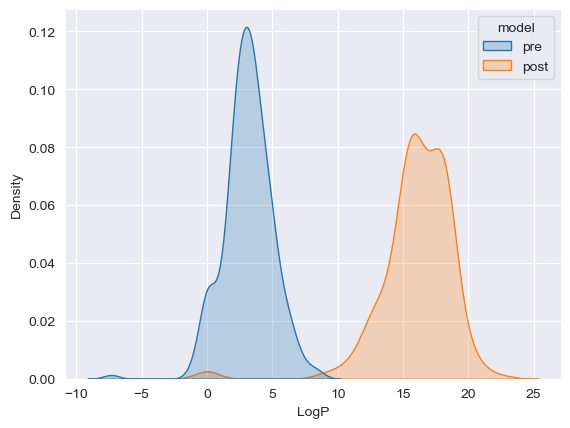

In [59]:
sns.kdeplot(data=df, x='LogP', hue='model', fill=True)